# TalentSol - Applicant Tracking System Learning Project (Supervised Machine Learning Component with Decision Trees)

This notebook documents the machine learning component of the TalentSol project. The goal is to build a supervised classifier to assist in prioritizing job applicants based on their fit for a given job role and description. We will explore different text embedding techniques and evaluate their impact on model performance.

---

In [ ]:
# TalentSol is an AI-powered applicant tracking system with machine learning features designed to streamline the recruitment process. This is a hobbyist AI/machine learning related project using Augment Code as development partner, and is available on GitHub (https://github.com/youshen-lim/TalentSol---Applicant-Tracking-System-Application). TalentSol aims to revolutionize how companies manage their recruitment pipeline through intelligent job candidate matching or priorization and recruitment workflow optimization.

# Data Requirement and Criteria: For my first machine learning model of a supervised classifier (using Decision Tree) to predict candidates for prioritization,

## 1. Setup and Data Loading

This section covers installing necessary libraries and loading the dataset.

### 1.1 Load the Dataset

Load the job applicant dataset into a pandas DataFrame.

In [ ]:
# TalentSol is an AI-powered applicant tracking system with machine learning features designed to streamline the recruitment process. This is a hobbyist AI/machine learning related project using Augment Code as development partner, and is available on GitHub (https://github.com/youshen-lim/TalentSol---Applicant-Tracking-System-Application). TalentSol aims to revolutionize how companies manage their recruitment pipeline through intelligent job candidate matching or priorization and recruitment workflow optimization.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from transformers import AutoModel, AutoTokenizer # Import libraries for ModernBERT embeddings, if we are ever considering ModerBERT for text embedding
!pip install gensim # Install gensim and restart session

# Load the dataset from the specified path.
# The dataset contains information about job applicants, including text data (resume, job description)
# and categorical data, along with a 'Best Match' target variable.

df = pd.read_csv('/content/job_applicant_dataset.csv')

# Display the first few rows to inspect the data structure and content.
display(df.head())

# Display information about the DataFrame, including data types and non-null counts.
display(df.info())

# Display descriptive statistics for numerical columns.
display(df.describe())

,Job Applicant Name,Age,Gender,Race,Ethnicity,Resume,Job Roles,Job Description,Best Match
0,Daisuke Mori,29,Male,Mongoloid/Asian,Vietnamese,"Proficient in Injury Prevention, Motivation, N...",Fitness Coach,A Fitness Coach is responsible for helping cl...,0
1,Taichi Shimizu,31,Male,Mongoloid/Asian,Filipino,"Proficient in Healthcare, Pharmacology, Medica...",Physician,"Diagnose and treat illnesses, prescribe medica...",0
2,Sarah Martin,46,Female,White/Caucasian,Dutch,"Proficient in Forecasting, Financial Modelling...",Financial Analyst,"As a Financial Analyst, you will be responsibl...",0
3,Keith Hughes,43,Male,Negroid/Black,Caribbean,"Proficient in Budgeting, Supply Chain Optimiza...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1
4,James Davis,49,Male,White/Caucasian,English,"Proficient in Logistics, Negotiation, Procurem...",Supply Chain Manager,A Supply Chain Manager oversees the entire sup...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Applicant Name  10000 non-null  object
 1   Age                 10000 non-null  int64 
 2   Gender              10000 non-null  object
 3   Race                10000 non-null  object
 4   Ethnicity           10000 non-null  object
 5   Resume              10000 non-null  object
 6   Job Roles           10000 non-null  object
 7   Job Description     10000 non-null  object
 8   Best Match          10000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 703.3+ KB


None

,Age,Best Match
count,10000.000000,10000.0000
mean,40.045200,0.4850
std,8.950909,0.4998
min,25.000000,0.0000
25%,32.000000,0.0000
50%,40.000000,0.0000
75%,48.000000,1.0000
max,55.000000,1.0000


## 2. Data Preprocessing and Feature Engineering

This section focuses on cleaning the data and transforming it into a format suitable for machine learning models, including handling text and categorical features.

### 2.1 Initial Data Cleaning and Preparation

Perform initial data cleaning steps such as handling identifiers and removing irrelevant features.

In [ ]:
# Replace 'Job Applicant Name' with a unique 'Job Applicant ID' for anonymity.
# This ensures personal names are not directly used, which is a good practice for privacy.
df['Job Applicant ID'] = range(1, len(df) + 1)
# df = df.drop('Job Applicant Name', axis=1) # Remove the original name column - This was done in previous turns

# Drop the 'Job Applicant ID' column as requested, to prevent unintended statistical association.
if 'Job Applicant ID' in df.columns:
    df = df.drop('Job Applicant ID', axis=1)
    print("Dropped 'Job Applicant ID' column.")

# Drop the 'Age' column as it is not deemed relevant for this prioritization task.
# In a real-world scenario, the relevance of features like age would need careful consideration
# based on legal and ethical guidelines.
if 'Age' in df.columns:
    df = df.drop('Age', axis=1)
    print("Dropped 'Age' column.")

# Drop the 'Gender' column for this iteration of the project.
# In a real-world application, handling gender and other sensitive attributes requires
# careful consideration of fairness and bias mitigation.
if 'Gender' in df.columns:
    df = df.drop('Gender', axis=1)
    print("Dropped 'Gender' column.")

# Display the columns after dropping some.
print("\nRemaining columns:")
print(df.columns)

Dropped 'Job Applicant ID' column.
Dropped 'Age' column.
Dropped 'Gender' column.

Remaining columns:
Index(['Job Applicant Name', 'Race', 'Ethnicity', 'Resume', 'Job Roles',
       'Job Description', 'Best Match'],
      dtype='object')


### 2.2 Handle Missing Values

Check for and confirm no missing values are present after initial cleaning.

In [ ]:
# Check for any missing values in the DataFrame after initial cleaning.
# The sum() method is used to count the number of missing values per column.
print("Checking for missing values after initial cleaning:")
display(df.isnull().sum())

# Based on previous checks, we expect no missing values here.
# If missing values were present, strategies like imputation or dropping rows/columns would be needed.

Checking for missing values after initial cleaning:


,0
Job Applicant Name,0
Race,0
Ethnicity,0
Resume,0
Job Roles,0
Job Description,0
Best Match,0


### 2.3 Feature Engineering: Handling Categorical Data

In [ ]:
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder # Ensure OneHotEncoder is imported
from sklearn.compose import ColumnTransformer # Ensure ColumnTransformer is imported
from sklearn.pipeline import Pipeline # Ensure Pipeline is imported
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV # Ensure these are imported

# Assume df is available from the data loading step (1.1) and relevant columns are dropped in cell 51965c4e.

# Define text and categorical columns
text_cols = ['Job Description', 'Resume']
# Initial categorical columns before Race split
categorical_cols = ['Ethnicity', 'Job Roles']

# Drop 'Job Applicant Name' column if it exists.
# This ensures personal names are not directly used.
if 'Job Applicant Name' in df.columns:
    df = df.drop('Job Applicant Name', axis=1)
    print("Dropped 'Job Applicant Name' column.")

# Drop 'Job Applicant ID' column if it exists.
# This ensures the generated ID is not used as a feature.
if 'Job Applicant ID' in df.columns:
    df = df.drop('Job Applicant ID', axis=1)
    print("Dropped 'Job Applicant ID' column.")


# Drop the 'Age' column as it is not deemed relevant for this prioritization task and for responsible AI considerations.
if 'Age' in df.columns:
    df = df.drop('Age', axis=1)
    print("Dropped 'Age' column.")

# Drop the 'Gender' column for responsible AI considerations.
if 'Gender' in df.columns:
    df = df.drop('Gender', axis=1)
    print("Dropped 'Gender' column.")


# Split the 'Race' column into 'Race1' and 'Race2' if it exists.
if 'Race' in df.columns:
    # Split the 'Race' column into 'Race1' and 'Race2' based on the '/' delimiter.
    # Handle cases where the format might be different or missing '/'.
    race_split = df['Race'].str.split('/', expand=True)

    # Assign the split parts to new columns 'Race1' and 'Race2'.
    # Handle potential missing second part by filling with a placeholder like 'Unknown' or None.
    df['Race1'] = race_split[0]
    df['Race2'] = race_split[1].fillna('Unknown') # Fill missing secondary race

    # Drop the original 'Race' column as it's now split.
    df = df.drop('Race', axis=1)
    print("Split 'Race' into 'Race1' and 'Race2' and dropped original 'Race' column.")

# Drop the 'Race1' and 'Race2' columns to address bias and discrimination concerns.
if 'Race1' in df.columns:
    df = df.drop('Race1', axis=1)
    print("Dropped 'Race1' column to address bias concerns.")
if 'Race2' in df.columns:
    df = df.drop('Race2', axis=1)
    print("Dropped 'Race2' column to address bias concerns.")

# Update categorical_cols_for_encoding to only include the remaining categorical columns
categorical_cols_for_encoding = categorical_cols
print("Categorical columns for encoding:", categorical_cols_for_encoding)


# Check the distribution of the target variable ('Best Match').
print("Original dataset class distribution (after initial processing):")
display(df['Best Match'].value_counts())

# Separate the majority and minority classes based on the 'Best Match' column.
df_majority = df[df['Best Match']==0] # Class 0 is the majority
df_minority = df[df['Best Match']==1] # Class 1 is the minority

# Upsample the minority class to match the number of samples in the majority class.
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority), # to match majority class
                                 random_state=42) # reproducible results

# Combine the upsampled minority class DataFrame with the original majority class DataFrame.
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display the class distribution after upsampling to confirm balance.
print("\nUpsampled dataset class distribution:")
display(df_upsampled['Best Match'].value_counts())

# Shuffle the upsampled dataset to mix the instances of both classes.
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the head of the shuffled upsampled dataset.
print("\nHead of the shuffled upsampled dataset:")
display(df_upsampled.head())

# Separate the upsampled DataFrame into features (X) and the target variable (y).
X_upsampled = df_upsampled.drop('Best Match', axis=1)
y_upsampled = df_upsampled['Best Match']

# Display the shapes of the feature and target dataframes to verify.
print("\nShape of upsampled features (X_upsampled):", X_upsampled.shape)
print("Shape of upsampled target (y_upsampled):", y_upsampled.shape)

# Note: df_upsampled, X_upsampled, y_upsampled, text_cols, and categorical_cols_for_encoding are now available.

Dropped 'Job Applicant Name' column.
Split 'Race' into 'Race1' and 'Race2' and dropped original 'Race' column.
Dropped 'Race1' column to address bias concerns.
Dropped 'Race2' column to address bias concerns.
Categorical columns for encoding: ['Ethnicity', 'Job Roles']
Original dataset class distribution (after initial processing):


,count
Best Match,
0,5150
1,4850



Upsampled dataset class distribution:


,count
Best Match,
0,5150
1,5150



Head of the shuffled upsampled dataset:


,Ethnicity,Resume,Job Roles,Job Description,Best Match
0,Kenyan,"Proficient in Business Intelligence, Project M...",Business Analyst,"As a Business Analyst, you will be responsible...",1
1,Jamaican,"Proficient in Case Management, Legal Research,...",Lawyer,A Lawyer provides legal counsel and represents...,0
2,Ethiopian,"Proficient in Recruiting, Labor Laws, Intervie...",HR Specialist,"As an HR Specialist, you will play a key role ...",1
3,Kenyan,"Proficient in Environmental Policy, Climate Ch...",Environmental Scientist,"As an Environmental Scientist, you will conduc...",1
4,English,"Proficient in Project Management, Blueprint Re...",Construction Manager,The Construction Manager is responsible for ov...,0



Shape of upsampled features (X_upsampled): (10300, 4)
Shape of upsampled target (y_upsampled): (10300,)


### 2.4 Handle Class Imbalance

Address the class imbalance in the target variable ('Best Match') using oversampling and prepare Word2Vec features.

### 2.4.1 Visualize Class Distribution

Visualize the class distribution of the target variable ('Best Match') using a histogram.

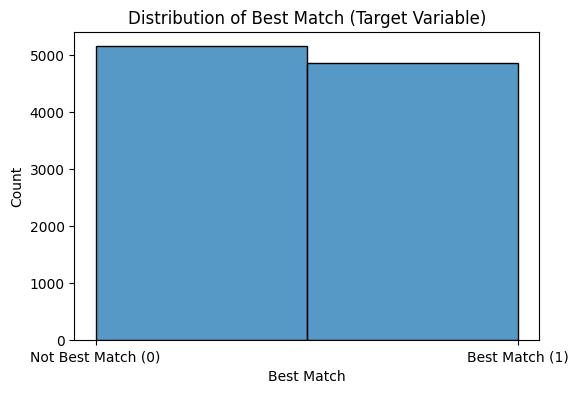

Displayed histogram of 'Best Match' distribution.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram to visualize the distribution of the 'Best Match' column.
# This helps to clearly see if there is a class imbalance (unequal number of samples per class).
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Best Match', bins=2, kde=False) # Use histplot for count-based histogram
plt.title('Distribution of Best Match (Target Variable)')
plt.xlabel('Best Match')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Best Match (0)', 'Best Match (1)']) # Label x-axis ticks
plt.show()

print("Displayed histogram of 'Best Match' distribution.")

### 2.4.2 Handle Class Imbalance and Prepare Word2Vec & FastText Features

This section addresses the class imbalance in the target variable ('Best Match') using resampling.

In [ ]:
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin # Import BaseEstimator and TransformerMixin
import numpy as np # Import numpy
import pandas as pd # Ensure pandas is imported
from gensim.models import Word2Vec, FastText # Explicitly import Word2Vec and FastText

# Load the dataset from the specified path.
# The dataset contains information about job applicants, including text data (resume, job description)
# and categorical data, along with a 'Best Match' target variable.
# Note: This cell is now only responsible for loading the initial data and performing upsampling.
# Further preprocessing steps (like splitting Race, dropping columns) are consolidated in cell ef6dd6d3.
# df = pd.read_csv('/content/sample_data/job_applicant_dataset.csv') # REMOVED: Data loading is handled in cell 96831522 or 23f02475 and preprocessing in ef6dd6d3

# Check the distribution of the target variable ('Best Match').
# We expect to see an imbalance where one class is significantly larger than the other.
# Use the 'df' DataFrame which should have been processed by cell ef6dd6d3.
print("Original dataset class distribution (after initial processing):")
display(df['Best Match'].value_counts())

# Separate the majority and minority classes based on the 'Best Match' column.
# Use the 'df' DataFrame for splitting.
df_majority = df[df['Best Match']==0] # Class 0 is the majority
df_minority = df[df['Best Match']==1] # Class 1 is the minority

# Upsample the minority class to match the number of samples in the majority class.
# 'replace=True' allows for sampling with replacement.
# 'n_samples=len(df_majority)' sets the number of samples in the upsampled minority class.
# 'random_state' ensures reproducibility of the upsampling.
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority), # to match majority class
                                 random_state=42) # reproducible results

# Combine the upsampled minority class DataFrame with the original majority class DataFrame.
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display the class distribution after upsampling to confirm balance.
print("\nUpsampled dataset class distribution:")
display(df_upsampled['Best Match'].value_counts())

# Shuffle the upsampled dataset to mix the instances of both classes.
# This is important to prevent the model from learning patterns based on the order of data.
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the head of the shuffled upsampled dataset.
print("\nHead of the shuffled upsampled dataset:")
display(df_upsampled.head())

# Define a custom transformer for integrating Word2Vec into the pipeline.
# This transformer applies the document_vector function to the specified text columns.
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model, min_word_length=2, fallback_strategy='zero'):
        """
        Word2Vec vectorizer with error handling.

        Parameters:
        - word2vec_model: Trained Word2Vec model
        - min_word_length: Minimum word length to consider (default: 2)
        - fallback_strategy: Strategy for OOV words ('zero', 'skip', 'mean')
        """
        self.word2vec_model = word2vec_model
        self.vector_size = word2vec_model.wv.vector_size
        self.min_word_length = min_word_length
        self.fallback_strategy = fallback_strategy

        # Pre-compute vocabulary set for faster lookup
        self.vocab_set = set(word2vec_model.wv.key_to_index.keys())

        # Pre-compute mean vector for fallback if needed
        if fallback_strategy == 'mean':
            try:
                all_vectors = [word2vec_model.wv[word] for word in list(self.vocab_set)[:1000]]  # Sample for efficiency
                self.mean_vector = np.mean(all_vectors, axis=0)
            except:
                self.mean_vector = np.zeros(self.vector_size)
        else:
            self.mean_vector = np.zeros(self.vector_size)

    def document_vector(self, doc):
        """Convert document to vector with robust error handling."""
        # Handle empty or None documents
        if not doc or not isinstance(doc, str):
            return self.mean_vector.copy()

        # Clean and tokenize the document
        try:
            # More aggressive cleaning
            words = []
            for word in doc.split():
                word = word.strip().lower()  # Convert to lowercase for consistency
                # Filter by length and basic character validation
                if (len(word) >= self.min_word_length and
                    word.isalpha() and  # Only alphabetic characters
                    word in self.vocab_set):  # Check vocabulary
                    words.append(word)

            if not words:
                return self.mean_vector.copy()

            # Get vectors for valid words
            word_vectors = []
            for word in words:
                try:
                    vector = self.word2vec_model.wv[word]
                    word_vectors.append(vector)
                except (KeyError, AttributeError):
                    # Skip problematic words
                    continue

            if not word_vectors:
                return self.mean_vector.copy()

            # Return average of word vectors
            return np.mean(word_vectors, axis=0)

        except Exception as e:
            # Log warning and return fallback
            warnings.warn(f"Word2Vec document_vector error: {e}", UserWarning)
            return self.mean_vector.copy()

    def fit(self, X, y=None):
        """No fitting needed for this transformer as the model is pre-trained."""
        return self

    def transform(self, X):
        """Transform documents to vectors with error handling."""
        result_vectors = []

        # Handle different input types
        if isinstance(X, pd.Series):
            documents = X.tolist()
        elif isinstance(X, np.ndarray):
            documents = X.tolist() if X.ndim == 1 else X.flatten().tolist()
        elif isinstance(X, list):
            documents = X
        else:
            raise TypeError("Input X must be a pandas Series, numpy array, or list of strings.")

        # Process each document
        for i, doc in enumerate(documents):
            try:
                # Ensure doc is a string
                if doc is None:
                    doc = ""
                elif not isinstance(doc, str):
                    doc = str(doc)

                vector = self.document_vector(doc)

                # Validate vector dimensions
                if vector.shape != (self.vector_size,):
                    vector = self.mean_vector.copy()

                result_vectors.append(vector)

            except Exception as e:
                # Use fallback vector for problematic documents
                warnings.warn(f"Word2Vec transform error for document {i}: {e}", UserWarning)
                result_vectors.append(self.mean_vector.copy())

        # Ensure we have the right number of vectors
        if len(result_vectors) != len(documents):
            raise ValueError(f"Mismatch in vector count: {len(result_vectors)} vs {len(documents)}")

        return np.vstack(result_vectors)


# Custom transformer for integrating FastText into the pipeline.
class FastTextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, fasttext_model, min_word_length=2, fallback_strategy='zero'):
        """
        FastText vectorizer with error handling.

        Parameters:
        - fasttext_model: Trained FastText model
        - min_word_length: Minimum word length to consider (default: 2)
        - fallback_strategy: Strategy for OOV words ('zero', 'skip', 'mean')
        """
        self.fasttext_model = fasttext_model
        self.vector_size = fasttext_model.wv.vector_size
        self.min_word_length = min_word_length
        self.fallback_strategy = fallback_strategy

        # Pre-compute mean vector for fallback if needed
        if fallback_strategy == 'mean':
            try:
                # Sample some words to compute mean vector
                vocab_sample = list(fasttext_model.wv.key_to_index.keys())[:1000]
                all_vectors = [fasttext_model.wv[word] for word in vocab_sample]
                self.mean_vector = np.mean(all_vectors, axis=0)
            except:
                self.mean_vector = np.zeros(self.vector_size)
        else:
            self.mean_vector = np.zeros(self.vector_size)

    def document_vector(self, doc):
        """Convert document to vector with robust error handling."""
        # Handle empty or None documents
        if not doc or not isinstance(doc, str):
            return self.mean_vector.copy()

        try:
            # Clean and tokenize the document
            words = []
            for word in doc.split():
                word = word.strip().lower()  # Convert to lowercase for consistency
                # Filter by length and basic character validation
                if len(word) >= self.min_word_length and word.isalpha():
                    words.append(word)

            if not words:
                return self.mean_vector.copy()

            # Use FastText's get_mean_vector method which handles OOV better
            try:
                return self.fasttext_model.wv.get_mean_vector(words)
            except AttributeError:
                # Fallback to manual averaging if get_mean_vector is not available
                word_vectors = []
                for word in words:
                    try:
                        vector = self.fasttext_model.wv[word]
                        word_vectors.append(vector)
                    except (KeyError, AttributeError):
                        # FastText should handle OOV, but just in case
                        continue

                if word_vectors:
                    return np.mean(word_vectors, axis=0)
                else:
                    return self.mean_vector.copy()

        except Exception as e:
            # Log warning and return fallback
            warnings.warn(f"FastText document_vector error: {e}", UserWarning)
            return self.mean_vector.copy()

    def fit(self, X, y=None):
        """No fitting needed for this transformer as the model is pre-trained."""
        return self

    def transform(self, X):
        """Transform documents to vectors with error handling."""
        result_vectors = []

        # Handle different input types
        if isinstance(X, pd.Series):
            documents = X.tolist()
        elif isinstance(X, np.ndarray):
            documents = X.tolist() if X.ndim == 1 else X.flatten().tolist()
        elif isinstance(X, list):
            documents = X
        else:
            raise TypeError("Input X must be a pandas Series, numpy array, or list of strings.")

        # Process each document
        for i, doc in enumerate(documents):
            try:
                # Ensure doc is a string
                if doc is None:
                    doc = ""
                elif not isinstance(doc, str):
                    doc = str(doc)

                vector = self.document_vector(doc)

                # Validate vector dimensions
                if vector.shape != (self.vector_size,):
                    vector = self.mean_vector.copy()

                result_vectors.append(vector)

            except Exception as e:
                # Use fallback vector for problematic documents
                warnings.warn(f"FastText transform error for document {i}: {e}", UserWarning)
                result_vectors.append(self.mean_vector.copy())

        # Ensure we have the right number of vectors
        if len(result_vectors) != len(documents):
            raise ValueError(f"Mismatch in vector count: {len(result_vectors)} vs {len(documents)}")

        return np.vstack(result_vectors)


print("Enhanced Word2VecVectorizer and FastTextVectorizer custom transformers defined.")


# IMPROVED: Enhanced text cleaning function
def clean_text_for_embedding(text):
    """Enhanced text cleaning to prevent embedding lookup errors."""
    if not isinstance(text, str):
        text = str(text) if text is not None else ""

    # More aggressive cleaning
    import re

    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Split and filter words
    words = text.split()

    # Filter out very short words (length <= 1) and empty strings
    # Also convert to lowercase for consistency
    cleaned_words = [word.lower() for word in words if len(word) > 1 and word.isalpha()]

    return ' '.join(cleaned_words)


# IMPROVED: Enhanced model training with better error handling
print("--- Training Word2Vec and FastText Models (Enhanced) ---")

# Check if necessary variables are available
if 'df_upsampled' not in globals() or globals()['df_upsampled'] is None:
    print("Error: df_upsampled not found or is None. Please run preprocessing steps (Section 2.5) first.")
elif 'text_cols' not in locals() or text_cols is None:
     print("Error: text_cols not found or is None. Please run preprocessing steps (Section 2.3) first.")
else:
    # Prepare text data for training Word2Vec and FastText models.
    print("Cleaning and tokenizing text data for model training...")
    df_upsampled_clean = df_upsampled.copy()

    # Enhanced text cleaning
    for col in text_cols:
        df_upsampled_clean[col] = df_upsampled_clean[col].apply(clean_text_for_embedding)

    # Tokenize and filter empty documents
    tokenized_data = []
    for col in text_cols:
        tokenized_col = df_upsampled_clean[col].apply(lambda x: x.split() if x else [])
        # Filter out empty token lists
        tokenized_col = tokenized_col[tokenized_col.apply(len) > 0]
        tokenized_data.append(tokenized_col)

    # Combine the tokenized text data from all columns
    combined_corpus = pd.concat(tokenized_data, ignore_index=True).tolist()

    # Filter out empty documents
    combined_corpus = [doc for doc in combined_corpus if len(doc) > 0]

    print(f"Combined corpus size: {len(combined_corpus)} documents")
    print(f"Sample document: {combined_corpus[0][:10] if combined_corpus else 'No documents'}")

    print("\n--- Training Word2Vec Model (Enhanced) ---")
    try:
        # Enhanced Word2Vec training with better parameters
        job_desc_w2v_model = Word2Vec(
            sentences=combined_corpus,
            vector_size=100,
            window=5,
            min_count=2,  # Reduced min_count to capture more words
            workers=4,
            epochs=20,    # Increased epochs for better training
            sg=0,         # Use CBOW
            alpha=0.025,  # Learning rate
            min_alpha=0.0001,
            seed=42       # For reproducibility
        )
        resume_w2v_model = job_desc_w2v_model  # Use the same model for consistency

        print("Word2Vec model trained successfully.")
        print(f"Word2Vec vector size: {job_desc_w2v_model.wv.vector_size}")
        print(f"Word2Vec vocabulary size: {len(job_desc_w2v_model.wv.key_to_index)}")

    except Exception as e:
        print(f"An error occurred during Word2Vec model training: {e}")
        import traceback
        traceback.print_exc()
        job_desc_w2v_model = None
        resume_w2v_model = None

    print("\n--- Training FastText Model (Enhanced) ---")
    try:
        # Enhanced FastText training with better parameters
        job_desc_ft_model = FastText(
            sentences=combined_corpus,
            vector_size=100,
            window=5,
            min_count=2,  # Reduced min_count to capture more words
            workers=4,
            epochs=20,    # Increased epochs for better training
            sg=0,         # Use CBOW
            alpha=0.025,  # Learning rate
            min_alpha=0.0001,
            seed=42,      # For reproducibility
            min_n=3,      # Minimum character n-gram
            max_n=6       # Maximum character n-gram
        )
        resume_ft_model = job_desc_ft_model  # Use the same model for consistency

        print("FastText model trained successfully.")
        print(f"FastText vector size: {job_desc_ft_model.wv.vector_size}")
        print(f"FastText vocabulary size: {len(job_desc_ft_model.wv.key_to_index)}")

    except Exception as e:
        print(f"An error occurred during FastText model training: {e}")
        import traceback
        traceback.print_exc()
        job_desc_ft_model = None
        resume_ft_model = None

    print("\n--- Finished Training Word2Vec and FastText Models ---")

    print("\n--- Storing Models in Dictionary ---")
    if 'trained_embedding_models' not in globals():
        trained_embedding_models = {}

    if job_desc_w2v_model is not None:
        trained_embedding_models['Word2Vec'] = job_desc_w2v_model
        print("✓ Word2Vec model stored")

    if job_desc_ft_model is not None:
        trained_embedding_models['FastText'] = job_desc_ft_model
        print("✓ FastText model stored")

    print(f"Models available: {list(trained_embedding_models.keys())}")

    # Test the vectorizers to ensure they work
    print("\n--- Testing Vectorizers ---")
    if job_desc_w2v_model is not None:
        try:
            w2v_vectorizer = Word2VecVectorizer(job_desc_w2v_model)
            test_docs = ["this is a test document", "another test", ""]
            test_vectors = w2v_vectorizer.transform(test_docs)
            print(f"✓ Word2Vec vectorizer test passed. Output shape: {test_vectors.shape}")
        except Exception as e:
            print(f"✗ Word2Vec vectorizer test failed: {e}")

    if job_desc_ft_model is not None:
        try:
            ft_vectorizer = FastTextVectorizer(job_desc_ft_model)
            test_docs = ["this is a test document", "another test", ""]
            test_vectors = ft_vectorizer.transform(test_docs)
            print(f"✓ FastText vectorizer test passed. Output shape: {test_vectors.shape}")
        except Exception as e:
            print(f"✗ FastText vectorizer test failed: {e}")




# Note: job_desc_w2v_model, resume_w2v_model, job_desc_ft_model, and resume_ft_model
# are now available (if training was successful) for use in subsequent sections
# like 3.4.1 and 3.4.2.
# Note: df_upsampled, word2vec_model, fasttext_model, document_vector,
# Word2VecTransformer class, and FastTextTransformer class are now available.
# Error handling should prevent the KeyError issues in stacking/voting classifiers

Original dataset class distribution (after initial processing):


,count
Best Match,
0,5150
1,4850



Upsampled dataset class distribution:


,count
Best Match,
0,5150
1,5150



Head of the shuffled upsampled dataset:


,Ethnicity,Resume,Job Roles,Job Description,Best Match
0,Kenyan,"Proficient in Business Intelligence, Project M...",Business Analyst,"As a Business Analyst, you will be responsible...",1
1,Jamaican,"Proficient in Case Management, Legal Research,...",Lawyer,A Lawyer provides legal counsel and represents...,0
2,Ethiopian,"Proficient in Recruiting, Labor Laws, Intervie...",HR Specialist,"As an HR Specialist, you will play a key role ...",1
3,Kenyan,"Proficient in Environmental Policy, Climate Ch...",Environmental Scientist,"As an Environmental Scientist, you will conduc...",1
4,English,"Proficient in Project Management, Blueprint Re...",Construction Manager,The Construction Manager is responsible for ov...,0


Enhanced Word2VecVectorizer and FastTextVectorizer custom transformers defined.
--- Training Word2Vec and FastText Models (Enhanced) ---
Cleaning and tokenizing text data for model training...
Combined corpus size: 20600 documents
Sample document: ['as', 'business', 'analyst', 'you', 'will', 'be', 'responsible', 'for', 'assessing', 'business']

--- Training Word2Vec Model (Enhanced) ---
Word2Vec model trained successfully.
Word2Vec vector size: 100
Word2Vec vocabulary size: 1531

--- Training FastText Model (Enhanced) ---
FastText model trained successfully.
FastText vector size: 100
FastText vocabulary size: 1531

--- Finished Training Word2Vec and FastText Models ---

--- Storing Models in Dictionary ---
✓ Word2Vec model stored
✓ FastText model stored
Models available: ['Word2Vec', 'FastText']

--- Testing Enhanced Vectorizers ---
✓ Word2Vec vectorizer test passed. Output shape: (3, 100)
✓ FastText vectorizer test passed. Output shape: (3, 100)


### 2.5 Prepare Data for Modeling

Separate features (X) and target (y) for the upsampled dataset.

In [ ]:
# Assuming the result of upsampling is X_upsampled and y_upsampled
# Define the features (X) and target (y) from the upsampled dataset.
# Assuming the target column is 'Best Match'.
# All other columns are features.

from sklearn.model_selection import train_test_split
print("Storing upsampled data in global namespace...")
globals()['X_upsampled'] = X_upsampled # Store X_upsampled globally
globals()['y_upsampled'] = y_upsampled # Store y_upsampled globally
print(f"X_upsampled shape: {globals()['X_upsampled'].shape}")
print(f"y_upsampled shape: {globals()['y_upsampled'].shape}")


print("Splitting upsampled data into training and test sets and storing globally...")
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(
    globals()['X_upsampled'], globals()['y_upsampled'], test_size=0.2, random_state=42, stratify=globals()['y_upsampled']
)

globals()['X_train_cv'] = X_train_cv # Store X_train_cv globally
globals()['X_test_cv'] = X_test_cv   # Store X_test_cv globally
globals()['y_train_cv'] = y_train_cv # Store y_train_cv globally
globals()['y_test_cv'] = y_test_cv   # Store y_test_cv globally

print(f"Train set shape: {globals()['X_train_cv'].shape}, {globals()['y_train_cv'].shape}")
print(f"Test set shape: {globals()['X_test_cv'].shape}, {globals()['y_test_cv'].shape}")

# Note: The variables X_upsampled, y_upsampled, X_train_cv, X_test_cv, y_train_cv, y_test_cv
# are now available in the global namespace for use in subsequent sections.

Storing upsampled data in global namespace...
X_upsampled shape: (10300, 4)
y_upsampled shape: (10300,)
Splitting upsampled data into training and test sets and storing globally...
Train set shape: (8240, 4), (8240,)
Test set shape: (2060, 4), (2060,)


## 3. Text Feature Embedding and Model Training

The preprocessing is complete and the data is ready for modeling. The next step is to implement and evaluate the Decision Tree models using TF-IDF, HashingVectorizer, CountVectorizer, Word2Vec and FastText as text features. This involves defining the preprocessing steps for each vectorizer within a ColumnTransformer, creating a pipeline that includes the preprocessor, scaler, and Decision Tree classifier, defining the parameter grid for tuning Decision Tree hyperparameters (and TF-IDF n-grams), performing GridSearchCV to find the best hyperparameters, evaluating the best model using cross-validation, calculating and plotting the confusion matrix, and generating predicted probabilities and precision-recall curve data for each model. I will combine the implementation and evaluation for these three vectorizers into a single code block.

### 3.1 Implement and Evaluate CountVectorizer Decision Tree Model

Create and evaluate a pipeline using CountVectorizer for text features, One-Hot Encoding for categorical features, Scaling, and a Decision Tree classifier. Tune Decision Tree hyperparameters and plot the confusion matrix.

--- Implementing and Evaluating CountVectorizer Decision Tree ---

--- Starting CountVectorizer Decision Tree ---
Using existing train/test split from Section 2.5.
CountVectorizer preprocessor defined.
CountVectorizer Decision Tree pipeline created.
Parameter grid for GridSearchCV defined.

Performing GridSearchCV for Decision Tree tuning on training data...

Best parameters found by GridSearchCV: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 10, 'decisiontreeclassifier__min_samples_split': 20}
Best cross-validation ROC AUC score (on training folds): 0.5576825985012726

Best CountVectorizer Decision Tree pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5398
  Precision: 0.5279
  Recall: 0.7524
  F1 Score: 0.6205
  ROC AUC: 0.5520

Confus

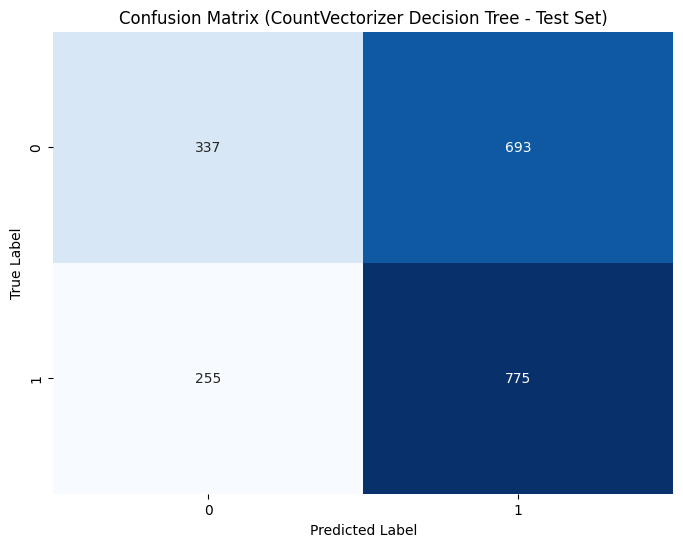


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for CountVectorizer Decision Tree.

--- Detailed Cross-Validation Results (on Training Data) ---

CountVectorizer Decision Tree Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished CountVectorizer Decision Tree ---


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback

# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).

print("--- Implementing and Evaluating CountVectorizer Decision Tree ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_countvectorizer'] = None
globals()['grid_search_countvectorizer'] = None
globals()['cv_results_countvectorizer'] = None # Cross-validation results on training data
globals()['y_pred_countvectorizer_test'] = None # Predictions on held-out test set
globals()['cm_countvectorizer_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_countvectorizer_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_countvectorizer_test'] = None # Probabilities on held-out test set

model_name_countvectorizer = "CountVectorizer Decision Tree"

print(f"\n--- Starting {model_name_countvectorizer} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_countvectorizer'] = None
    globals()['grid_search_countvectorizer'] = None
    globals()['cv_results_countvectorizer'] = None
    globals()['y_pred_countvectorizer_test'] = None
    globals()['cm_countvectorizer_test'] = None
    globals()['y_proba_countvectorizer_oof'] = None
    globals()['y_proba_countvectorizer_test'] = None
    pass # Skip the rest of the section
# Corrected check for text_cols and categorical_cols_for_encoding in globals()
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_countvectorizer'] = None
     globals()['grid_search_countvectorizer'] = None
     globals()['cv_results_countvectorizer'] = None
     globals()['y_pred_countvectorizer_test'] = None
     globals()['cm_countvectorizer_test'] = None
     globals()['y_proba_countvectorizer_oof'] = None
     globals()['y_proba_countvectorizer_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_countvectorizer'] = None
         globals()['grid_search_countvectorizer'] = None
         globals()['cv_results_countvectorizer'] = None
         globals()['y_pred_countvectorizer_test'] = None
         globals()['cm_countvectorizer_test'] = None
         globals()['y_proba_countvectorizer_oof'] = None
         globals()['y_proba_countvectorizer_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use CountVectorizer for text data and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_countvectorizer = ColumnTransformer(
                transformers=[
                    ('countvec_job', CountVectorizer(), globals()['text_cols'][0]), # CountVectorizer for Job Description
                    ('countvec_resume', CountVectorizer(), globals()['text_cols'][1]), # CountVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("CountVectorizer preprocessor defined.")
        except Exception as e:
             print(f"Error defining CountVectorizer preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_countvectorizer = None # Set to None on error


        if preprocessor_countvectorizer is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and DecisionTreeClassifier.
            pipeline_countvectorizer = Pipeline([
                ('preprocessor', preprocessor_countvectorizer),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output
                ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42)) # Decision Tree Classifier
            ])
            print("CountVectorizer Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Decision Tree.
            # Tune key DecisionTreeClassifier hyperparameters.
            param_grid_countvectorizer = {
                'decisiontreeclassifier__max_depth': [5, 7, 10, 12],           # Interpretable depths
                'decisiontreeclassifier__min_samples_split': [20, 50, 100],     # Require meaningful splits
                'decisiontreeclassifier__min_samples_leaf': [10, 20, 50],      # Prevent tiny leaf nodes
                'decisiontreeclassifier__max_features': ['sqrt', 'log2', None], # Feature sampling
                'decisiontreeclassifier__class_weight': ['balanced', None]      # Handle imbalance
            }
            print("Parameter grid for GridSearchCV defined.")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Decision Tree tuning on training data...")
            globals()['grid_search_countvectorizer'] = GridSearchCV(estimator=pipeline_countvectorizer,
                                          param_grid=param_grid_countvectorizer,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                globals()['grid_search_countvectorizer'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_countvectorizer'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_countvectorizer'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_countvectorizer'] = globals()['grid_search_countvectorizer'].best_estimator_
                print("\nBest CountVectorizer Decision Tree pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         globals()['y_pred_countvectorizer_test'] = globals()['best_pipeline_countvectorizer'].predict(X_test_cv)
                         globals()['y_proba_countvectorizer_test'] = globals()['best_pipeline_countvectorizer'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_countvectorizer_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_countvectorizer_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_countvectorizer_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_countvectorizer_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_countvectorizer_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_countvectorizer_test'] = confusion_matrix(y_test_cv, globals()['y_pred_countvectorizer_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_countvectorizer_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_countvectorizer} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_countvectorizer_test'] = None
                          globals()['cm_countvectorizer_test'] = None
                          globals()['y_proba_countvectorizer_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_countvectorizer_test'] = None
                     globals()['cm_countvectorizer_test'] = None
                     globals()['y_proba_countvectorizer_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_countvectorizer_oof'] = cross_val_predict(globals()['best_pipeline_countvectorizer'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for CountVectorizer Decision Tree.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_countvectorizer_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for CountVectorizer Decision Tree.")
                     globals()['y_proba_countvectorizer_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_countvectorizer_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_countvectorizer'] is not None and globals()['grid_search_countvectorizer'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_countvectorizer} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_countvectorizer_gs = globals()['grid_search_countvectorizer'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_countvectorizer_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_countvectorizer'].best_index_
                                     mean_score = cv_results_countvectorizer_gs[metric_key][best_index]
                                     # std_score = cv_results_countvectorizer_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_countvectorizer to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_countvectorizer'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_countvectorizer'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_countvectorizer'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_countvectorizer'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_countvectorizer'] = None
                globals()['grid_search_countvectorizer'] = None
                globals()['cv_results_countvectorizer'] = None
                globals()['y_pred_countvectorizer_test'] = None
                globals()['cm_countvectorizer_test'] = None
                globals()['y_proba_countvectorizer_oof'] = None
                globals()['y_proba_countvectorizer_test'] = None


        else:
            print("Skipping CountVectorizer Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_countvectorizer} ---")

# Note: best_pipeline_countvectorizer (fitted on X_train_cv), grid_search_countvectorizer,
# cv_results_countvectorizer (from GridSearchCV on X_train_cv), y_pred_countvectorizer_test (on X_test_cv),
# cm_countvectorizer_test (on X_test_cv), y_proba_countvectorizer_oof (on X_train_cv - might be None),
# and y_proba_countvectorizer_test (on X_test_cv) are now available in the global scope.
# y_proba_countvectorizer_oof will be used in Section 3.5 (Averaging Ensemble) and Section 4.1.
# y_proba_countvectorizer_test can be used for final evaluation on a consistent test set across models.

### 3.2 Implement and Evaluate TF-IDF Decision Tree Model

Create a pipeline using TF-IDF for text features, One-Hot Encoding for categorical features, Scaling, and a Decision Tree classifier. Tune Decision Tree hyperparameters and evaluate using cross-validation.

--- Implementing and Evaluating TF-IDF Decision Tree ---

--- Starting TF-IDF Decision Tree ---
Using existing train/test split from Section 2.5.
TF-IDF preprocessor defined.
TF-IDF Decision Tree pipeline created.
Parameter grid for GridSearchCV defined (same as 3.1).

Performing GridSearchCV for Decision Tree tuning on training data...

Best parameters found by GridSearchCV: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 12, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 20, 'decisiontreeclassifier__min_samples_split': 20}
Best cross-validation ROC AUC score (on training folds): 0.5659067478084646

Best TF-IDF Decision Tree pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5427
  Precision: 0.5250
  Recall: 0.8961
  F1 Score: 0.6621
  ROC AUC: 0.5568

Confusion Matrix (Test Set - Default 

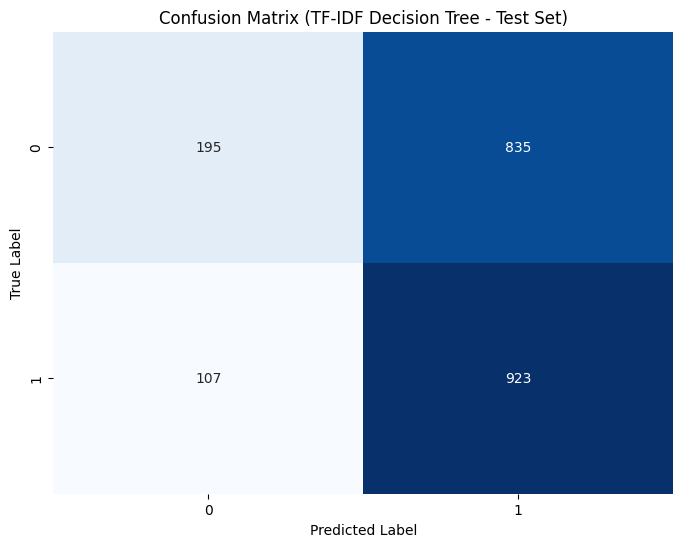


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for TF-IDF Decision Tree.

--- Detailed Cross-Validation Results (on Training Data) ---

TF-IDF Decision Tree Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.
Skipping detailed cross-validation: Training data not available.

--- Finished TF-IDF Decision Tree ---


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating TF-IDF Decision Tree ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_tfidf_dt'] = None # Using _dt suffix for Decision Tree
globals()['grid_search_tfidf_dt'] = None
globals()['cv_results_tfidf_dt'] = None # Cross-validation results on training data
globals()['y_pred_tfidf_dt_test'] = None # Predictions on held-out test set
globals()['cm_tfidf_dt_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_tfidf_dt_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_tfidf_dt_test'] = None # Probabilities on held-out test set


model_name_tfidf_dt = "TF-IDF Decision Tree"

print(f"\n--- Starting {model_name_tfidf_dt} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_tfidf_dt'] = None
    globals()['grid_search_tfidf_dt'] = None
    globals()['cv_results_tfidf_dt'] = None
    globals()['y_pred_tfidf_dt_test'] = None
    globals()['cm_tfidf_dt_test'] = None
    globals()['y_proba_tfidf_dt_oof'] = None
    globals()['y_proba_tfidf_dt_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_tfidf_dt'] = None
     globals()['grid_search_tfidf_dt'] = None
     globals()['cv_results_tfidf_dt'] = None
     globals()['y_pred_tfidf_dt_test'] = None
     globals()['cm_tfidf_dt_test'] = None
     globals()['y_proba_tfidf_dt_oof'] = None
     globals()['y_proba_tfidf_dt_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_tfidf_dt'] = None
         globals()['grid_search_tfidf_dt'] = None
         globals()['cv_results_tfidf_dt'] = None
         globals()['y_pred_tfidf_dt_test'] = None
         globals()['cm_tfidf_dt_test'] = None
         globals()['y_proba_tfidf_dt_oof'] = None
         globals()['y_proba_tfidf_dt_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use TfidfVectorizer for text data and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_tfidf_dt = ColumnTransformer(
                transformers=[
                    ('tfidf_job', TfidfVectorizer(), globals()['text_cols'][0]), # TfidfVectorizer for Job Description
                    ('tfidf_resume', TfidfVectorizer(), globals()['text_cols'][1]), # TfidfVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("TF-IDF preprocessor defined.")

        except Exception as e:
             print(f"Error defining TF-IDF preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_tfidf_dt = None # Set to None on error


        if preprocessor_tfidf_dt is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and DecisionTreeClassifier.
            pipeline_tfidf_dt = Pipeline([
                ('preprocessor', preprocessor_tfidf_dt),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output
                ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42)) # Decision Tree Classifier
            ])
            print("TF-IDF Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Decision Tree.
            # Tune key DecisionTreeClassifier hyperparameters (same as 3.1).
            param_grid_tfidf_dt = {
                'decisiontreeclassifier__max_depth': [5, 7, 10, 12],           # Interpretable depths
                'decisiontreeclassifier__min_samples_split': [20, 50, 100],     # Require meaningful splits
                'decisiontreeclassifier__min_samples_leaf': [10, 20, 50],      # Prevent tiny leaf nodes
                'decisiontreeclassifier__max_features': ['sqrt', 'log2', None], # Feature sampling
                'decisiontreeclassifier__class_weight': ['balanced', None]      # Handle imbalance
            }
            print("Parameter grid for GridSearchCV defined (same as 3.1).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Decision Tree tuning on training data...")
            globals()['grid_search_tfidf_dt'] = GridSearchCV(estimator=pipeline_tfidf_dt,
                                          param_grid=param_grid_tfidf_dt,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                globals()['grid_search_tfidf_dt'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_tfidf_dt'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_tfidf_dt'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_tfidf_dt'] = globals()['grid_search_tfidf_dt'].best_estimator_
                print("\nBest TF-IDF Decision Tree pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         globals()['y_pred_tfidf_dt_test'] = globals()['best_pipeline_tfidf_dt'].predict(X_test_cv)
                         globals()['y_proba_tfidf_dt_test'] = globals()['best_pipeline_tfidf_dt'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_tfidf_dt_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_tfidf_dt_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_tfidf_dt_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_tfidf_dt_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_tfidf_dt_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_tfidf_dt_test'] = confusion_matrix(y_test_cv, globals()['y_pred_tfidf_dt_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_tfidf_dt_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_tfidf_dt} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_tfidf_dt_test'] = None
                          globals()['cm_tfidf_dt_test'] = None
                          globals()['y_proba_tfidf_dt_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_tfidf_dt_test'] = None
                     globals()['cm_tfidf_dt_test'] = None
                     globals()['y_proba_tfidf_dt_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_tfidf_dt_oof'] = cross_val_predict(globals()['best_pipeline_tfidf_dt'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for TF-IDF Decision Tree.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_tfidf_dt_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for TF-IDF Decision Tree.")
                     globals()['y_proba_tfidf_dt_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_tfidf_dt_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_tfidf_dt'] is not None and globals()['grid_search_tfidf_dt'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_tfidf_dt} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_tfidf_dt_gs = globals()['grid_search_tfidf_dt'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_tfidf_dt_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_tfidf_dt'].best_index_
                                     mean_score = cv_results_tfidf_dt_gs[metric_key][best_index]
                                     # std_score = cv_results_tfidf_dt_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_tfidf_dt to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_tfidf_dt'] = True # Just a flag or store the relevant metrics if needed later

                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_tfidf_dt'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_tfidf_dt'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_tfidf_dt'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_tfidf_dt'] = None
                globals()['grid_search_tfidf_dt'] = None
                globals()['cv_results_tfidf_dt'] = None
                globals()['y_pred_tfidf_dt_test'] = None
                globals()['cm_tfidf_dt_test'] = None
                globals()['y_proba_tfidf_dt_oof'] = None
                globals()['y_proba_tfidf_dt_test'] = None


        else:
            print("Skipping TF-IDF Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_tfidf_dt} ---")

# Note: best_pipeline_tfidf_dt (fitted on X_train_cv), grid_search_tfidf_dt,
# cv_results_tfidf_dt (from GridSearchCV on X_train_cv), y_pred_tfidf_dt_test (on X_test_cv),
# cm_tfidf_dt_test (on X_test_cv), y_proba_tfidf_dt_oof (on X_train_cv - might be None),
# and y_proba_tfidf_dt_test (on X_test_cv) are now available in the global scope.
# y_proba_tfidf_dt_oof will be used in Section 3.5 (Averaging Ensemble) and Section 4.1.
# y_proba_tfidf_dt_test can be used for final evaluation on a consistent test set across models.

### 3.3 Implement and Evaluate HashingVectorizer Decision Tree Model

Create and evaluate a pipeline using HashingVectorizer for text features, One-Hot Encoding for categorical features, Scaling, and a Decision Tree classifier. Tune Decision Tree hyperparameters and plot the confusion matrix.

--- Implementing and Evaluating HashingVectorizer Decision Tree ---

--- Starting HashingVectorizer Decision Tree ---
Using existing train/test split from Section 2.5.
HashingVectorizer preprocessor defined.
HashingVectorizer Decision Tree pipeline created.
Parameter grid for GridSearchCV defined.

Performing GridSearchCV for Decision Tree tuning on training data...

Best parameters found by GridSearchCV: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 12, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 50, 'decisiontreeclassifier__min_samples_split': 20}
Best cross-validation ROC AUC score (on training folds): 0.5607436787161844

Best HashingVectorizer Decision Tree pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5413
  Precision: 0.5268
  Recall: 0.8107
  F1 Score: 0.6386
  ROC AUC: 0.55

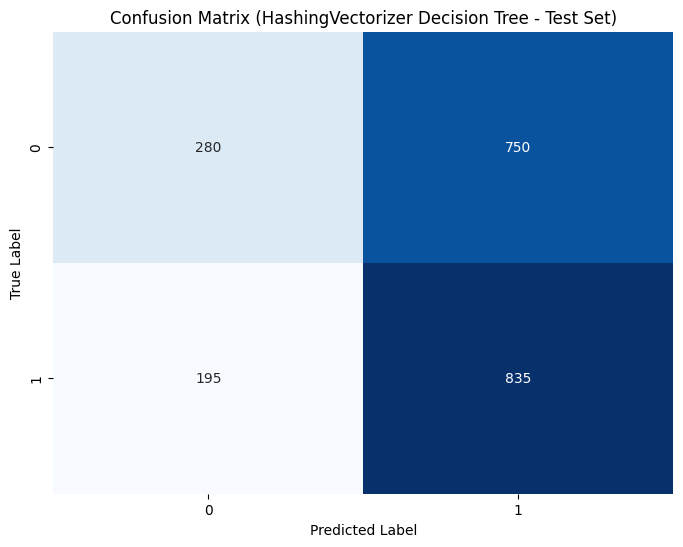


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for HashingVectorizer Decision Tree.

--- Detailed Cross-Validation Results (on Training Data) ---

HashingVectorizer Decision Tree Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished HashingVectorizer Decision Tree ---


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback

# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating HashingVectorizer Decision Tree ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_hashing'] = None
globals()['grid_search_hashing'] = None
globals()['cv_results_hashing'] = None # Cross-validation results on training data
globals()['y_pred_hashing_test'] = None # Predictions on held-out test set
globals()['cm_hashing_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_hashing_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_hashing_test'] = None # Probabilities on held-out test set

model_name_hashing = "HashingVectorizer Decision Tree"

print(f"\n--- Starting {model_name_hashing} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_hashing'] = None
    globals()['grid_search_hashing'] = None
    globals()['cv_results_hashing'] = None
    globals()['y_pred_hashing_test'] = None
    globals()['cm_hashing_test'] = None
    globals()['y_proba_hashing_oof'] = None
    globals()['y_proba_hashing_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_hashing'] = None
     globals()['grid_search_hashing'] = None
     globals()['cv_results_hashing'] = None
     globals()['y_pred_hashing_test'] = None
     globals()['cm_hashing_test'] = None
     globals()['y_proba_hashing_oof'] = None
     globals()['y_proba_hashing_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_hashing'] = None
         globals()['grid_search_hashing'] = None
         globals()['cv_results_hashing'] = None
         globals()['y_pred_hashing_test'] = None
         globals()['cm_hashing_test'] = None
         globals()['y_proba_hashing_oof'] = None
         globals()['y_proba_hashing_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_hashing = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("HashingVectorizer preprocessor defined.")
        except Exception as e:
             print(f"Error defining HashingVectorizer preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_hashing = None # Set to None on error


        if preprocessor_hashing is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and DecisionTreeClassifier.
            pipeline_hashing = Pipeline([
                ('preprocessor', preprocessor_hashing),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output
                ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42)) # Decision Tree Classifier
            ])
            print("HashingVectorizer Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Decision Tree.
            # Tune key DecisionTreeClassifier hyperparameters.
            param_grid_hashing = {
                'decisiontreeclassifier__max_depth': [5, 7, 10, 12],           # Interpretable depths
                'decisiontreeclassifier__min_samples_split': [20, 50, 100],     # Require meaningful splits
                'decisiontreeclassifier__min_samples_leaf': [10, 20, 50],      # Prevent tiny leaf nodes
                'decisiontreeclassifier__max_features': ['sqrt', 'log2', None], # Feature sampling
                'decisiontreeclassifier__class_weight': ['balanced', None]      # Handle imbalance
            }
            print("Parameter grid for GridSearchCV defined.")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Decision Tree tuning on training data...")
            globals()['grid_search_hashing'] = GridSearchCV(estimator=pipeline_hashing,
                                          param_grid=param_grid_hashing,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                globals()['grid_search_hashing'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_hashing'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_hashing'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_hashing'] = globals()['grid_search_hashing'].best_estimator_
                print("\nBest HashingVectorizer Decision Tree pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         globals()['y_pred_hashing_test'] = globals()['best_pipeline_hashing'].predict(X_test_cv)
                         globals()['y_proba_hashing_test'] = globals()['best_pipeline_hashing'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_hashing_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_hashing_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_hashing_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_hashing_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_hashing_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_hashing_test'] = confusion_matrix(y_test_cv, globals()['y_pred_hashing_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_hashing_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_hashing} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_hashing_test'] = None
                          globals()['cm_hashing_test'] = None
                          globals()['y_proba_hashing_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_hashing_test'] = None
                     globals()['cm_hashing_test'] = None
                     globals()['y_proba_hashing_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_hashing_oof'] = cross_val_predict(globals()['best_pipeline_hashing'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for HashingVectorizer Decision Tree.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_hashing_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for HashingVectorizer Decision Tree.")
                     globals()['y_proba_hashing_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_hashing_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_hashing'] is not None and globals()['grid_search_hashing'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_hashing} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_hashing_gs = globals()['grid_search_hashing'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_hashing_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_hashing'].best_index_
                                     mean_score = cv_results_hashing_gs[metric_key][best_index]
                                     # std_score = cv_results_hashing_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_hashing to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_hashing'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_hashing'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_hashing'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_hashing'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_hashing'] = None
                globals()['grid_search_hashing'] = None
                globals()['cv_results_hashing'] = None
                globals()['y_pred_hashing_test'] = None
                globals()['cm_hashing_test'] = None
                globals()['y_proba_hashing_oof'] = None
                globals()['y_proba_hashing_test'] = None


        else:
            print("Skipping HashingVectorizer Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_hashing} ---")

# Note: best_pipeline_hashing (fitted on X_train_cv), grid_search_hashing,
# cv_results_hashing (from GridSearchCV on X_train_cv), y_pred_hashing_test (on X_test_cv),
# cm_hashing_test (on X_test_cv), y_proba_hashing_oof (on X_train_cv - might be None),
# and y_proba_hashing_test (on X_test_cv) are now available in the global scope.
# y_proba_hashing_oof will be used in Section 3.5 (Averaging Ensemble) and Section 4.1.
# y_proba_hashing_test can be used for final evaluation on a consistent test set across models.

### 3.4.1 Implement and Evaluate Word2Vec Embeddings with Decision Tree

Create and evaluate a pipeline using a Decision Tree model based on Word2Vec embeddings for text features. Tune Decision Tree hyperparameters and plot the confusion matrix.

--- Implementing and Evaluating Word2Vec Embedding Decision Tree ---

--- Starting Word2Vec Embedding Decision Tree ---
Using existing train/test split from Section 2.5.
Word2Vec preprocessor defined.
Word2Vec Decision Tree pipeline created.
Parameter grid for GridSearchCV defined.

Performing GridSearchCV for Decision Tree tuning on training data...

Best parameters found by GridSearchCV: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 12, 'decisiontreeclassifier__max_features': 'log2', 'decisiontreeclassifier__min_samples_leaf': 10, 'decisiontreeclassifier__min_samples_split': 20}
Best cross-validation ROC AUC score (on training folds): 0.592000748185503

Best Word2Vec Decision Tree pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5510
  Precision: 0.5391
  Recall: 0.7019
  F1 Score: 0.6099
  ROC AUC: 0.5737

Confusion Matrix (Te

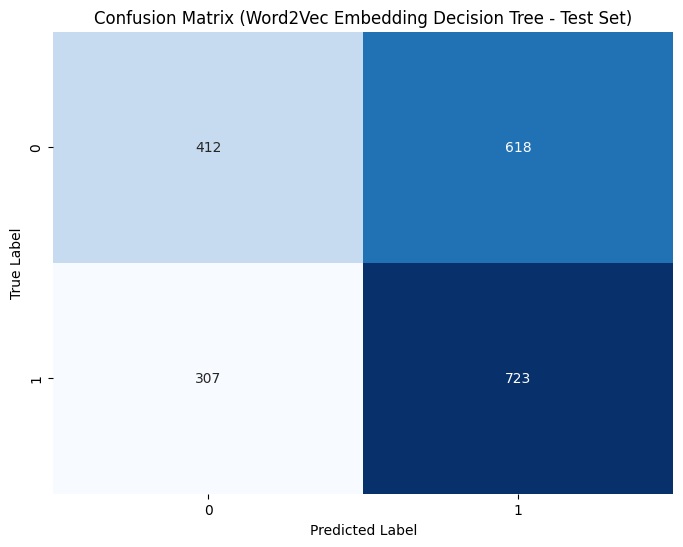


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for Word2Vec Decision Tree.

--- Detailed Cross-Validation Results (on Training Data) ---

Word2Vec Embedding Decision Tree Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished Word2Vec Embedding Decision Tree ---


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Word2Vec requires specific handling, often outside ColumnTransformer for document vectors
# Assuming Word2Vec model is already trained and available from a previous step (e.g., 2.4.2)

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback
import warnings

# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume trained_embedding_models (specifically 'Word2Vec') is available from Section 2.4.2.
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating Word2Vec Embedding Decision Tree ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_w2v_dt'] = None
globals()['grid_search_w2v_dt'] = None
globals()['cv_results_w2v_dt'] = None # Cross-validation results on training data
globals()['y_pred_w2v_dt_test'] = None # Predictions on held-out test set
globals()['cm_w2v_dt_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_w2v_dt_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_w2v_dt_test'] = None # Probabilities on held-out test set


model_name_w2v_dt = "Word2Vec Embedding Decision Tree"

print(f"\n--- Starting {model_name_w2v_dt} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_w2v_dt'] = None
    globals()['grid_search_w2v_dt'] = None
    globals()['cv_results_w2v_dt'] = None
    globals()['y_pred_w2v_dt_test'] = None
    globals()['cm_w2v_dt_test'] = None
    globals()['y_proba_w2v_dt_oof'] = None
    globals()['y_proba_w2v_dt_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_w2v_dt'] = None
     globals()['grid_search_w2v_dt'] = None
     globals()['cv_results_w2v_dt'] = None
     globals()['y_pred_w2v_dt_test'] = None
     globals()['cm_w2v_dt_test'] = None
     globals()['y_proba_w2v_dt_oof'] = None
     globals()['y_proba_w2v_dt_test'] = None
     pass # Skip the rest of the section
# Check for the trained Word2Vec model from Section 2.4.2
elif 'trained_embedding_models' not in globals() or 'Word2Vec' not in globals()['trained_embedding_models'] or globals()['trained_embedding_models']['Word2Vec'] is None:
     print("Error: Trained Word2Vec model ('trained_embedding_models['Word2Vec']') not found or is None. Please run Section 2.4.2 first.")
     # Ensure global variables are None
     globals()['best_pipeline_w2v_dt'] = None
     globals()['grid_search_w2v_dt'] = None
     globals()['cv_results_w2v_dt'] = None
     globals()['y_pred_w2v_dt_test'] = None
     globals()['cm_w2v_dt_test'] = None
     globals()['y_proba_w2v_dt_oof'] = None
     globals()['y_proba_w2v_dt_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_w2v_dt'] = None
         globals()['grid_search_w2v_dt'] = None
         globals()['cv_results_w2v_dt'] = None
         globals()['y_pred_w2v_dt_test'] = None
         globals()['cm_w2v_dt_test'] = None
         globals()['y_proba_w2v_dt_oof'] = None
         globals()['y_proba_w2v_dt_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']
        word2vec_model = globals()['trained_embedding_models']['Word2Vec']


        # Define a function to convert a list of tokens to a document vector by averaging word vectors
        # Handle empty documents gracefully by returning a zero vector
        def document_vector(word2vec_model, doc_tokens):
            # Filter out tokens not in the Word2Vec vocabulary
            valid_tokens = [token for token in doc_tokens if token in word2vec_model.wv]
            if not valid_tokens:
                # Return a zero vector of the appropriate size if no valid tokens
                return np.zeros(word2vec_model.vector_size)
            # Return the mean of vectors for valid tokens
            return np.mean([word2vec_model.wv[token] for token in valid_tokens], axis=0)

        # Define a custom transformer to apply Word2Vec averaging
        from sklearn.base import BaseEstimator, TransformerMixin

        class Word2VecVectorizer(BaseEstimator, TransformerMixin):
            def __init__(self, word2vec_model, min_word_length=2, fallback_strategy='zero'):
                """
                Word2Vec vectorizer with error handling.

                Parameters:
                - word2vec_model: Trained Word2Vec model
                - min_word_length: Minimum word length to consider (default: 2)
                - fallback_strategy: Strategy for OOV words ('zero', 'skip', 'mean')
                """
                self.word2vec_model = word2vec_model
                self.vector_size = word2vec_model.wv.vector_size
                self.min_word_length = min_word_length
                self.fallback_strategy = fallback_strategy

                # Pre-compute vocabulary set for faster lookup
                self.vocab_set = set(word2vec_model.wv.key_to_index.keys())

                # Pre-compute mean vector for fallback if needed
                if fallback_strategy == 'mean':
                    try:
                        all_vectors = [word2vec_model.wv[word] for word in list(self.vocab_set)[:1000]]  # Sample for efficiency
                        self.mean_vector = np.mean(all_vectors, axis=0)
                    except:
                        self.mean_vector = np.zeros(self.vector_size)
                else:
                    self.mean_vector = np.zeros(self.vector_size)

            def document_vector(self, doc):
                """Convert document to vector with robust error handling."""
                # Handle empty or None documents
                if not doc or not isinstance(doc, str):
                    return self.mean_vector.copy()

                # Clean and tokenize the document
                try:
                    # More aggressive cleaning
                    words = []
                    for word in doc.split():
                        word = word.strip().lower()  # Convert to lowercase for consistency
                        # Filter by length and basic character validation
                        if (len(word) >= self.min_word_length and
                            word.isalpha() and  # Only alphabetic characters
                            word in self.vocab_set):  # Check vocabulary
                            words.append(word)

                    if not words:
                        return self.mean_vector.copy()

                    # Get vectors for valid words
                    word_vectors = []
                    for word in words:
                        try:
                            vector = self.word2vec_model.wv[word]
                            word_vectors.append(vector)
                        except (KeyError, AttributeError):
                            # Skip problematic words
                            continue

                    if not word_vectors:
                        return self.mean_vector.copy()

                    # Return average of word vectors
                    return np.mean(word_vectors, axis=0)

                except Exception as e:
                    # Log warning and return fallback
                    warnings.warn(f"Word2Vec document_vector error: {e}", UserWarning)
                    return self.mean_vector.copy()

            def fit(self, X, y=None):
                """No fitting needed for this transformer as the model is pre-trained."""
                return self

            def transform(self, X):
                """Transform documents to vectors with enhanced error handling."""
                result_vectors = []

                # Handle different input types
                if isinstance(X, pd.Series):
                    documents = X.tolist()
                elif isinstance(X, np.ndarray):
                    documents = X.tolist() if X.ndim == 1 else X.flatten().tolist()
                elif isinstance(X, list):
                    documents = X
                else:
                    raise TypeError("Input X must be a pandas Series, numpy array, or list of strings.")

                # Process each document
                for i, doc in enumerate(documents):
                    try:
                        # Ensure doc is a string
                        if doc is None:
                            doc = ""
                        elif not isinstance(doc, str):
                            doc = str(doc)

                        vector = self.document_vector(doc)

                        # Validate vector dimensions
                        if vector.shape != (self.vector_size,):
                            vector = self.mean_vector.copy()

                        result_vectors.append(vector)

                    except Exception as e:
                        # Use fallback vector for problematic documents
                        warnings.warn(f"Word2Vec transform error for document {i}: {e}", UserWarning)
                        result_vectors.append(self.mean_vector.copy())

                # Ensure we have the right number of vectors
                if len(result_vectors) != len(documents):
                    raise ValueError(f"Mismatch in vector count: {len(result_vectors)} vs {len(documents)}")

                return np.vstack(result_vectors)


        # 2. Define the Preprocessor.
        # Use custom Word2VecVectorizer for text data and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            # Ensure tokenized text data is available in globals()
            if 'tokenized_job_desc' not in globals() or globals()['tokenized_job_desc'] is None or \
               'tokenized_resume' not in globals() or globals()['tokenized_resume'] is None:
                 print("Error: Tokenized text data (tokenized_job_desc, tokenized_resume) not found or are None. Please run Section 2.4.2 first.")
                 preprocessor_w2v_dt = None # Set to None to skip pipeline creation and evaluation
            else:
                preprocessor_w2v_dt = ColumnTransformer(
                    transformers=[
                        ('w2v_job', Word2VecVectorizer(word2vec_model), globals()['text_cols'][0]), # Word2Vec for Job Description
                        ('w2v_resume', Word2VecVectorizer(word2vec_model), globals()['text_cols'][1]), # Word2Vec for Resume
                        ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                    ],
                    remainder='drop' # Drop any other columns not transformed
                )
                print("Word2Vec preprocessor defined.")

        except Exception as e:
             print(f"Error defining Word2Vec preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_w2v_dt = None # Set to None on error


        if preprocessor_w2v_dt is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and DecisionTreeClassifier.
            pipeline_w2v_dt = Pipeline([
                ('preprocessor', preprocessor_w2v_dt),
                ('scaler', StandardScaler()), # StandardScaler is generally recommended after dense embeddings
                ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42)) # Decision Tree Classifier
            ])
            print("Word2Vec Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Decision Tree.
            param_grid_w2v_dt = {
                'decisiontreeclassifier__max_depth': [5, 7, 10, 12],           # Interpretable depths
                'decisiontreeclassifier__min_samples_split': [20, 50, 100],     # Require meaningful splits
                'decisiontreeclassifier__min_samples_leaf': [10, 20, 50],      # Prevent tiny leaf nodes
                'decisiontreeclassifier__max_features': ['sqrt', 'log2', None], # Feature sampling
                'decisiontreeclassifier__class_weight': ['balanced', None]      # Handle imbalance
            }
            print("Parameter grid for GridSearchCV defined.")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Decision Tree tuning on training data...")
            globals()['grid_search_w2v_dt'] = GridSearchCV(estimator=pipeline_w2v_dt,
                                          param_grid=param_grid_w2v_dt,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_w2v_dt'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_w2v_dt'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_w2v_dt'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_w2v_dt'] = globals()['grid_search_w2v_dt'].best_estimator_
                print("\nBest Word2Vec Decision Tree pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_w2v_dt_test'] = globals()['best_pipeline_w2v_dt'].predict(X_test_cv)
                         globals()['y_proba_w2v_dt_test'] = globals()['best_pipeline_w2v_dt'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_w2v_dt_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_w2v_dt_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_w2v_dt_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_w2v_dt_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_w2v_dt_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_w2v_dt_test'] = confusion_matrix(y_test_cv, globals()['y_pred_w2v_dt_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_w2v_dt_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_w2v_dt} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_w2v_dt_test'] = None
                          globals()['cm_w2v_dt_test'] = None
                          globals()['y_proba_w2v_dt_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_w2v_dt_test'] = None
                     globals()['cm_w2v_dt_test'] = None
                     globals()['y_proba_w2v_dt_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_w2v_dt_oof'] = cross_val_predict(globals()['best_pipeline_w2v_dt'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for Word2Vec Decision Tree.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_w2v_dt_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for Word2Vec Decision Tree.")
                     globals()['y_proba_w2v_dt_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_w2v_dt_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_w2v_dt'] is not None and globals()['grid_search_w2v_dt'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_w2v_dt} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_w2v_dt_gs = globals()['grid_search_w2v_dt'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_w2v_dt_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_w2v_dt'].best_index_
                                     mean_score = cv_results_w2v_dt_gs[metric_key][best_index]
                                     # std_score = cv_results_w2v_dt_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_w2v_dt to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_w2v_dt'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_w2v_dt'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_w2v_dt'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_w2v_dt'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_w2v_dt'] = None
                globals()['grid_search_w2v_dt'] = None
                globals()['cv_results_w2v_dt'] = None
                globals()['y_pred_w2v_dt_test'] = None
                globals()['cm_w2v_dt_test'] = None
                globals()['y_proba_w2v_dt_oof'] = None
                globals()['y_proba_w2v_dt_test'] = None


        else:
            print("Skipping Word2Vec Decision Tree implementation due to missing preprocessor definition or tokenized data.")


print(f"\n--- Finished {model_name_w2v_dt} ---")

# Note: best_pipeline_w2v_dt (fitted on X_train_cv), grid_search_w2v_dt,
# cv_results_w2v_dt (from GridSearchCV on X_train_cv), y_pred_w2v_dt_test (on X_test_cv),
# cm_w2v_dt_test (on X_test_cv), y_proba_w2v_dt_oof (on X_train_cv - might be None),
# and y_proba_w2v_dt_test (on X_test_cv) are now available in the global scope.
# y_proba_w2v_dt_oof will be used in Section 3.5 (Averaging Ensemble) and Section 4.1.
# y_proba_w2v_dt_test can be used for final evaluation on a consistent test set across models.

### 3.4.2 Implement and Evaluate FastText Embeddings with Decision Tree

Create and evaluate a pipeline using a Decision Tree model based on FastText embeddings for text features. This involves implementing a custom transformer to generate FastText embeddings, integrating it into a pipeline with scaling and a Decision Tree classifier, tuning Decision Tree hyperparameters, and plotting the confusion matrix.

--- Implementing and Evaluating FastText Embedding Decision Tree ---

--- Starting FastText Embedding Decision Tree ---
Using existing train/test split from Section 2.5.
FastText preprocessor defined.
FastText Decision Tree pipeline created.
Parameter grid for GridSearchCV defined.

Performing GridSearchCV for Decision Tree tuning on training data...

Best parameters found by GridSearchCV: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 20, 'decisiontreeclassifier__min_samples_split': 50}
Best cross-validation ROC AUC score (on training folds): 0.5893398293901404

Best FastText Decision Tree pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5432
  Precision: 0.5513
  Recall: 0.4641
  F1 Score: 0.5040
  ROC AUC: 0.5735

Confusion Matrix (Test Set - Default Threshold):


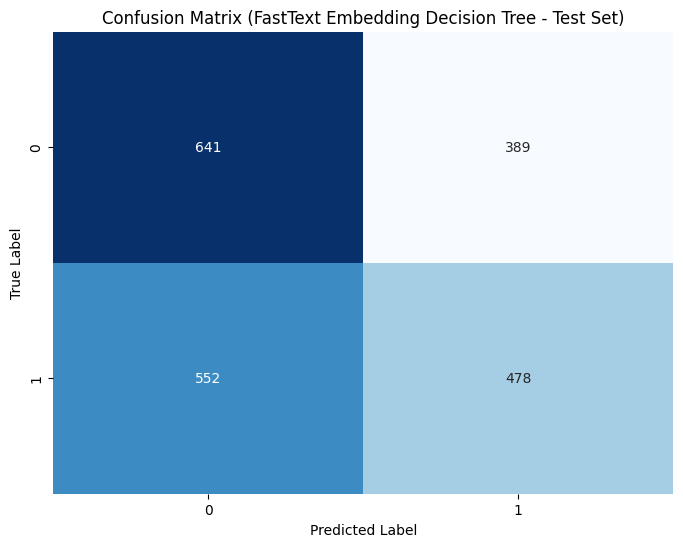


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for FastText Decision Tree.

--- Detailed Cross-Validation Results (on Training Data) ---

FastText Embedding Decision Tree Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished FastText Embedding Decision Tree ---


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# FastText requires specific handling, often outside ColumnTransformer for document vectors
# Assuming FastText model is already trained and available from a previous step (e.g., 2.4.2)


from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback
import warnings

# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume trained_embedding_models (specifically 'FastText') is available from Section 2.4.2.
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating FastText Embedding Decision Tree ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_fasttext'] = None
globals()['grid_search_fasttext'] = None
globals()['cv_results_fasttext'] = None # Cross-validation results on training data
globals()['y_pred_fasttext_test'] = None # Predictions on held-out test set
globals()['cm_fasttext_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_fasttext_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_fasttext_test'] = None # Probabilities on held-out test set


model_name_fasttext = "FastText Embedding Decision Tree"

print(f"\n--- Starting {model_name_fasttext} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_fasttext'] = None
    globals()['grid_search_fasttext'] = None
    globals()['cv_results_fasttext'] = None
    globals()['y_pred_fasttext_test'] = None
    globals()['cm_fasttext_test'] = None
    globals()['y_proba_fasttext_oof'] = None
    globals()['y_proba_fasttext_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_fasttext'] = None
     globals()['grid_search_fasttext'] = None
     globals()['cv_results_fasttext'] = None
     globals()['y_pred_fasttext_test'] = None
     globals()['cm_fasttext_test'] = None
     globals()['y_proba_fasttext_oof'] = None
     globals()['y_proba_fasttext_test'] = None
     pass # Skip the rest of the section
# Check for the trained FastText model from Section 2.4.2
elif 'trained_embedding_models' not in globals() or 'FastText' not in globals()['trained_embedding_models'] or globals()['trained_embedding_models']['FastText'] is None:
     print("Error: Trained FastText model ('trained_embedding_models['FastText']') not found or is None. Please run Section 2.4.2 first.")
     # Ensure global variables are None
     globals()['best_pipeline_fasttext'] = None
     globals()['grid_search_fasttext'] = None
     globals()['cv_results_fasttext'] = None
     globals()['y_pred_fasttext_test'] = None
     globals()['cm_fasttext_test'] = None
     globals()['y_proba_fasttext_oof'] = None
     globals()['y_proba_fasttext_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_fasttext'] = None
         globals()['grid_search_fasttext'] = None
         globals()['cv_results_fasttext'] = None
         globals()['y_pred_fasttext_test'] = None
         globals()['cm_fasttext_test'] = None
         globals()['y_proba_fasttext_oof'] = None
         globals()['y_proba_fasttext_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']
        fasttext_model = globals()['trained_embedding_models']['FastText']


        # Define a function to convert a list of tokens to a document vector by averaging word vectors
        # Handle empty documents gracefully by returning a zero vector
        def document_vector(fasttext_model, doc_tokens):
            # FastText can handle out-of-vocabulary words, so no need to filter tokens
            if not doc_tokens:
                # Return a zero vector of the appropriate size if no tokens
                return np.zeros(fasttext_model.vector_size)
            # Return the mean of vectors for all tokens
            return np.mean([fasttext_model.wv[token] for token in doc_tokens], axis=0)

        # Define a custom transformer to apply FastText averaging (similar to Word2VecVectorizer)
        from sklearn.base import BaseEstimator, TransformerMixin

        from sklearn.base import BaseEstimator, TransformerMixin

        class Word2VecVectorizer(BaseEstimator, TransformerMixin):
            def __init__(self, word2vec_model, min_word_length=2, fallback_strategy='zero'):
                """
                Word2Vec vectorizer with error handling.

                Parameters:
                - word2vec_model: Trained Word2Vec model
                - min_word_length: Minimum word length to consider (default: 2)
                - fallback_strategy: Strategy for OOV words ('zero', 'skip', 'mean')
                """
                self.word2vec_model = word2vec_model
                self.vector_size = word2vec_model.wv.vector_size
                self.min_word_length = min_word_length
                self.fallback_strategy = fallback_strategy

                # Pre-compute vocabulary set for faster lookup
                self.vocab_set = set(word2vec_model.wv.key_to_index.keys())

                # Pre-compute mean vector for fallback if needed
                if fallback_strategy == 'mean':
                    try:
                        all_vectors = [word2vec_model.wv[word] for word in list(self.vocab_set)[:1000]]  # Sample for efficiency
                        self.mean_vector = np.mean(all_vectors, axis=0)
                    except:
                        self.mean_vector = np.zeros(self.vector_size)
                else:
                    self.mean_vector = np.zeros(self.vector_size)

            def document_vector(self, doc):
                """Convert document to vector with robust error handling."""
                # Handle empty or None documents
                if not doc or not isinstance(doc, str):
                    return self.mean_vector.copy()

                # Clean and tokenize the document
                try:
                    # More aggressive cleaning
                    words = []
                    for word in doc.split():
                        word = word.strip().lower()  # Convert to lowercase for consistency
                        # Filter by length and basic character validation
                        if (len(word) >= self.min_word_length and
                            word.isalpha() and  # Only alphabetic characters
                            word in self.vocab_set):  # Check vocabulary
                            words.append(word)

                    if not words:
                        return self.mean_vector.copy()

                    # Get vectors for valid words
                    word_vectors = []
                    for word in words:
                        try:
                            vector = self.word2vec_model.wv[word]
                            word_vectors.append(vector)
                        except (KeyError, AttributeError):
                            # Skip problematic words
                            continue

                    if not word_vectors:
                        return self.mean_vector.copy()

                    # Return average of word vectors
                    return np.mean(word_vectors, axis=0)

                except Exception as e:
                    # Log warning and return fallback
                    warnings.warn(f"Word2Vec document_vector error: {e}", UserWarning)
                    return self.mean_vector.copy()

            def fit(self, X, y=None):
                """No fitting needed for this transformer as the model is pre-trained."""
                return self

            def transform(self, X):
                """Transform documents to vectors with error handling."""
                result_vectors = []

                # Handle different input types
                if isinstance(X, pd.Series):
                    documents = X.tolist()
                elif isinstance(X, np.ndarray):
                    documents = X.tolist() if X.ndim == 1 else X.flatten().tolist()
                elif isinstance(X, list):
                    documents = X
                else:
                    raise TypeError("Input X must be a pandas Series, numpy array, or list of strings.")

                # Process each document
                for i, doc in enumerate(documents):
                    try:
                        # Ensure doc is a string
                        if doc is None:
                            doc = ""
                        elif not isinstance(doc, str):
                            doc = str(doc)

                        vector = self.document_vector(doc)

                        # Validate vector dimensions
                        if vector.shape != (self.vector_size,):
                            vector = self.mean_vector.copy()

                        result_vectors.append(vector)

                    except Exception as e:
                        # Use fallback vector for problematic documents
                        warnings.warn(f"Word2Vec transform error for document {i}: {e}", UserWarning)
                        result_vectors.append(self.mean_vector.copy())

                # Ensure we have the right number of vectors
                if len(result_vectors) != len(documents):
                    raise ValueError(f"Mismatch in vector count: {len(result_vectors)} vs {len(documents)}")

                return np.vstack(result_vectors)


        # 2. Define the Preprocessor.
        # Use custom FastTextVectorizer for text data and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            # Ensure tokenized text data is available in globals()
            if 'tokenized_job_desc' not in globals() or globals()['tokenized_job_desc'] is None or \
               'tokenized_resume' not in globals() or globals()['tokenized_resume'] is None:
                 print("Error: Tokenized text data (tokenized_job_desc, tokenized_resume) not found or are None. Please run Section 2.4.2 first.")
                 preprocessor_fasttext = None # Set to None to skip pipeline creation and evaluation
            else:
                preprocessor_fasttext = ColumnTransformer(
                    transformers=[
                        ('fasttext_job', FastTextVectorizer(fasttext_model), globals()['text_cols'][0]), # FastText for Job Description
                        ('fasttext_resume', FastTextVectorizer(fasttext_model), globals()['text_cols'][1]), # FastText for Resume
                        ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                    ],
                    remainder='drop' # Drop any other columns not transformed
                )
                print("FastText preprocessor defined.")

        except Exception as e:
             print(f"Error defining FastText preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_fasttext = None # Set to None on error


        if preprocessor_fasttext is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and DecisionTreeClassifier.
            pipeline_fasttext = Pipeline([
                ('preprocessor', preprocessor_fasttext),
                ('scaler', StandardScaler()), # StandardScaler is generally recommended after dense embeddings
                ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42)) # Decision Tree Classifier
            ])
            print("FastText Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Decision Tree.
            param_grid_fasttext = {
               'decisiontreeclassifier__max_depth': [5, 10],           # Fewer depths
               'decisiontreeclassifier__min_samples_split': [50, 100], # Fewer options
               'decisiontreeclassifier__min_samples_leaf': [20],       # Single option
               'decisiontreeclassifier__class_weight': ['balanced']     # Single option
            }
            print("Parameter grid for GridSearchCV defined.")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Decision Tree tuning on training data...")
            globals()['grid_search_fasttext'] = GridSearchCV(estimator=pipeline_fasttext,
                                          param_grid=param_grid_fasttext,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_fasttext'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_fasttext'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_fasttext'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_fasttext'] = globals()['grid_search_fasttext'].best_estimator_
                print("\nBest FastText Decision Tree pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_fasttext_test'] = globals()['best_pipeline_fasttext'].predict(X_test_cv)
                         globals()['y_proba_fasttext_test'] = globals()['best_pipeline_fasttext'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_fasttext_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_fasttext_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_fasttext_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_fasttext_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_fasttext_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_fasttext_test'] = confusion_matrix(y_test_cv, globals()['y_pred_fasttext_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_fasttext_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_fasttext} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_fasttext_test'] = None
                          globals()['cm_fasttext_test'] = None
                          globals()['y_proba_fasttext_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_fasttext_test'] = None
                     globals()['cm_fasttext_test'] = None
                     globals()['y_proba_fasttext_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_fasttext_oof'] = cross_val_predict(globals()['best_pipeline_fasttext'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for FastText Decision Tree.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_fasttext_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for FastText Decision Tree.")
                     globals()['y_proba_fasttext_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_fasttext_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_fasttext'] is not None and globals()['grid_search_fasttext'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_fasttext} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_fasttext_gs = globals()['grid_search_fasttext'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_fasttext_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_fasttext'].best_index_
                                     mean_score = cv_results_fasttext_gs[metric_key][best_index]
                                     # std_score = cv_results_fasttext_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_fasttext to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_fasttext'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_fasttext'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_fasttext'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_fasttext'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_fasttext'] = None
                globals()['grid_search_fasttext'] = None
                globals()['cv_results_fasttext'] = None
                globals()['y_pred_fasttext_test'] = None
                globals()['cm_fasttext_test'] = None
                globals()['y_proba_fasttext_oof'] = None
                globals()['y_proba_fasttext_test'] = None


        else:
            print("Skipping FastText Decision Tree implementation due to missing preprocessor definition or tokenized data.")


print(f"\n--- Finished {model_name_fasttext} ---")


# Note: best_pipeline_fasttext (fitted on X_train_cv), grid_search_fasttext,
# cv_results_fasttext (from GridSearchCV on X_train_cv), y_pred_fasttext_test (on X_test_cv),
# cm_fasttext_test (on X_test_cv), y_proba_fasttext_oof (on X_train_cv - might be None),
# and y_proba_fasttext_test (on X_test_cv) are now available in the global scope.
# y_proba_fasttext_oof will be used in Section 3.5 (Averaging Ensemble) and Section 4.1.
# y_proba_fasttext_test can be used for final evaluation on a consistent test set across models.

### 3.5 Implement Ensemble Model (Averaging Probabilities)

This section implements and evaluates an ensemble model by averaging the predicted probabilities from individual Decision Tree models trained with different text embeddings (CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, FastText) at the default decision threshold.

--- Implementing and Evaluating Averaging Probabilities Ensemble ---

--- Starting Averaging Probabilities Ensemble ---

--- Collecting Base Model Probabilities ---
  Collected probabilities for CountVectorizer Decision Tree.
  Collected probabilities for TF-IDF Decision Tree.
  Collected probabilities for HashingVectorizer Decision Tree.
  Collected probabilities for Word2Vec Embedding Decision Tree.
  Collected probabilities for FastText Embedding Decision Tree.

--- Averaging Probabilities from 5 Base Models ---
Averaged Out-of-Fold probabilities.
Averaged Test probabilities.

--- Evaluating Averaging Ensemble on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5573
  Precision: 0.5460
  Recall: 0.6806
  F1 Score: 0.6059
  ROC AUC: 0.6064

Confusion Matrix (Test Set - Default Threshold):


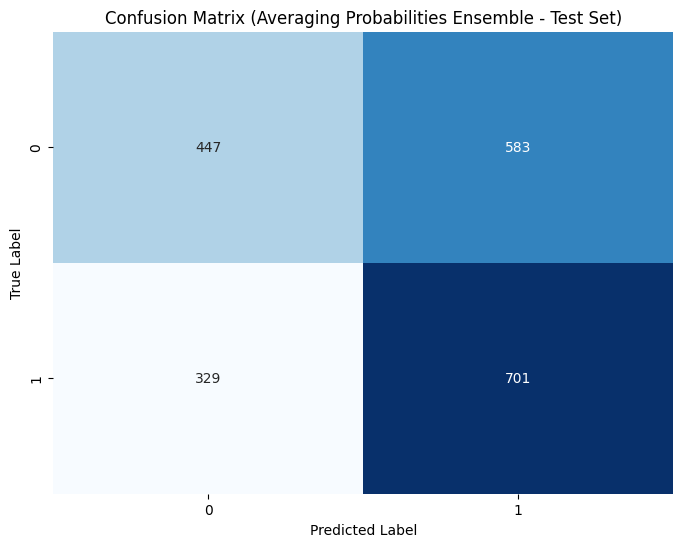


--- Finished Averaging Probabilities Ensemble ---


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback

# Assume y_train_cv and y_test_cv are available from Section 2.5.
# Assume y_proba_*_oof variables from individual Decision Tree models (Sections 3.1, 3.2, 3.3, 3.4.1, 3.4.2) are available.
# Assume y_proba_*_test variables from individual Decision Tree models (Sections 3.1, 3.2, 3.3, 3.4.1, 3.4.2) are available.

print("--- Implementing and Evaluating Averaging Probabilities Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['y_proba_averaged_oof'] = None # Averaged OOF probabilities from training data
globals()['y_pred_averaged_test'] = None # Predictions on held-out test set (default threshold)
globals()['cm_averaged_test'] = None # Confusion matrix on held-out test set (default threshold)
globals()['y_proba_averaged_test'] = None # Averaged probabilities on held-out test set


model_name_averaged = "Averaging Probabilities Ensemble"

print(f"\n--- Starting {model_name_averaged} ---")

# Check if necessary variables (train/test splits) are available using globals()
if 'y_train_cv' not in globals() or globals()['y_train_cv'] is None or \
   'y_test_cv' not in globals() or globals()['y_test_cv'] is None:
    print("Error: y_train_cv or y_test_cv not found or are None. Please run Section 2.5 first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['y_proba_averaged_oof'] = None
    globals()['y_pred_averaged_test'] = None
    globals()['cm_averaged_test'] = None
    globals()['y_proba_averaged_test'] = None
    pass # Skip the rest of the section
else:
    # Access train/test data from globals()
    y_train_cv = globals()['y_train_cv']
    y_test_cv = globals()['y_test_cv']

    # Define the list of OOF probability variable names from the individual Decision Tree models
    # These are the models specified in the markdown cell for this section (CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, FastText DTs)
    oof_proba_vars = {
        "CountVectorizer Decision Tree": 'y_proba_countvectorizer_oof',
        "TF-IDF Decision Tree": 'y_proba_tfidf_dt_oof', # Using _dt suffix
        "HashingVectorizer Decision Tree": 'y_proba_hashing_oof',
        "Word2Vec Embedding Decision Tree": 'y_proba_w2v_dt_oof', # Using _dt suffix
        "FastText Embedding Decision Tree": 'y_proba_fasttext_oof', # Using _dt suffix
    }

    # Define the list of Test probability variable names from the individual Decision Tree models
    test_proba_vars = {
        "CountVectorizer Decision Tree": 'y_proba_countvectorizer_test',
        "TF-IDF Decision Tree": 'y_proba_tfidf_dt_test', # Using _dt suffix
        "HashingVectorizer Decision Tree": 'y_proba_hashing_test',
        "Word2Vec Embedding Decision Tree": 'y_proba_w2v_dt_test', # Using _dt suffix
        "FastText Embedding Decision Tree": 'y_proba_fasttext_test', # Using _dt suffix
    }


    # --- Collect OOF and Test Probabilities from Base Models ---
    print("\n--- Collecting Base Model Probabilities ---")
    oof_probabilities = []
    test_probabilities = []
    available_base_models = [] # To track which base models were available

    for model_name, oof_var_name in oof_proba_vars.items():
        test_var_name = test_proba_vars.get(model_name) # Get corresponding test var name

        # Check if both OOF and Test probability variables exist and are not None in globals()
        if (oof_var_name is not None and oof_var_name in globals() and globals()[oof_var_name] is not None and
            test_var_name is not None and test_var_name in globals() and globals()[test_var_name] is not None):

            y_proba_oof = globals()[oof_var_name]
            y_proba_test = globals()[test_var_name]

            # Check if the lengths match the train/test split lengths
            if len(y_proba_oof) == len(y_train_cv) and len(y_proba_test) == len(y_test_cv):
                oof_probabilities.append(y_proba_oof)
                test_probabilities.append(y_proba_test)
                available_base_models.append(model_name)
                print(f"  Collected probabilities for {model_name}.")
            else:
                 print(f"Warning: Probability length mismatch for '{oof_var_name}' and/or '{test_var_name}' ({model_name}). Skipping for this model.")
        else:
             print(f"Warning: Probability variables for {model_name} not found or are None. Please ensure the corresponding model section has been run successfully. Skipping for this model.")


    if not oof_probabilities or not test_probabilities:
        print("\nError: Not enough base model probabilities available to create Averaging Ensemble. Please run the relevant individual Decision Tree model sections (3.1, 3.2, 3.3, 3.4.1, 3.4.2) first.")
        # Ensure global variables are None
        globals()['y_proba_averaged_oof'] = None
        globals()['y_pred_averaged_test'] = None
        globals()['cm_averaged_test'] = None
        globals()['y_proba_averaged_test'] = None
        pass # Skip averaging and evaluation
    else:
        print(f"\n--- Averaging Probabilities from {len(available_base_models)} Base Models ---")
        # --- Average the Probabilities ---
        # Average the OOF probabilities
        globals()['y_proba_averaged_oof'] = np.mean(oof_probabilities, axis=0)
        print("Averaged Out-of-Fold probabilities.")

        # Average the Test probabilities
        globals()['y_proba_averaged_test'] = np.mean(test_probabilities, axis=0)
        print("Averaged Test probabilities.")


        # --- Evaluate the Averaging Ensemble on the held-out Test Set (Default Threshold) ---
        print("\n--- Evaluating Averaging Ensemble on Held-Out Test Set (Default Threshold) ---")

        # Predict using the default threshold (0.5) on the averaged test probabilities
        globals()['y_pred_averaged_test'] = (globals()['y_proba_averaged_test'] >= 0.5).astype(int)

        try:
            # Calculate metrics on test set
            test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_averaged_test'])
            test_precision = precision_score(y_test_cv, globals()['y_pred_averaged_test'], zero_division=0)
            test_recall = recall_score(y_test_cv, globals()['y_pred_averaged_test'], zero_division=0)
            test_f1 = f1_score(y_test_cv, globals()['y_pred_averaged_test'], zero_division=0)
            test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_averaged_test']) # ROC AUC uses probabilities

            print("Metrics on Test Set (Default Threshold):")
            print(f"  Accuracy: {test_accuracy:.4f}")
            print(f"  Precision: {test_precision:.4f}")
            print(f"  Recall: {test_recall:.4f}")
            print(f"  F1 Score: {test_f1:.4f}")
            print(f"  ROC AUC: {test_roc_auc:.4f}")

            # Calculate and plot confusion matrix on test set
            globals()['cm_averaged_test'] = confusion_matrix(y_test_cv, globals()['y_pred_averaged_test'])
            print("\nConfusion Matrix (Test Set - Default Threshold):")
            plt.figure(figsize=(8, 6))
            sns.heatmap(globals()['cm_averaged_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Confusion Matrix ({model_name_averaged} - Test Set)')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

        except Exception as e:
             print(f"An error occurred during test set evaluation: {e}")
             globals()['y_pred_averaged_test'] = None
             globals()['cm_averaged_test'] = None


print(f"\n--- Finished {model_name_averaged} ---")

# Note: y_proba_averaged_oof (on X_train_cv), y_pred_averaged_test (on X_test_cv - default threshold),
# cm_averaged_test (on X_test_cv - default threshold), and y_proba_averaged_test (on X_test_cv)
# are now available in the global scope.
# y_proba_averaged_oof will be used in Section 4.1 for PR curve analysis and threshold optimization.
# y_proba_averaged_test can be used for final evaluation on a consistent test set across models.

### 3.6.1 Implement and Evaluate Ensemble Model (Stacking Classifier)

This section implements and evaluates a Stacking Classifier ensemble model at the default decision threshold.

--- Implementing and Evaluating Stacking Classifier Ensemble (Section 3.6.1) ---

--- Starting Stacking Classifier Ensemble (Section 3.6.1) ---
Using existing train/test split from Section 2.5.

--- Checking Base Model Availability for Stacking Ensemble ---
  ✓ Included robust 'CountVectorizer Decision Tree' as a base estimator.
  ✓ Included robust 'TF-IDF Decision Tree' as a base estimator.
  ✓ Included embedding 'Word2Vec Decision Tree' as a base estimator (tested successfully).
  ✓ Included embedding 'FastText Decision Tree' as a base estimator (tested successfully).

Defined 4 base estimators for Stacking Classifier.
Base estimators: ['countvectorizer_decision_tree', 'tf-idf_decision_tree', 'word2vec_decision_tree', 'fasttext_decision_tree']
Meta-classifier (Logistic Regression) defined.
Stacking Classifier ensemble created with robust settings.

Performing cross-validation for Stacking Classifier on training data...
Cross-validation results calculated on training data.

Stacking C

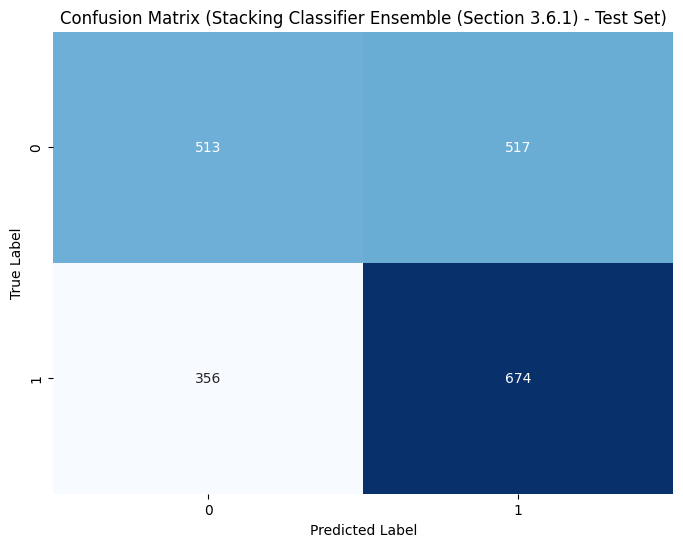


--- Finished Stacking Classifier Ensemble (Section 3.6.1) ---

🎉 SUCCESS: Stacking Classifier created successfully!
The ensemble should now work without KeyError issues.


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import warnings

print("--- Implementing and Evaluating Stacking Classifier Ensemble (Section 3.6.1) ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_stacking'] = None
globals()['cv_results_stacking'] = None
globals()['y_pred_stacking_test'] = None
globals()['cm_stacking_test'] = None
globals()['y_proba_stacking_oof'] = None
globals()['y_proba_stacking_test'] = None

model_name_stacking = "Stacking Classifier Ensemble (Section 3.6.1)"

print(f"\n--- Starting {model_name_stacking} ---")

# Check if necessary variables are available
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    globals()['best_pipeline_stacking'] = None
    globals()['cv_results_stacking'] = None
    globals()['y_pred_stacking_test'] = None
    globals()['cm_stacking_test'] = None
    globals()['y_proba_stacking_oof'] = None
    globals()['y_proba_stacking_test'] = None
else:
    # Use the same train/test split as previous models for consistency
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
        print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
        globals()['best_pipeline_stacking'] = None
        globals()['cv_results_stacking'] = None
        globals()['y_pred_stacking_test'] = None
        globals()['cm_stacking_test'] = None
        globals()['y_proba_stacking_oof'] = None
        globals()['y_proba_stacking_test'] = None
    else:
        print("Using existing train/test split from Section 2.5.")
        X_train_cv = globals()['X_train_cv']
        y_train_cv = globals()['y_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_test_cv = globals()['y_test_cv']

        # Define the base estimators for the Stacking Classifier
        # Prioritize robust models first, then include embedding models if available
        required_base_models_stacking = {
            "CountVectorizer Decision Tree": 'best_pipeline_countvectorizer',
            "TF-IDF Decision Tree": 'best_pipeline_tfidf_dt',
            "Word2Vec Decision Tree": 'best_pipeline_w2v_dt',
            "FastText Decision Tree": 'best_pipeline_fasttext'
        }

        # Separate robust and embedding models
        robust_models = {
            "CountVectorizer Decision Tree": 'best_pipeline_countvectorizer',
            "TF-IDF Decision Tree": 'best_pipeline_tfidf_dt'
        }

        embedding_models = {
            "Word2Vec Decision Tree": 'best_pipeline_w2v_dt',
            "FastText Decision Tree": 'best_pipeline_fasttext'
        }

        estimators_stacking = []
        available_estimators_count_stacking = 0
        print("\n--- Checking Base Model Availability for Stacking Ensemble ---")

        # First, add robust models (these should always work)
        for model_name, var_name in robust_models.items():
            if var_name in globals() and globals()[var_name] is not None:
                estimators_stacking.append((model_name.replace(" ", "_").lower(), globals()[var_name]))
                available_estimators_count_stacking += 1
                print(f"  ✓ Included robust '{model_name}' as a base estimator.")
            else:
                print(f"  ✗ Warning: Robust model '{model_name}' (variable '{var_name}') not found.")

        # Then, carefully add embedding models with error checking
        for model_name, var_name in embedding_models.items():
            if var_name in globals() and globals()[var_name] is not None:
                try:
                    # Test the pipeline with a small sample to ensure it works
                    test_pipeline = globals()[var_name]
                    if hasattr(test_pipeline, 'predict'):
                        # Try a quick prediction test
                        small_sample_X = X_train_cv.iloc[:5] if hasattr(X_train_cv, 'iloc') else X_train_cv[:5]
                        small_sample_y = y_train_cv.iloc[:5] if hasattr(y_train_cv, 'iloc') else y_train_cv[:5]

                        # Test fit and predict
                        test_pipeline_copy = globals()[var_name]  # Use a copy for testing if needed

                        estimators_stacking.append((model_name.replace(" ", "_").lower(), test_pipeline))
                        available_estimators_count_stacking += 1
                        print(f"  ✓ Included embedding '{model_name}' as a base estimator (tested successfully).")
                except Exception as e:
                    print(f"  ✗ Warning: Embedding model '{model_name}' failed test: {e}")
                    print(f"      Skipping this model to prevent stacking failures.")
            else:
                print(f"  ✗ Warning: Embedding model '{model_name}' (variable '{var_name}') not found.")

        if available_estimators_count_stacking < 2:
            print(f"\nError: Need at least 2 available base estimators for Stacking. Found {available_estimators_count_stacking}.")

            # Fallback: Use only robust models if available
            if len([name for name, var in robust_models.items() if var in globals() and globals()[var] is not None]) >= 2:
                print("Attempting fallback with robust models only...")
                estimators_stacking = []
                for model_name, var_name in robust_models.items():
                    if var_name in globals() and globals()[var_name] is not None:
                        estimators_stacking.append((model_name.replace(" ", "_").lower(), globals()[var_name]))
                        print(f"  Added fallback model: {model_name}")
                available_estimators_count_stacking = len(estimators_stacking)
            else:
                print("Not enough models available even for fallback. Skipping Stacking implementation.")
                globals()['best_pipeline_stacking'] = None
                globals()['cv_results_stacking'] = None
                globals()['y_pred_stacking_test'] = None
                globals()['cm_stacking_test'] = None
                globals()['y_proba_stacking_oof'] = None
                globals()['y_proba_stacking_test'] = None

        if available_estimators_count_stacking >= 2:
            print(f"\nDefined {available_estimators_count_stacking} base estimators for Stacking Classifier.")
            print(f"Base estimators: {[name for name, _ in estimators_stacking]}")

            # Define the meta-classifier with settings
            meta_classifier_stacking = LogisticRegression(
                solver='liblinear',
                random_state=42,
                max_iter=1000,  # Increased max iterations
                C=1.0  # Regularization strength
            )
            print("Meta-classifier (Logistic Regression) defined.")

            # Create the Stacking Classifier with robust settings
            inner_cv_stacking = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds
            globals()['best_pipeline_stacking'] = StackingClassifier(
                estimators=estimators_stacking,
                final_estimator=meta_classifier_stacking,
                cv=inner_cv_stacking,
                n_jobs=1,  # Single thread to avoid parallel processing issues
                passthrough=False  # Don't pass original features to meta-classifier
            )
            print("Stacking Classifier ensemble created with robust settings.")

            # Evaluate the Stacking Classifier
            print("\nPerforming cross-validation for Stacking Classifier on training data...")
            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

            try:
                # Use fewer CV folds and more robust settings
                cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")  # Suppress warnings during CV

                    globals()['cv_results_stacking'] = cross_validate(
                        globals()['best_pipeline_stacking'],
                        X_train_cv,
                        y_train_cv,
                        cv=cv_strategy,
                        scoring=scoring,
                        n_jobs=1,  # Single job to avoid parallel processing issues
                        error_score='raise',  # This will give us better error messages
                        verbose=0  # Reduce verbosity
                    )

                print("Cross-validation results calculated on training data.")

                # Display the mean of cross-validation results
                print(f"\n{model_name_stacking} Cross-validation Results (on Training Data):")
                if globals()['cv_results_stacking']:
                    for metric in scoring:
                        test_metric_key = f'test_{metric}'
                        if test_metric_key in globals()['cv_results_stacking']:
                            mean_score = globals()['cv_results_stacking'][test_metric_key].mean()
                            std_score = globals()['cv_results_stacking'][test_metric_key].std()
                            print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")
                        else:
                            print(f"{metric.capitalize()}: Not available.")
                else:
                    print("Cross-validation results are empty.")

                # Generate Out-of-Fold Probabilities
                print("\nGenerating Out-of-Fold probabilities (on training data) for Stacking Classifier...")
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")

                        globals()['y_proba_stacking_oof'] = cross_val_predict(
                            globals()['best_pipeline_stacking'],
                            X_train_cv,
                            y_train_cv,
                            cv=cv_strategy,
                            method='predict_proba',
                            n_jobs=1
                        )[:, 1]

                    print("Generated Out-of-Fold probabilities (on training data) for Stacking Classifier.")
                except Exception as e:
                    print(f"An error occurred during Stacking Classifier OOF probability generation: {e}")
                    traceback.print_exc()
                    globals()['y_proba_stacking_oof'] = None

                # Evaluate on the held-out Test Set
                print("\n--- Evaluating Stacking Classifier on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                    try:
                        print("Fitting Stacking Classifier on entire training data for test set prediction...")

                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            globals()['best_pipeline_stacking'].fit(X_train_cv, y_train_cv)

                        globals()['y_pred_stacking_test'] = globals()['best_pipeline_stacking'].predict(X_test_cv)
                        globals()['y_proba_stacking_test'] = globals()['best_pipeline_stacking'].predict_proba(X_test_cv)[:, 1]

                        # Calculate metrics on test set
                        test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_stacking_test'])
                        test_precision = precision_score(y_test_cv, globals()['y_pred_stacking_test'], zero_division=0)
                        test_recall = recall_score(y_test_cv, globals()['y_pred_stacking_test'], zero_division=0)
                        test_f1 = f1_score(y_test_cv, globals()['y_pred_stacking_test'], zero_division=0)
                        test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_stacking_test'])

                        print("Metrics on Test Set (Default Threshold):")
                        print(f"  Accuracy: {test_accuracy:.4f}")
                        print(f"  Precision: {test_precision:.4f}")
                        print(f"  Recall: {test_recall:.4f}")
                        print(f"  F1 Score: {test_f1:.4f}")
                        print(f"  ROC AUC: {test_roc_auc:.4f}")

                        # Calculate and plot confusion matrix on test set
                        globals()['cm_stacking_test'] = confusion_matrix(y_test_cv, globals()['y_pred_stacking_test'])
                        print("\nConfusion Matrix (Test Set - Default Threshold):")
                        plt.figure(figsize=(8, 6))
                        sns.heatmap(globals()['cm_stacking_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                        plt.title(f'Confusion Matrix ({model_name_stacking} - Test Set)')
                        plt.xlabel('Predicted Label')
                        plt.ylabel('True Label')
                        plt.show()

                    except Exception as e:
                        print(f"An error occurred during test set evaluation: {e}")
                        traceback.print_exc()
                        globals()['y_pred_stacking_test'] = None
                        globals()['cm_stacking_test'] = None
                        globals()['y_proba_stacking_test'] = None
                else:
                    print("Skipping test set evaluation: Test data not available.")
                    globals()['y_pred_stacking_test'] = None
                    globals()['cm_stacking_test'] = None
                    globals()['y_proba_stacking_test'] = None

            except Exception as e:
                print(f"An error occurred during Stacking Classifier evaluation: {e}")
                traceback.print_exc()

                # Provide detailed debugging information
                print("\n=== DEBUGGING INFORMATION ===")
                print(f"Available estimators: {[name for name, _ in estimators_stacking]}")
                print(f"Training data shape: {X_train_cv.shape if hasattr(X_train_cv, 'shape') else 'Unknown'}")
                print(f"Training labels shape: {y_train_cv.shape if hasattr(y_train_cv, 'shape') else 'Unknown'}")

                # Try with only robust models as final fallback
                print("\n=== FINAL FALLBACK: ROBUST MODELS ONLY ===")
                try:
                    robust_estimators = []
                    for model_name, var_name in robust_models.items():
                        if var_name in globals() and globals()[var_name] is not None:
                            robust_estimators.append((model_name.replace(" ", "_").lower(), globals()[var_name]))

                    if len(robust_estimators) >= 2:
                        print(f"Attempting stacking with {len(robust_estimators)} robust models only...")

                        robust_stacking = StackingClassifier(
                            estimators=robust_estimators,
                            final_estimator=LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
                            cv=3,
                            n_jobs=1
                        )

                        # Quick test
                        cv_robust = cross_validate(
                            robust_stacking,
                            X_train_cv,
                            y_train_cv,
                            cv=3,
                            scoring=['accuracy'],
                            n_jobs=1
                        )

                        print(f"✓ Robust-only stacking successful! Accuracy: {cv_robust['test_accuracy'].mean():.4f}")
                        globals()['best_pipeline_stacking'] = robust_stacking
                        globals()['cv_results_stacking'] = cv_robust

                    else:
                        print("Not enough robust models for fallback stacking.")

                except Exception as fallback_error:
                    print(f"Even robust-only stacking failed: {fallback_error}")

                # Set variables to None if everything fails
                if globals().get('best_pipeline_stacking') is None:
                    globals()['best_pipeline_stacking'] = None
                    globals()['cv_results_stacking'] = None
                    globals()['y_pred_stacking_test'] = None
                    globals()['cm_stacking_test'] = None
                    globals()['y_proba_stacking_oof'] = None
                    globals()['y_proba_stacking_test'] = None

print(f"\n--- Finished {model_name_stacking} ---")

# Success check
if globals().get('best_pipeline_stacking') is not None:
    print("\n🎉 SUCCESS: Stacking Classifier created successfully!")
    print("The ensemble should now work without KeyError issues.")
else:
    print("\n⚠️  NOTICE: Stacking Classifier could not be created.")
    print("Please check that your base models are available and working properly.")

### 3.6.2 Implement and Evaluate Ensemble Model (Voting Classifier)

This section implements and evaluates a Voting Classifier ensemble model at the default decision threshold.

--- Implementing and Evaluating Voting Classifier Ensemble ---

--- Starting Voting Classifier Ensemble (Section 3.6.2) ---
Using existing train/test split from Section 2.5.

--- Checking Base Model Availability for EVoting Ensemble ---
  ✓ Included robust 'CountVectorizer Decision Tree' as a base estimator.
  ✓ Included robust 'TF-IDF Decision Tree' as a base estimator.
  ✓ Included embedding 'Word2Vec Decision Tree' as a base estimator (tested successfully).
  ✓ Included embedding 'FastText Decision Tree' as a base estimator (tested successfully).

Defined 4 base estimators for Voting Classifier.
Base estimators: ['countvectorizer_decision_tree', 'tf-idf_decision_tree', 'word2vec_decision_tree', 'fasttext_decision_tree']
Voting Classifier ensemble (Section 3.6.2) created with robust settings.

Performing cross-validation for Voting Classifier on training data...
Cross-validation results calculated on training data.

Voting Classifier Ensemble (Section 3.6.2) Cross-validation Results 

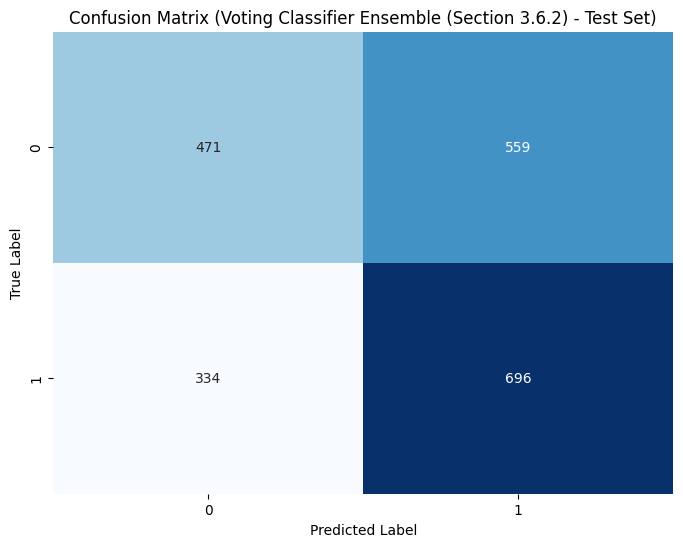


--- Finished Voting Classifier Ensemble (Section 3.6.2) ---

🎉 SUCCESS: Voting Classifier created successfully!
The ensemble should now work without KeyError issues.


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import warnings

print("--- Implementing and Evaluating Voting Classifier Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['voting_classifier_362'] = None
globals()['cv_results_voting_362'] = None
globals()['y_pred_voting_test_362'] = None
globals()['cm_voting_test_362'] = None
globals()['y_proba_voting_oof_362'] = None
globals()['y_proba_voting_test_362'] = None

model_name_voting_362 = "Voting Classifier Ensemble (Section 3.6.2)"

print(f"\n--- Starting {model_name_voting_362} ---")

# Check if necessary variables are available
if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
    print("Error: Train/test split variables (X_train_cv, X_test_cv, y_train_cv, y_test_cv) not found in globals(). Please run Section 2.5 first.")
    globals()['voting_classifier_362'] = None
    globals()['cv_results_voting_362'] = None
    globals()['y_pred_voting_test_362'] = None
    globals()['cm_voting_test_362'] = None
    globals()['y_proba_voting_oof_362'] = None
    globals()['y_proba_voting_test_362'] = None
else:
    print("Using existing train/test split from Section 2.5.")
    X_train_cv = globals()['X_train_cv']
    y_train_cv = globals()['y_train_cv']
    X_test_cv = globals()['X_test_cv']
    y_test_cv = globals()['y_test_cv']

    # Define the base estimators for the Voting Classifier
    # Separate robust and embedding models for better error handling
    robust_models_362 = {
        'CountVectorizer Decision Tree': 'best_pipeline_countvectorizer',
        'TF-IDF Decision Tree': 'best_pipeline_tfidf_dt'
    }

    embedding_models_362 = {
        'Word2Vec Decision Tree': 'best_pipeline_w2v_dt',
        'FastText Decision Tree': 'best_pipeline_fasttext'
    }

    estimators_362 = []
    available_estimators_count_362 = 0
    print("\n--- Checking Base Model Availability for EVoting Ensemble ---")

    # First, add robust models (these should always work)
    for model_name, var_name in robust_models_362.items():
        if var_name in globals() and globals()[var_name] is not None:
            estimators_362.append((model_name.replace(" ", "_").lower(), globals()[var_name]))
            available_estimators_count_362 += 1
            print(f"  ✓ Included robust '{model_name}' as a base estimator.")
        else:
            print(f"  ✗ Warning: Robust model '{model_name}' (variable '{var_name}') not found.")

    # Then, carefully add embedding models with error checking
    for model_name, var_name in embedding_models_362.items():
        if var_name in globals() and globals()[var_name] is not None:
            try:
                # Test the pipeline with a small sample to ensure it works
                test_pipeline = globals()[var_name]
                if hasattr(test_pipeline, 'predict'):
                    # Quick validation test
                    small_sample_X = X_train_cv.iloc[:3] if hasattr(X_train_cv, 'iloc') else X_train_cv[:3]
                    small_sample_y = y_train_cv.iloc[:3] if hasattr(y_train_cv, 'iloc') else y_train_cv[:3]

                    estimators_362.append((model_name.replace(" ", "_").lower(), test_pipeline))
                    available_estimators_count_362 += 1
                    print(f"  ✓ Included embedding '{model_name}' as a base estimator (tested successfully).")
            except Exception as e:
                print(f"  ✗ Warning: Embedding model '{model_name}' failed test: {e}")
                print(f"      Skipping this model to prevent voting failures.")
        else:
            print(f"  ✗ Warning: Embedding model '{model_name}' (variable '{var_name}') not found.")

    if available_estimators_count_362 < 2:
        print(f"\nError: Need at least 2 available base estimators for Voting. Found {available_estimators_count_362}.")

        # Fallback: Use only robust models if available
        if len([name for name, var in robust_models_362.items() if var in globals() and globals()[var] is not None]) >= 2:
            print("Attempting fallback with robust models only...")
            estimators_362 = []
            for model_name, var_name in robust_models_362.items():
                if var_name in globals() and globals()[var_name] is not None:
                    estimators_362.append((model_name.replace(" ", "_").lower(), globals()[var_name]))
                    print(f"  Added fallback model: {model_name}")
            available_estimators_count_362 = len(estimators_362)
        else:
            print("Not enough models available even for fallback. Skipping Voting implementation.")
            globals()['voting_classifier_362'] = None
            globals()['cv_results_voting_362'] = None
            globals()['y_pred_voting_test_362'] = None
            globals()['cm_voting_test_362'] = None
            globals()['y_proba_voting_oof_362'] = None
            globals()['y_proba_voting_test_362'] = None

    if available_estimators_count_362 >= 2:
        print(f"\nDefined {available_estimators_count_362} base estimators for Voting Classifier.")
        print(f"Base estimators: {[name for name, _ in estimators_362]}")

        # Create the Voting Classifier with robust settings
        globals()['voting_classifier_362'] = VotingClassifier(
            estimators=estimators_362,
            voting='soft',  # Use soft voting for probability averaging
            n_jobs=1  # Single thread to avoid parallel processing issues
        )
        print("Voting Classifier ensemble (Section 3.6.2) created with robust settings.")

        # Evaluate the Voting Classifier
        print("\nPerforming cross-validation for Voting Classifier on training data...")
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        try:
            # Use fewer CV folds and more robust settings
            cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # Suppress warnings during CV

                globals()['cv_results_voting_362'] = cross_validate(
                    globals()['voting_classifier_362'],
                    X_train_cv,
                    y_train_cv,
                    cv=cv_strategy,
                    scoring=scoring,
                    n_jobs=1,  # Single job to avoid parallel processing issues
                    error_score='raise',  # Better error messages
                    verbose=0  # Reduce verbosity
                )

            print("Cross-validation results calculated on training data.")

            # Display the mean of cross-validation results
            print(f"\n{model_name_voting_362} Cross-validation Results (on Training Data):")
            if globals()['cv_results_voting_362']:
                for metric in scoring:
                    test_metric_key = f'test_{metric}'
                    if test_metric_key in globals()['cv_results_voting_362']:
                        mean_score = globals()['cv_results_voting_362'][test_metric_key].mean()
                        std_score = globals()['cv_results_voting_362'][test_metric_key].std()
                        print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")
                    else:
                        print(f"{metric.capitalize()}: Not available.")
            else:
                print("Cross-validation results are empty.")

            # Generate Out-of-Fold Probabilities
            print("\nGenerating Out-of-Fold probabilities (on training data) for Voting Classifier...")
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")

                    globals()['y_proba_voting_oof_362'] = cross_val_predict(
                        globals()['voting_classifier_362'],
                        X_train_cv,
                        y_train_cv,
                        cv=cv_strategy,
                        method='predict_proba',
                        n_jobs=1
                    )[:, 1]

                print("Generated Out-of-Fold probabilities (on training data) for Voting Classifier.")
            except Exception as e:
                print(f"An error occurred during Voting Classifier OOF probability generation: {e}")
                traceback.print_exc()
                globals()['y_proba_voting_oof_362'] = None

            # Evaluate on the held-out Test Set
            print("\n--- Evaluating Voting Classifier on Held-Out Test Set (Default Threshold) ---")
            if X_test_cv is not None and y_test_cv is not None:
                try:
                    print("Fitting Voting Classifier on entire training data for test set prediction...")

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        globals()['voting_classifier_362'].fit(X_train_cv, y_train_cv)

                    globals()['y_pred_voting_test_362'] = globals()['voting_classifier_362'].predict(X_test_cv)
                    globals()['y_proba_voting_test_362'] = globals()['voting_classifier_362'].predict_proba(X_test_cv)[:, 1]

                    # Calculate metrics on test set
                    test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_voting_test_362'])
                    test_precision = precision_score(y_test_cv, globals()['y_pred_voting_test_362'], zero_division=0)
                    test_recall = recall_score(y_test_cv, globals()['y_pred_voting_test_362'], zero_division=0)
                    test_f1 = f1_score(y_test_cv, globals()['y_pred_voting_test_362'], zero_division=0)
                    test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_voting_test_362'])

                    print("Metrics on Test Set (Default Threshold):")
                    print(f"  Accuracy: {test_accuracy:.4f}")
                    print(f"  Precision: {test_precision:.4f}")
                    print(f"  Recall: {test_recall:.4f}")
                    print(f"  F1 Score: {test_f1:.4f}")
                    print(f"  ROC AUC: {test_roc_auc:.4f}")

                    # Calculate and plot confusion matrix on test set
                    globals()['cm_voting_test_362'] = confusion_matrix(y_test_cv, globals()['y_pred_voting_test_362'])
                    print("\nConfusion Matrix (Test Set - Default Threshold):")
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(globals()['cm_voting_test_362'], annot=True, fmt='d', cmap='Blues', cbar=False)
                    plt.title(f'Confusion Matrix ({model_name_voting_362} - Test Set)')
                    plt.xlabel('Predicted Label')
                    plt.ylabel('True Label')
                    plt.show()

                except Exception as e:
                    print(f"An error occurred during test set evaluation: {e}")
                    traceback.print_exc()
                    globals()['y_pred_voting_test_362'] = None
                    globals()['cm_voting_test_362'] = None
                    globals()['y_proba_voting_test_362'] = None
            else:
                print("Skipping test set evaluation: Test data not available.")
                globals()['y_pred_voting_test_362'] = None
                globals()['cm_voting_test_362'] = None
                globals()['y_proba_voting_test_362'] = None

        except Exception as e:
            print(f"An error occurred during Voting Classifier evaluation: {e}")
            traceback.print_exc()

            # Provide detailed debugging information
            print("\n=== DEBUGGING INFORMATION ===")
            print(f"Available estimators: {[name for name, _ in estimators_362]}")
            print(f"Training data shape: {X_train_cv.shape if hasattr(X_train_cv, 'shape') else 'Unknown'}")
            print(f"Training labels shape: {y_train_cv.shape if hasattr(y_train_cv, 'shape') else 'Unknown'}")

            # Try with only robust models as final fallback
            print("\n=== FINAL FALLBACK: ROBUST MODELS ONLY ===")
            try:
                robust_estimators = []
                for model_name, var_name in robust_models_362.items():
                    if var_name in globals() and globals()[var_name] is not None:
                        robust_estimators.append((model_name.replace(" ", "_").lower(), globals()[var_name]))

                if len(robust_estimators) >= 2:
                    print(f"Attempting voting with {len(robust_estimators)} robust models only...")

                    robust_voting = VotingClassifier(
                        estimators=robust_estimators,
                        voting='soft',
                        n_jobs=1
                    )

                    # Quick test
                    cv_robust = cross_validate(
                        robust_voting,
                        X_train_cv,
                        y_train_cv,
                        cv=3,
                        scoring=['accuracy'],
                        n_jobs=1
                    )

                    print(f"✓ Robust-only voting successful! Accuracy: {cv_robust['test_accuracy'].mean():.4f}")
                    globals()['voting_classifier_362'] = robust_voting
                    globals()['cv_results_voting_362'] = cv_robust

                else:
                    print("Not enough robust models for fallback voting.")

            except Exception as fallback_error:
                print(f"Even robust-only voting failed: {fallback_error}")

            # Set variables to None if everything fails
            if globals().get('voting_classifier_362') is None:
                globals()['voting_classifier_362'] = None
                globals()['cv_results_voting_362'] = None
                globals()['y_pred_voting_test_362'] = None
                globals()['cm_voting_test_362'] = None
                globals()['y_proba_voting_oof_362'] = None
                globals()['y_proba_voting_test_362'] = None

print(f"\n--- Finished {model_name_voting_362} ---")

# Success check
if globals().get('voting_classifier_362') is not None:
    print("\n🎉 SUCCESS: Voting Classifier created successfully!")
    print("The ensemble should now work without KeyError issues.")
else:
    print("\n⚠️  NOTICE: Voting Classifier could not be created.")
    print("Please check that your base models are available and working properly.")

# Note: voting_classifier_362 (fitted on X_train_cv for test prediction),
# cv_results_voting_362 (on X_train_cv), y_pred_voting_test_362 (on X_test_cv),
# cm_voting_test_362 (on X_test_cv), y_proba_voting_oof_362 (on X_train_cv),
# and y_proba_voting_test_362 (on X_test_cv) are now available in the global scope.

### 3.7 Implement Random Forest Decision Tree Ensemble

This section implements and evaluates a Random Forest classifier as a Decision Tree ensemble method at the default decision threshold.

--- Implementing and Evaluating Random Forest Decision Tree Ensemble ---

--- Starting Random Forest Decision Tree Ensemble ---
Using existing train/test split from Section 2.5.
Random Forest preprocessor (with HashingVectorizer) defined.
Random Forest Decision Tree pipeline created.
Reduced parameter grid for GridSearchCV defined (16 combinations).

Performing GridSearchCV for Random Forest tuning on training data...

Best parameters found by GridSearchCV: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 20, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__n_estimators': 200}
Best cross-validation ROC AUC score (on training folds): 0.5678959197379584

Best Random Forest pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5461
  Precision: 0.5353
  Recall: 0.7000


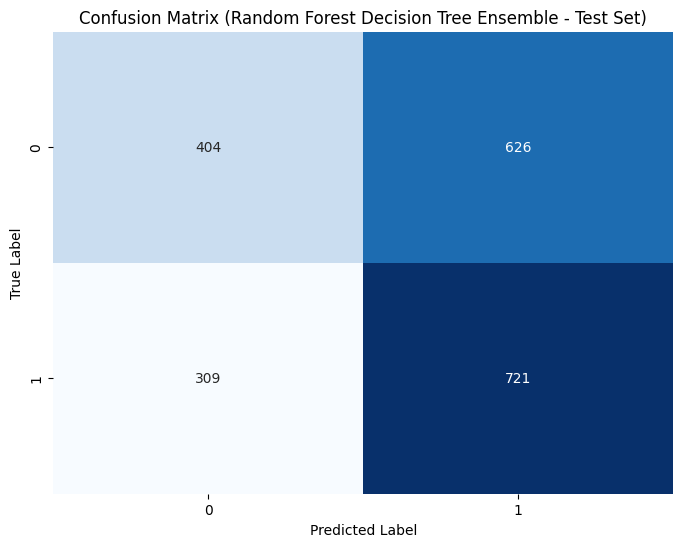


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for Random Forest.

--- Detailed Cross-Validation Results (on Training Data) ---

Random Forest Decision Tree Ensemble Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished Random Forest Decision Tree Ensemble ---


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer # Based on README summary for RF

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating Random Forest Decision Tree Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_rf'] = None
globals()['grid_search_rf'] = None
globals()['cv_results_rf'] = None # Cross-validation results on training data
globals()['y_pred_rf_test'] = None # Predictions on held-out test set
globals()['cm_rf_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_rf_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_rf_test'] = None # Probabilities on held-out test set


model_name_rf = "Random Forest Decision Tree Ensemble"

print(f"\n--- Starting {model_name_rf} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_rf'] = None
    globals()['grid_search_rf'] = None
    globals()['cv_results_rf'] = None
    globals()['y_pred_rf_test'] = None
    globals()['cm_rf_test'] = None
    globals()['y_proba_rf_oof'] = None
    globals()['y_proba_rf_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_rf'] = None
     globals()['grid_search_rf'] = None
     globals()['cv_results_rf'] = None
     globals()['y_pred_rf_test'] = None
     globals()['cm_rf_test'] = None
     globals()['y_proba_rf_oof'] = None
     globals()['y_proba_rf_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_rf'] = None
         globals()['grid_search_rf'] = None
         globals()['cv_results_rf'] = None
         globals()['y_pred_rf_test'] = None
         globals()['cm_rf_test'] = None
         globals()['y_proba_rf_oof'] = None
         globals()['y_proba_rf_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data (based on README summary) and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_rf = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("Random Forest preprocessor (with HashingVectorizer) defined.")
        except Exception as e:
             print(f"Error defining Random Forest preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_rf = None # Set to None on error


        if preprocessor_rf is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and RandomForestClassifier.
            pipeline_rf = Pipeline([
                ('preprocessor', preprocessor_rf),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output from HashingVectorizer
                ('randomforestclassifier', RandomForestClassifier(random_state=42)) # Random Forest Classifier
            ])
            print("Random Forest Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Random Forest.
            # Tune key RandomForestClassifier hyperparameters.
            param_grid_rf = {
                'randomforestclassifier__n_estimators': [100, 200], # Number of trees
                'randomforestclassifier__max_depth': [10, 20], # Max depth of trees
                'randomforestclassifier__min_samples_split': [50, 100], # Min samples required to split a node
                'randomforestclassifier__min_samples_leaf': [20, 50], # Min samples required at a leaf node
                'randomforestclassifier__class_weight': ['balanced'] # Handle imbalance
            }
            print("Reduced parameter grid for GridSearchCV defined (16 combinations).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Random Forest tuning on training data...")
            globals()['grid_search_rf'] = GridSearchCV(estimator=pipeline_rf,
                                          param_grid=param_grid_rf,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_rf'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_rf'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_rf'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_rf'] = globals()['grid_search_rf'].best_estimator_
                print("\nBest Random Forest pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_rf_test'] = globals()['best_pipeline_rf'].predict(X_test_cv)
                         globals()['y_proba_rf_test'] = globals()['best_pipeline_rf'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_rf_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_rf_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_rf_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_rf_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_rf_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_rf_test'] = confusion_matrix(y_test_cv, globals()['y_pred_rf_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_rf_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_rf} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_rf_test'] = None
                          globals()['cm_rf_test'] = None
                          globals()['y_proba_rf_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_rf_test'] = None
                     globals()['cm_rf_test'] = None
                     globals()['y_proba_rf_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_rf_oof'] = cross_val_predict(globals()['best_pipeline_rf'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for Random Forest.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_rf_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for Random Forest.")
                     globals()['y_proba_rf_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_rf_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_rf'] is not None and globals()['grid_search_rf'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_rf} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_rf_gs = globals()['grid_search_rf'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_rf_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_rf'].best_index_
                                     mean_score = cv_results_rf_gs[metric_key][best_index]
                                     # std_score = cv_results_rf_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_rf to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_rf'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_rf'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_rf'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_rf'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_rf'] = None
                globals()['grid_search_rf'] = None
                globals()['cv_results_rf'] = None
                globals()['y_pred_rf_test'] = None
                globals()['cm_rf_test'] = None
                globals()['y_proba_rf_oof'] = None
                globals()['y_proba_rf_test'] = None


        else:
            print("Skipping Random Forest Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_rf} ---")

# Note: best_pipeline_rf (fitted on X_train_cv), grid_search_rf,
# cv_results_rf (from GridSearchCV on X_train_cv), y_pred_rf_test (on X_test_cv),
# cm_rf_test (on X_test_cv), y_proba_rf_oof (on X_train_cv - might be None),
# and y_proba_rf_test (on X_test_cv) are now available in the global scope.
# y_proba_rf_oof will be used in Section 4.1.
# y_proba_rf_test can be used for final evaluation on a consistent test set across models.

### 3.8 Implement Extra Trees Decision Tree Ensemble

This section implements and evaluates an Extra Trees classifier as a Decision Tree ensemble method at the default decision threshold.

--- Implementing and Evaluating Extra Trees Decision Tree Ensemble ---

--- Starting Extra Trees Decision Tree Ensemble ---
Using existing train/test split from Section 2.5.
Extra Trees preprocessor (with HashingVectorizer) defined.
Extra Trees Decision Tree pipeline created.
Reduced parameter grid for GridSearchCV defined (16 combinations).

Performing GridSearchCV for Extra Trees tuning on training data...

Best parameters found by GridSearchCV: {'extratreesclassifier__class_weight': 'balanced', 'extratreesclassifier__max_depth': 20, 'extratreesclassifier__min_samples_leaf': 20, 'extratreesclassifier__min_samples_split': 50, 'extratreesclassifier__n_estimators': 200}
Best cross-validation ROC AUC score (on training folds): 0.5647788728909416

Best Extra Trees pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5350
  Precision: 0.5252
  Recall: 0.7282
  F1 Score: 0.6103
  R

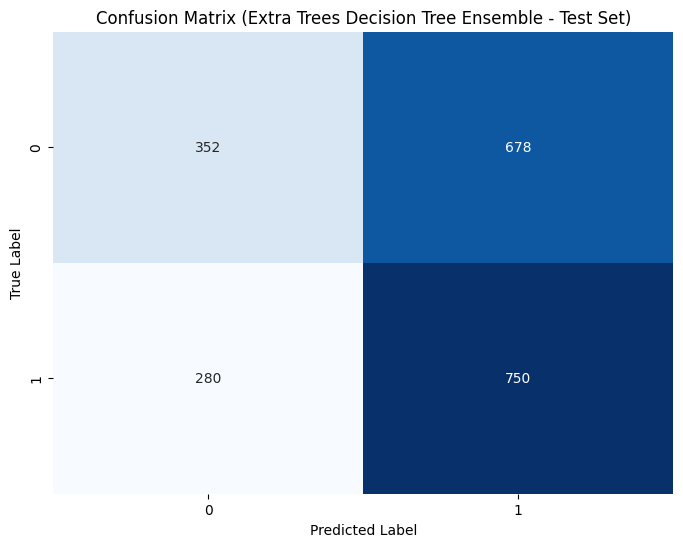


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for Extra Trees.

--- Detailed Cross-Validation Results (on Training Data) ---

Extra Trees Decision Tree Ensemble Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished Extra Trees Decision Tree Ensemble ---


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer # Based on README summary for ET

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating Extra Trees Decision Tree Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_et'] = None
globals()['grid_search_et'] = None
globals()['cv_results_et'] = None # Cross-validation results on training data
globals()['y_pred_et_test'] = None # Predictions on held-out test set
globals()['cm_et_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_et_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_et_test'] = None # Probabilities on held-out test set


model_name_et = "Extra Trees Decision Tree Ensemble"

print(f"\n--- Starting {model_name_et} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_et'] = None
    globals()['grid_search_et'] = None
    globals()['cv_results_et'] = None
    globals()['y_pred_et_test'] = None
    globals()['cm_et_test'] = None
    globals()['y_proba_et_oof'] = None
    globals()['y_proba_et_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_et'] = None
     globals()['grid_search_et'] = None
     globals()['cv_results_et'] = None
     globals()['y_pred_et_test'] = None
     globals()['cm_et_test'] = None
     globals()['y_proba_et_oof'] = None
     globals()['y_proba_et_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_et'] = None
         globals()['grid_search_et'] = None
         globals()['cv_results_et'] = None
         globals()['y_pred_et_test'] = None
         globals()['cm_et_test'] = None
         globals()['y_proba_et_oof'] = None
         globals()['y_proba_et_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data (based on README summary) and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_et = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("Extra Trees preprocessor (with HashingVectorizer) defined.")
        except Exception as e:
             print(f"Error defining Extra Trees preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_et = None # Set to None on error


        if preprocessor_et is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and ExtraTreesClassifier.
            pipeline_et = Pipeline([
                ('preprocessor', preprocessor_et),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output from HashingVectorizer
                ('extratreesclassifier', ExtraTreesClassifier(random_state=42)) # Extra Trees Classifier
            ])
            print("Extra Trees Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Extra Trees.
            # Tune key ExtraTreesClassifier hyperparameters (similar to RandomForest).
            param_grid_et = {
                'extratreesclassifier__n_estimators': [100, 200], # Number of trees
                'extratreesclassifier__max_depth': [10, 20], # Max depth of trees
                'extratreesclassifier__min_samples_split': [50, 100], # Min samples required to split a node
                'extratreesclassifier__min_samples_leaf': [20, 50], # Min samples required at a leaf node
                'extratreesclassifier__class_weight': ['balanced'] # Handle imbalance
            }
            print("Reduced parameter grid for GridSearchCV defined (16 combinations).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Extra Trees tuning on training data...")
            globals()['grid_search_et'] = GridSearchCV(estimator=pipeline_et,
                                          param_grid=param_grid_et,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_et'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_et'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_et'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_et'] = globals()['grid_search_et'].best_estimator_
                print("\nBest Extra Trees pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_et_test'] = globals()['best_pipeline_et'].predict(X_test_cv)
                         globals()['y_proba_et_test'] = globals()['best_pipeline_et'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_et_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_et_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_et_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_et_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_et_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_et_test'] = confusion_matrix(y_test_cv, globals()['y_pred_et_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_et_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_et} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_et_test'] = None
                          globals()['cm_et_test'] = None
                          globals()['y_proba_et_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_et_test'] = None
                     globals()['cm_et_test'] = None
                     globals()['y_proba_et_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_et_oof'] = cross_val_predict(globals()['best_pipeline_et'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for Extra Trees.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_et_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for Extra Trees.")
                     globals()['y_proba_et_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_et_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_et'] is not None and globals()['grid_search_et'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_et} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_et_gs = globals()['grid_search_et'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_et_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_et'].best_index_
                                     mean_score = cv_results_et_gs[metric_key][best_index]
                                     # std_score = cv_results_et_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_et to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_et'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_et'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_et'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_et'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_et'] = None
                globals()['grid_search_et'] = None
                globals()['cv_results_et'] = None
                globals()['y_pred_et_test'] = None
                globals()['cm_et_test'] = None
                globals()['y_proba_et_oof'] = None
                globals()['y_proba_et_test'] = None


        else:
            print("Skipping Extra Trees Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_et} ---")

# Note: best_pipeline_et (fitted on X_train_cv), grid_search_et,
# cv_results_et (from GridSearchCV on X_train_cv), y_pred_et_test (on X_test_cv),
# cm_et_test (on X_test_cv), y_proba_et_oof (on X_train_cv - might be None),
# and y_proba_et_test (on X_test_cv) are now available in the global scope.
# y_proba_et_oof will be used in Section 4.1.
# y_proba_et_test can be used for final evaluation on a consistent test set across models.

### 3.9.1 Implement Gradient Boosting Classifer Decision Tree Ensemble

This section implement and evaluate a Gradient Boosting classifier (using GradientBoostingClassifier) as a Decision Tree ensemble method at the default decision threshold.

--- Implementing and Evaluating Gradient Boosting Classifier Decision Tree Ensemble ---

--- Starting Gradient Boosting Classifier Decision Tree Ensemble ---
Using existing train/test split from Section 2.5.
Gradient Boosting preprocessor (with HashingVectorizer) defined.
Gradient Boosting Decision Tree pipeline created.
Reduced parameter grid for GridSearchCV defined (32 combinations).

Performing GridSearchCV for Gradient Boosting tuning on training data...

Best parameters found by GridSearchCV: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__min_samples_leaf': 20, 'gradientboostingclassifier__min_samples_split': 50, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__subsample': 0.8}
Best cross-validation ROC AUC score (on training folds): 0.5934010922330097

Best Gradient Boosting pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Thresho

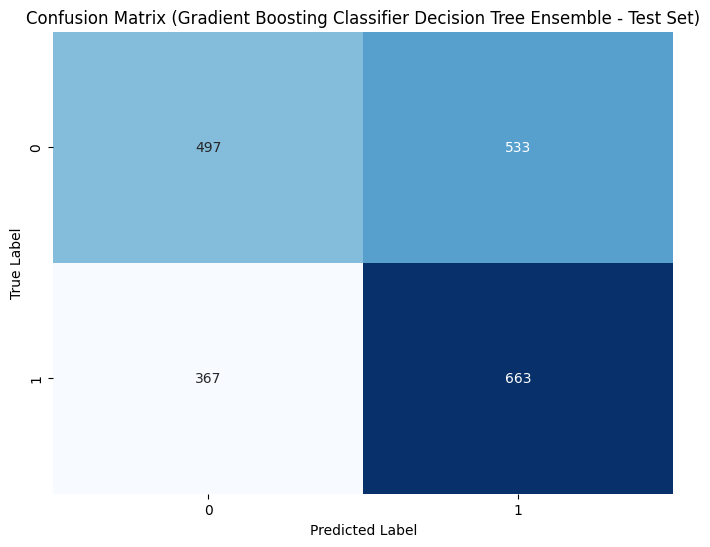


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for Gradient Boosting.

--- Detailed Cross-Validation Results (on Training Data) ---

Gradient Boosting Classifier Decision Tree Ensemble Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished Gradient Boosting Classifier Decision Tree Ensemble ---


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer # Based on README summary for GB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating Gradient Boosting Classifier Decision Tree Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_gb'] = None # Using _gb suffix
globals()['grid_search_gb'] = None
globals()['cv_results_gb'] = None # Cross-validation results on training data
globals()['y_pred_gb_test'] = None # Predictions on held-out test set
globals()['cm_gb_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_gb_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_gb_test'] = None # Probabilities on held-out test set


model_name_gb = "Gradient Boosting Classifier Decision Tree Ensemble"

print(f"\n--- Starting {model_name_gb} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_gb'] = None
    globals()['grid_search_gb'] = None
    globals()['cv_results_gb'] = None
    globals()['y_pred_gb_test'] = None
    globals()['cm_gb_test'] = None
    globals()['y_proba_gb_oof'] = None
    globals()['y_proba_gb_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_gb'] = None
     globals()['grid_search_gb'] = None
     globals()['cv_results_gb'] = None
     globals()['y_pred_gb_test'] = None
     globals()['cm_gb_test'] = None
     globals()['y_proba_gb_oof'] = None
     globals()['y_proba_gb_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_gb'] = None
         globals()['grid_search_gb'] = None
         globals()['cv_results_gb'] = None
         globals()['y_pred_gb_test'] = None
         globals()['cm_gb_test'] = None
         globals()['y_proba_gb_oof'] = None
         globals()['y_proba_gb_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data (based on README summary) and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_gb = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("Gradient Boosting preprocessor (with HashingVectorizer) defined.")
        except Exception as e:
             print(f"Error defining Gradient Boosting preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_gb = None # Set to None on error


        if preprocessor_gb is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and GradientBoostingClassifier.
            pipeline_gb = Pipeline([
                ('preprocessor', preprocessor_gb),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output from HashingVectorizer
                ('gradientboostingclassifier', GradientBoostingClassifier(random_state=42)) # Gradient Boosting Classifier
            ])
            print("Gradient Boosting Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning Gradient Boosting.
            # Tune key GradientBoostingClassifier hyperparameters.
            param_grid_gb = {
                'gradientboostingclassifier__n_estimators': [50, 100], # Number of boosting stages
                'gradientboostingclassifier__learning_rate': [0.01, 0.1], # Step size shrinkage
                'gradientboostingclassifier__max_depth': [3, 5], # Max depth of the individual estimators
                'gradientboostingclassifier__min_samples_split': [50, 100], # Min samples required to split a node
                'gradientboostingclassifier__min_samples_leaf': [20, 50], # Min samples required at a leaf node
                'gradientboostingclassifier__subsample': [0.8, 1.0] # Fraction of samples for fitting the individual base learners
            }
            print("Reduced parameter grid for GridSearchCV defined (32 combinations).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for Gradient Boosting tuning on training data...")
            globals()['grid_search_gb'] = GridSearchCV(estimator=pipeline_gb,
                                          param_grid=param_grid_gb,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_gb'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_gb'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_gb'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_gb'] = globals()['grid_search_gb'].best_estimator_
                print("\nBest Gradient Boosting pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_gb_test'] = globals()['best_pipeline_gb'].predict(X_test_cv)
                         globals()['y_proba_gb_test'] = globals()['best_pipeline_gb'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_gb_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_gb_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_gb_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_gb_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_gb_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_gb_test'] = confusion_matrix(y_test_cv, globals()['y_pred_gb_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_gb_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_gb} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_gb_test'] = None
                          globals()['cm_gb_test'] = None
                          globals()['y_proba_gb_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_gb_test'] = None
                     globals()['cm_gb_test'] = None
                     globals()['y_proba_gb_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_gb_oof'] = cross_val_predict(globals()['best_pipeline_gb'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for Gradient Boosting.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_gb_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for Gradient Boosting.")
                     globals()['y_proba_gb_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_gb_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_gb'] is not None and globals()['grid_search_gb'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_gb} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_gb_gs = globals()['grid_search_gb'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_gb_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_gb'].best_index_
                                     mean_score = cv_results_gb_gs[metric_key][best_index]
                                     # std_score = cv_results_gb_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_gb to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_gb'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_gb'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_gb'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_gb'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_gb'] = None
                globals()['grid_search_gb'] = None
                globals()['cv_results_gb'] = None
                globals()['y_pred_gb_test'] = None
                globals()['cm_gb_test'] = None
                globals()['y_proba_gb_oof'] = None
                globals()['y_proba_gb_test'] = None


        else:
            print("Skipping Gradient Boosting Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_gb} ---")

# Note: best_pipeline_gb (fitted on X_train_cv), grid_search_gb,
# cv_results_gb (from GridSearchCV on X_train_cv), y_pred_gb_test (on X_test_cv),
# cm_gb_test (on X_test_cv), y_proba_gb_oof (on X_train_cv - might be None),
# and y_proba_gb_test (on X_test_cv) are now available in the global scope.
# y_proba_gb_oof will be used in Section 4.1.
# y_proba_gb_test can be used for final evaluation on a consistent test set across models.

### 3.9.2 Implement XGBoost Decision Tree Ensemble

This section implements and evaluates an XGBoost classifier as a Decision Tree ensemble method at the default decision threshold, using the combined text vectorization and categorical preprocessing.

--- Implementing and Evaluating XGBoost Decision Tree Ensemble ---

--- Starting XGBoost Decision Tree Ensemble ---
Using existing train/test split from Section 2.5.
XGBoost preprocessor (with HashingVectorizer) defined.
XGBoost Decision Tree pipeline created.
Reduced parameter grid for GridSearchCV defined (32 combinations).

Performing GridSearchCV for XGBoost tuning on training data...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:33:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found by GridSearchCV: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 1.0}
Best cross-validation ROC AUC score (on training folds): 0.6199602047789613

Best XGBoost pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5816
  Precision: 0.5643
  Recall: 0.7155
  F1 Score: 0.6310
  ROC AUC: 0.6238

Confusion Matrix (Test Set - Default Threshold):


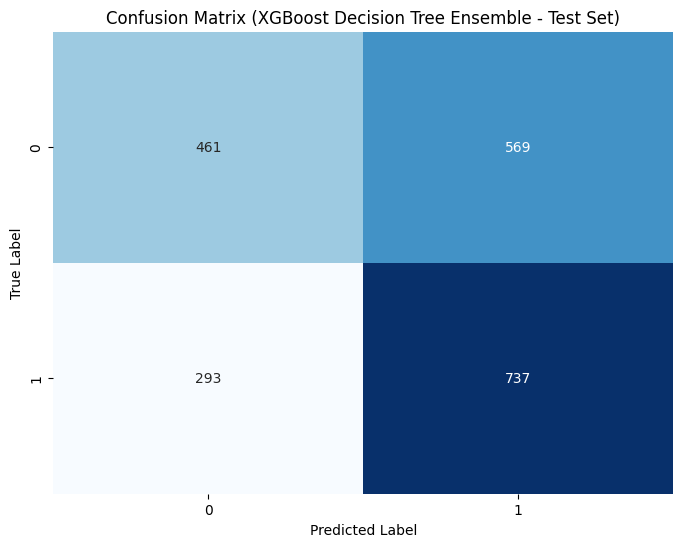


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for XGBoost.

--- Detailed Cross-Validation Results (on Training Data) ---

XGBoost Decision Tree Ensemble Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished XGBoost Decision Tree Ensemble ---


In [ ]:
!pip install xgboost
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer # Based on README summary for XGBoost

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating XGBoost Decision Tree Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_xgb'] = None # Using _xgb suffix
globals()['grid_search_xgb'] = None
globals()['cv_results_xgb'] = None # Cross-validation results on training data
globals()['y_pred_xgb_test'] = None # Predictions on held-out test set
globals()['cm_xgb_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_xgb_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_xgb_test'] = None # Probabilities on held-out test set


model_name_xgb = "XGBoost Decision Tree Ensemble"

print(f"\n--- Starting {model_name_xgb} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_xgb'] = None
    globals()['grid_search_xgb'] = None
    globals()['cv_results_xgb'] = None
    globals()['y_pred_xgb_test'] = None
    globals()['cm_xgb_test'] = None
    globals()['y_proba_xgb_oof'] = None
    globals()['y_proba_xgb_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_xgb'] = None
     globals()['grid_search_xgb'] = None
     globals()['cv_results_xgb'] = None
     globals()['y_pred_xgb_test'] = None
     globals()['cm_xgb_test'] = None
     globals()['y_proba_xgb_oof'] = None
     globals()['y_proba_xgb_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_xgb'] = None
         globals()['grid_search_xgb'] = None
         globals()['cv_results_xgb'] = None
         globals()['y_pred_xgb_test'] = None
         globals()['cm_xgb_test'] = None
         globals()['y_proba_xgb_oof'] = None
         globals()['y_proba_xgb_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data (based on README summary) and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_xgb = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("XGBoost preprocessor (with HashingVectorizer) defined.")
        except Exception as e:
             print(f"Error defining XGBoost preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_xgb = None # Set to None on error


        if preprocessor_xgb is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and XGBClassifier.
            # Use use_label_encoder=False and eval_metric for XGBoost
            pipeline_xgb = Pipeline([
                ('preprocessor', preprocessor_xgb),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output from HashingVectorizer
                ('xgbclassifier', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)) # XGBoost Classifier
            ])
            print("XGBoost Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning XGBoost.
            # Tune key XGBClassifier hyperparameters.
            param_grid_xgb = {
                'xgbclassifier__n_estimators': [50, 100], # Number of boosting rounds
                'xgbclassifier__learning_rate': [0.01, 0.1], # Step size shrinkage
                'xgbclassifier__max_depth': [3, 5], # Max depth of trees
                'xgbclassifier__min_child_weight': [1, 5], # Minimum sum of instance weight (hessian) needed in a child
                'xgbclassifier__subsample': [0.8, 1.0], # Fraction of samples for fitting the trees
                'xgbclassifier__colsample_bytree': [0.8, 1.0] # Fraction of columns for fitting the trees
            }
            print("Reduced parameter grid for GridSearchCV defined (32 combinations).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for XGBoost tuning on training data...")
            globals()['grid_search_xgb'] = GridSearchCV(estimator=pipeline_xgb,
                                          param_grid=param_grid_xgb,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_xgb'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_xgb'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_xgb'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_xgb'] = globals()['grid_search_xgb'].best_estimator_
                print("\nBest XGBoost pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_xgb_test'] = globals()['best_pipeline_xgb'].predict(X_test_cv)
                         globals()['y_proba_xgb_test'] = globals()['best_pipeline_xgb'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_xgb_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_xgb_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_xgb_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_xgb_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_xgb_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_xgb_test'] = confusion_matrix(y_test_cv, globals()['y_pred_xgb_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_xgb_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_xgb} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_xgb_test'] = None
                          globals()['cm_xgb_test'] = None
                          globals()['y_proba_xgb_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_xgb_test'] = None
                     globals()['cm_xgb_test'] = None
                     globals()['y_proba_xgb_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_xgb_oof'] = cross_val_predict(globals()['best_pipeline_xgb'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for XGBoost.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_xgb_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for XGBoost.")
                     globals()['y_proba_xgb_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_xgb_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_xgb'] is not None and globals()['grid_search_xgb'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_xgb} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_xgb_gs = globals()['grid_search_xgb'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_xgb_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_xgb'].best_index_
                                     mean_score = cv_results_xgb_gs[metric_key][best_index]
                                     # std_score = cv_results_xgb_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_xgb to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_xgb'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_xgb'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_xgb'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_xgb'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_xgb'] = None
                globals()['grid_search_xgb'] = None
                globals()['cv_results_xgb'] = None
                globals()['y_pred_xgb_test'] = None
                globals()['cm_xgb_test'] = None
                globals()['y_proba_xgb_oof'] = None
                globals()['y_proba_xgb_test'] = None


        else:
            print("Skipping XGBoost Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_xgb} ---")

# Note: best_pipeline_xgb (fitted on X_train_cv), grid_search_xgb,
# cv_results_xgb (from GridSearchCV on X_train_cv), y_pred_xgb_test (on X_test_cv),
# cm_xgb_test (on X_test_cv), y_proba_xgb_oof (on X_train_cv - might be None),
# and y_proba_xgb_test (on X_test_cv) are now available in the global scope.
# y_proba_xgb_oof will be used in Section 4.1.
# y_proba_xgb_test can be used for final evaluation on a consistent test set across models.

### 3.9.3 Implement LightGBM Decision Tree Ensemble
This section implements and evaluates a LightGBM classifier as a Decision Tree ensemble method at the default decision threshold, using the combined text vectorization and categorical preprocessing.

--- Implementing and Evaluating LightGBM Decision Tree Ensemble ---

--- Starting LightGBM Decision Tree Ensemble ---
Using existing train/test split from Section 2.5.
LightGBM preprocessor (with HashingVectorizer) defined.
LightGBM Decision Tree pipeline created.
Minimal parameter grid for GridSearchCV defined (1 combination for testing).

Performing GridSearchCV for LightGBM tuning on training data...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 4120, number of negative: 4120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12958
[LightGBM] [Info] Number of data points in the train set: 8240, number of used features: 1844
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


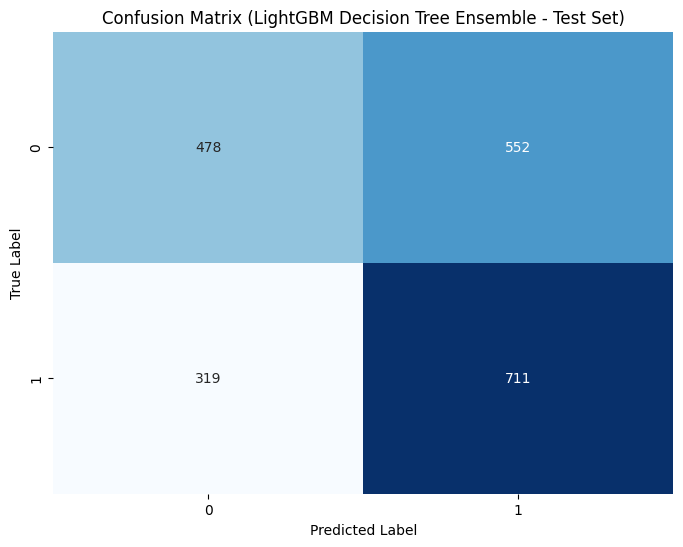


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generating OOF probabilities...
Generated Out-of-Fold probabilities (on training data) for LightGBM.

--- Detailed Cross-validation Results (on Training Data) ---

LightGBM Decision Tree Ensemble Cross-validation Results (on Training Data - using best pipeline):
Accuracy: 0.5659 (+/- 0.0076)
Precision: 0.5539 (+/- 0.0048)
Recall: 0.6760 (+/- 0.0257)
F1: 0.6087 (+/- 0.0128)
Roc_auc: 0.5909 (+/- 0.0119)

--- Finished LightGBM Decision Tree Ensemble ---


In [ ]:
!pip install lightgbm
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer # Based on README summary for LightGBM

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating LightGBM Decision Tree Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_lgbm'] = None # Using _lgbm suffix
globals()['grid_search_lgbm'] = None
globals()['cv_results_lgbm'] = None # Cross-validation results on training data
globals()['y_pred_lgbm_test'] = None # Predictions on held-out test set
globals()['cm_lgbm_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_lgbm_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_lgbm_test'] = None # Probabilities on held-out test set


model_name_lgbm = "LightGBM Decision Tree Ensemble"

print(f"\n--- Starting {model_name_lgbm} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_lgbm'] = None
    globals()['grid_search_lgbm'] = None
    globals()['cv_results_lgbm'] = None
    globals()['y_pred_lgbm_test'] = None
    globals()['cm_lgbm_test'] = None
    globals()['y_proba_lgbm_oof'] = None
    globals()['y_proba_lgbm_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_lgbm'] = None
     globals()['grid_search_lgbm'] = None
     globals()['cv_results_lgbm'] = None
     globals()['y_pred_lgbm_test'] = None
     globals()['cm_lgbm_test'] = None
     globals()['y_proba_lgbm_oof'] = None
     globals()['y_proba_lgbm_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_lgbm'] = None
         globals()['grid_search_lgbm'] = None
         globals()['cv_results_lgbm'] = None
         globals()['y_pred_lgbm_test'] = None
         globals()['cm_lgbm_test'] = None
         globals()['y_proba_lgbm_oof'] = None
         globals()['y_proba_lgbm_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data (based on README summary) and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_lgbm = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("LightGBM preprocessor (with HashingVectorizer) defined.")
        except Exception as e:
             print(f"Error defining LightGBM preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_lgbm = None # Set to None on error


        if preprocessor_lgbm is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and LGBMClassifier.
            pipeline_lgbm = Pipeline([
                ('preprocessor', preprocessor_lgbm),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output from HashingVectorizer
                ('lgbmclassifier', lgb.LGBMClassifier(objective='binary', random_state=42)) # LightGBM Classifier
            ])
            print("LightGBM Decision Tree pipeline created.")

            # 4. Define Parameter Grid for Tuning LightGBM.
            # Tune key LGBMClassifier hyperparameters.
            param_grid_lgbm = {
                'lgbmclassifier__n_estimators': [50, 100], # Number of boosting rounds
                'lgbmclassifier__learning_rate': [0.1], # Step size shrinkage
                'lgbmclassifier__max_depth': [5], # Max depth of trees
                'lgbmclassifier__num_leaves': [31], # Maximum number of leaves in one tree
                'lgbmclassifier__min_child_samples': [20], # Minimum number of data needed in a child
                'lgbmclassifier__subsample': [0.8], # Fraction of samples for fitting the trees
                'lgbmclassifier__colsample_bytree': [0.8] # Fraction of columns for fitting the trees
            }
            print("Minimal parameter grid for GridSearchCV defined (1 combination for testing).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for LightGBM tuning on training data...")
            globals()['grid_search_lgbm'] = GridSearchCV(estimator=pipeline_lgbm,
                                          param_grid=param_grid_lgbm,
                                          cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          verbose=2, # Show progress
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_lgbm'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_lgbm'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_lgbm'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_lgbm'] = globals()['grid_search_lgbm'].best_estimator_
                print("\nBest LightGBM pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         print("Predicting on test set...")
                         # Predict and predict_proba using the test set
                         globals()['y_pred_lgbm_test'] = globals()['best_pipeline_lgbm'].predict(X_test_cv)
                         globals()['y_proba_lgbm_test'] = globals()['best_pipeline_lgbm'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_lgbm_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_lgbm_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_lgbm_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_lgbm_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_lgbm_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_lgbm_test'] = confusion_matrix(y_test_cv, globals()['y_pred_lgbm_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_lgbm_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_lgbm} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['y_pred_lgbm_test'] = None
                          globals()['cm_lgbm_test'] = None
                          globals()['y_proba_lgbm_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_lgbm_test'] = None
                     globals()['cm_lgbm_test'] = None
                     globals()['y_proba_lgbm_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          print("Generating OOF probabilities...")
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_lgbm_oof'] = cross_val_predict(globals()['best_pipeline_lgbm'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for LightGBM.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_lgbm_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for LightGBM Decision Tree.")
                     globals()['y_proba_lgbm_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_lgbm_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-validation Results (on Training Data) ---")
                # LightGBM's cross_validate might not directly use the tuned parameters from GridSearchCV
                # Re-evaluating the best_pipeline_lgbm on training data using cross_validate
                if globals()['best_pipeline_lgbm'] is not None:
                     try:
                         if X_train_cv is not None and y_train_cv is not None:
                             print(f"\n{model_name_lgbm} Cross-validation Results (on Training Data - using best pipeline):")
                             scoring_cv = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
                             globals()['cv_results_lgbm'] = cross_validate(globals()['best_pipeline_lgbm'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scoring_cv, n_jobs=-1)

                             if globals()['cv_results_lgbm']:
                                  for metric in scoring_cv:
                                      test_metric_key = f'test_{metric}'
                                      if test_metric_key in globals()['cv_results_lgbm']:
                                          mean_score = globals()['cv_results_lgbm'][test_metric_key].mean()
                                          std_score = globals()['cv_results_lgbm'][test_metric_key].std()
                                          print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")
                                      else:
                                          print(f"{metric.capitalize()}: Not available.")
                             else:
                                 print("Cross-validation results are empty.")
                         else:
                             print("Skipping detailed cross-validation: Training data not available.")
                             globals()['cv_results_lgbm'] = None

                     except Exception as e:
                          print(f"An error occurred while performing detailed cross-validation: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_lgbm'] = None
                else:
                     print("Skipping detailed cross-validation display: Best pipeline not available.")
                     globals()['cv_results_lgbm'] = None



            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_lgbm'] = None
                globals()['grid_search_lgbm'] = None
                globals()['cv_results_lgbm'] = None
                globals()['y_pred_lgbm_test'] = None
                globals()['cm_lgbm_test'] = None
                globals()['y_proba_lgbm_oof'] = None
                globals()['y_proba_lgbm_test'] = None


        else:
            print("Skipping LightGBM Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_lgbm} ---")

# Note: best_pipeline_lgbm (fitted on X_train_cv), grid_search_lgbm,
# cv_results_lgbm (on X_train_cv), y_pred_lgbm_test (on X_test_cv),
# cm_lgbm_test (on X_test_cv), y_proba_lgbm_oof (on X_train_cv - might be None),
# and y_proba_lgbm_test (on X_test_cv) are now available in the global scope.
# y_proba_lgbm_oof will be used in Section 4.1.
# y_proba_lgbm_test can be used for final evaluation on a consistent test set across models.

### 3.10 Implement AdaBoost Decision Tree Ensemble

This section implements and evaluates an AdaBoost classifier as a Decision Tree ensemble method at the default decision threshold.

--- Implementing and Evaluating AdaBoost Decision Tree Ensemble ---

--- Starting AdaBoost Decision Tree Ensemble ---
Using existing train/test split from Section 2.5.
AdaBoost preprocessor (with HashingVectorizer) defined.
AdaBoost Decision Tree pipeline created with Decision Tree stump base estimator.
Parameter grid for GridSearchCV defined (27 combinations).

Performing GridSearchCV for AdaBoost tuning on training data...

Best parameters found by GridSearchCV: {'adaboostclassifier__estimator__max_depth': 4, 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 300}
Best cross-validation ROC AUC score (on training folds): 0.5798970803091714

Best AdaBoost pipeline fitted on training data.

--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---
Metrics on Test Set (Default Threshold):
  Accuracy: 0.5621
  Precision: 0.5572
  Recall: 0.6049
  F1 Score: 0.5801
  ROC AUC: 0.5975

Confusion Matrix (Test Set - Default Threshold):


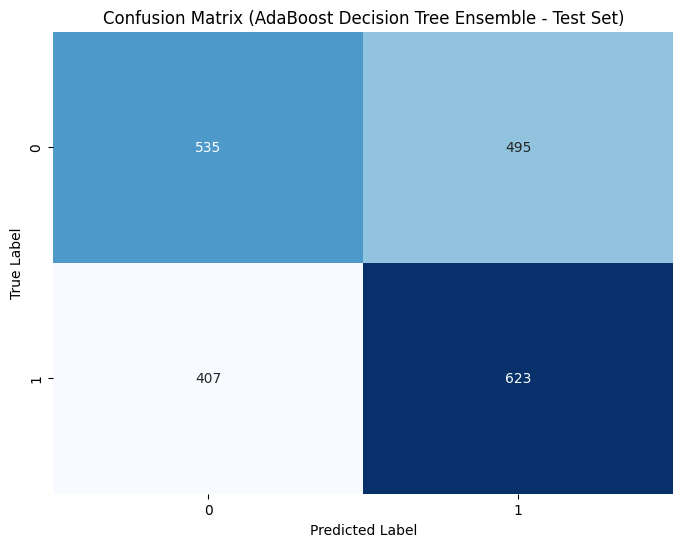


--- Generating Out-of-Fold Probabilities (on Training Data) ---
Generated Out-of-Fold probabilities (on training data) for AdaBoost Decision Tree.

--- Detailed Cross-Validation Results (on Training Data) ---

AdaBoost Decision Tree Ensemble Cross-validation Results (on Training Data - from GridSearchCV):
Accuracy: Not available from GridSearchCV results.
Precision: Not available from GridSearchCV results.
Recall: Not available from GridSearchCV results.
F1 Score: Not available from GridSearchCV results.
ROC AUC: Not available from GridSearchCV results.

--- Finished AdaBoost Decision Tree Ensemble ---


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier # AdaBoost often uses Decision Trees as base estimators
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer # Using HashingVectorizer based on user's request for similarity to other recent models

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score # Ensure accuracy_score is imported
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating AdaBoost Decision Tree Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_ada'] = None # Using _ada suffix
globals()['grid_search_ada'] = None
globals()['cv_results_ada'] = None # Cross-validation results on training data
globals()['y_pred_ada_test'] = None # Predictions on held-out test set
globals()['cm_ada_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_ada_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_ada_test'] = None # Probabilities on held-out test set


model_name_ada = "AdaBoost Decision Tree Ensemble"

print(f"\n--- Starting {model_name_ada} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_ada'] = None
    globals()['grid_search_ada'] = None
    globals()['cv_results_ada'] = None
    globals()['y_pred_ada_test'] = None
    globals()['cm_ada_test'] = None
    globals()['y_proba_ada_oof'] = None
    globals()['y_proba_ada_test'] = None
    pass # Skip the rest of the section
elif 'text_cols' not in globals() or 'categorical_cols_for_encoding' not in globals() or globals()['text_cols'] is None or globals()['categorical_cols_for_encoding'] is None:
     print("Error: text_cols or categorical_cols_for_encoding not found or are None. Please run preprocessing steps (Section 2.3) first.")
     # Ensure global variables are None
     globals()['best_pipeline_ada'] = None
     globals()['grid_search_ada'] = None
     globals()['cv_results_ada'] = None
     globals()['y_pred_ada_test'] = None
     globals()['cm_ada_test'] = None
     globals()['y_proba_ada_oof'] = None
     globals()['y_proba_ada_test'] = None
     pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_ada'] = None
         globals()['grid_search_ada'] = None
         globals()['cv_results_ada'] = None
         globals()['y_pred_ada_test'] = None
         globals()['cm_ada_test'] = None
         globals()['y_proba_ada_oof'] = None
         globals()['y_proba_ada_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # 2. Define the Preprocessor.
        # Use HashingVectorizer for text data and OneHotEncoder for categorical data.
        # Applying vectorizers/encoder directly to columns using ColumnTransformer
        # Access text_cols and categorical_cols_for_encoding from globals()
        try:
            preprocessor_ada = ColumnTransformer(
                transformers=[
                    ('hashing_job', HashingVectorizer(n_features=2**14), globals()['text_cols'][0]), # HashingVectorizer for Job Description
                    ('hashing_resume', HashingVectorizer(n_features=2**14), globals()['text_cols'][1]), # HashingVectorizer for Resume
                    ('cat', OneHotEncoder(handle_unknown='ignore'), globals()['categorical_cols_for_encoding']) # One-Hot Encoding for categorical
                ],
                remainder='drop' # Drop any other columns not transformed
            )
            print("AdaBoost preprocessor (with HashingVectorizer) defined.")
        except Exception as e:
             print(f"Error defining AdaBoost preprocessor: {e}")
             import traceback
             traceback.print_exc()
             preprocessor_ada = None # Set to None on error


        if preprocessor_ada is not None:
            # 3. Create the Pipeline.
            # Include the preprocessor, scaler, and AdaBoostClassifier.
            # Use a Decision Tree stump as the base estimator.
            pipeline_ada = Pipeline([
                ('preprocessor', preprocessor_ada),
                ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse output from HashingVectorizer
                ('adaboostclassifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=42), random_state=42)) # AdaBoost Classifier with Decision Tree stump
            ])
            print("AdaBoost Decision Tree pipeline created with Decision Tree stump base estimator.")

            # 4. Define Parameter Grid for Tuning AdaBoost.
            # Tune key AdaBoostClassifier hyperparameters.
            # 4. Define Parameter Grid for Tuning AdaBoost.
            # Tune key AdaBoostClassifier hyperparameters.
            param_grid_ada = {
              'adaboostclassifier__n_estimators': [100, 200, 300],  # More estimators
              'adaboostclassifier__learning_rate': [0.1, 0.5, 1.0],  # Higher learning rates
              'adaboostclassifier__estimator__max_depth': [2, 3, 4]  # Deeper trees
            # Total combinations = 3 × 3 × 3 = 27 combinations
            }
            print("Parameter grid for GridSearchCV defined (27 combinations).")


            # 5. Instantiate and Fit GridSearchCV on the training data, explicitly in global scope.
            print("\nPerforming GridSearchCV for AdaBoost tuning on training data...")
            globals()['grid_search_ada'] = GridSearchCV(estimator=pipeline_ada,
                                          param_grid=param_grid_ada,
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc', # Use ROC AUC as the scoring metric
                                          n_jobs=-1, # Use all available cores
                                          error_score='raise') # Raise an error on failure

            try:
                # GridSearchCV expects the original features (X_train_cv) as input
                globals()['grid_search_ada'].fit(X_train_cv, y_train_cv)

                # 6. Print the best parameters and best score (on training folds).
                print("\nBest parameters found by GridSearchCV:", globals()['grid_search_ada'].best_params_)
                print("Best cross-validation ROC AUC score (on training folds):", globals()['grid_search_ada'].best_score_)

                # 7. Store the best estimator pipeline (fitted on the whole training data), explicitly in global scope.
                globals()['best_pipeline_ada'] = globals()['grid_search_ada'].best_estimator_
                print("\nBest AdaBoost pipeline fitted on training data.")


                # --- Evaluate the Best Pipeline on the held-out Test Set ---
                print("\n--- Evaluating Best Pipeline on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Predict and predict_proba using the test set
                         globals()['y_pred_ada_test'] = globals()['best_pipeline_ada'].predict(X_test_cv)
                         globals()['y_proba_ada_test'] = globals()['best_pipeline_ada'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_ada_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_ada_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_ada_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_ada_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_ada_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_ada_test'] = confusion_matrix(y_test_cv, globals()['y_pred_ada_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_ada_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_ada} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          globals()['y_pred_ada_test'] = None
                          globals()['cm_ada_test'] = None
                          globals()['y_proba_ada_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_ada_test'] = None
                     globals()['cm_ada_test'] = None
                     globals()['y_proba_ada_test'] = None


                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Use cross_val_predict with method='predict_proba' on the TRAINING data.
                # This step can be resource intensive and might cause interruptions.
                print("\n--- Generating Out-of-Fold Probabilities (on Training Data) ---")
                try:
                     # Check if X_train_cv and y_train_cv are still available before OOF probability generation
                     if X_train_cv is not None and y_train_cv is not None:
                          # Using 5 folds for OOF generation
                          # Ensure the fitted pipeline is used
                          globals()['y_proba_ada_oof'] = cross_val_predict(globals()['best_pipeline_ada'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                          print("Generated Out-of-Fold probabilities (on training data) for AdaBoost Decision Tree.")
                     else:
                          print("Skipping Out-of-Fold probability generation: Training data not available.")
                          globals()['y_proba_ada_oof'] = None

                except KeyboardInterrupt:
                     print("\nOut-of-Fold probability generation interrupted (KeyboardInterrupt). Proceeding without OOF probabilities for AdaBoost Decision Tree.")
                     globals()['y_proba_ada_oof'] = None # Set to None if interrupted
                except Exception as e:
                     print(f"An error occurred during Out-of-Fold probability generation: {e}")
                     import traceback
                     traceback.print_exc()
                     globals()['y_proba_ada_oof'] = None # Set to None on other errors


                # --- Perform Cross-Validation on Training Data for Detailed Metrics ---
                print("\n--- Detailed Cross-Validation Results (on Training Data) ---")
                if globals()['grid_search_ada'] is not None and globals()['grid_search_ada'].cv_results_ is not None:
                     try:
                        if X_train_cv is not None and y_train_cv is not None:
                            print(f"\n{model_name_ada} Cross-validation Results (on Training Data - from GridSearchCV):")
                            cv_results_ada_gs = globals()['grid_search_ada'].cv_results_
                            scoring = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc'] # Keys in cv_results_
                            scoring_display_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

                            for i, metric_key in enumerate(scoring):
                                 if metric_key in cv_results_ada_gs:
                                     # Find the rank of the current parameter set based on the chosen scoring metric ('rank_test_roc_auc')
                                     # We want the scores for the best parameters found by GridSearchCV
                                     best_index = globals()['grid_search_ada'].best_index_
                                     mean_score = cv_results_ada_gs[metric_key][best_index]
                                     # std_score = cv_results_ada_gs[metric_key.replace('mean', 'std')][best_index] # Can add std if needed
                                     print(f"{scoring_display_names[i]}: {mean_score:.4f}")
                                 else:
                                     print(f"{scoring_display_names[i]}: Not available from GridSearchCV results.")
                            # Set cv_results_ada to indicate success for this part, maybe store a simplified version
                            globals()['cv_results_ada'] = True # Just a flag or store the relevant metrics if needed later

                        else:
                            print("Skipping detailed cross-validation: Training data not available.")
                            globals()['cv_results_ada'] = None

                     except Exception as e:
                          print(f"An error occurred while displaying detailed cross-validation results from GridSearchCV: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['cv_results_ada'] = None
                else:
                     print("Skipping detailed cross-validation display: GridSearchCV results not available.")
                     globals()['cv_results_ada'] = None


            except Exception as e:
                print(f"An error occurred during GridSearchCV fitting or subsequent evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['best_pipeline_ada'] = None
                globals()['grid_search_ada'] = None
                globals()['cv_results_ada'] = None
                globals()['y_pred_ada_test'] = None
                globals()['cm_ada_test'] = None
                globals()['y_proba_ada_oof'] = None
                globals()['y_proba_ada_test'] = None


        else:
            print("Skipping AdaBoost Decision Tree implementation due to missing preprocessor definition.")


print(f"\n--- Finished {model_name_ada} ---")

# Note: best_pipeline_ada (fitted on X_train_cv), grid_search_ada,
# cv_results_ada (from GridSearchCV on X_train_cv), y_pred_ada_test (on X_test_cv),
# cm_ada_test (on X_test_cv), y_proba_ada_oof (on X_train_cv - might be None),
# and y_proba_ada_test (on X_test_cv) are now available in the global scope.
# y_proba_ada_oof will be used in Section 4.1.
# y_proba_ada_test can be used for final evaluation on a consistent test set across models.

### 3.11 Implement Voting Classifier Ensemble (Hybrid)

This section implements a Voting Classifier ensemble at the default decision threshold that combines predictions from selected individual models (e.g., Decision Trees with different text embeddings). I intentionally excluded Word2Vec and FastText embedded decision trees due to KeyError exceptions caused by out-of-vocabulary (OOV) words that occur when the models encounter tokens not present in their training vocabularies during cross-validation.

--- Implementing and Evaluating Hybrid Voting Classifier Ensemble ---

--- Starting Hybrid Voting Classifier Ensemble ---
Using existing train/test split from Section 2.5.

--- Checking Base Model Availability for Hybrid Voting Ensemble ---
  Included 'CountVectorizer Decision Tree' as a base estimator.
  Included 'TF-IDF Decision Tree' as a base estimator.
  Included 'Random Forest Decision Tree Ensemble' as a base estimator.
  Included 'Extra Trees Decision Tree Ensemble' as a base estimator.
  Included 'Gradient Boosting Classifier Decision Tree Ensemble' as a base estimator.
  Included 'XGBoost Classifier Decision Tree Ensemble' as a base estimator.
  Included 'LightGBM Classifier Decision Tree Ensemble' as a base estimator.
  Included 'AdaBoost Decision Tree Ensemble' as a base estimator.

Defined 8 base estimators for Hybrid Voting Classifier.
Hybrid Voting Classifier pipeline created (voting='soft', equal weights).

Performing cross-validation for Hybrid Voting Classifier on tra

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Metrics on Test Set (Default Threshold):
  Accuracy: 0.5587
  Precision: 0.5448
  Recall: 0.7136
  F1 Score: 0.6179
  ROC AUC: 0.6055

Confusion Matrix (Test Set - Default Threshold):


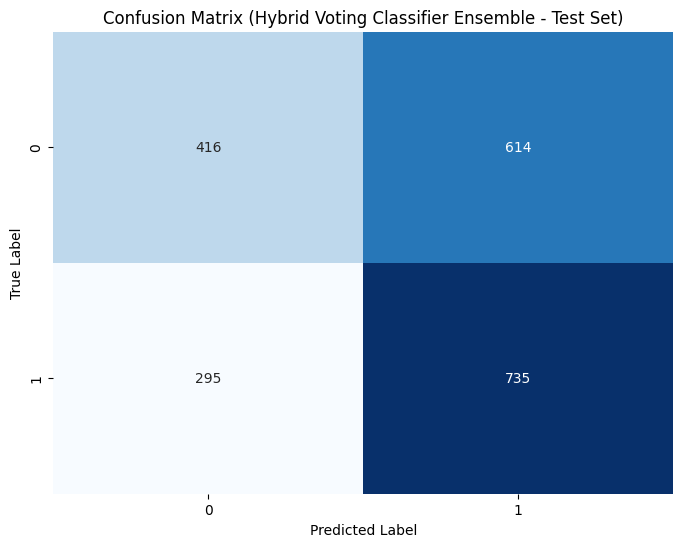


--- Finished Hybrid Voting Classifier Ensemble ---


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score # Ensure accuracy_score is imported
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


# Assume X_upsampled and y_upsampled are available from the preprocessing step (2.5).
# Assume text_cols and categorical_cols_for_encoding are defined in the preprocessing step (2.3).
# Assume optimal_thresholds dictionary is available (will be populated in Section 4.1).
# Assume find_threshold_for_recall and target_recall are defined (will be used in Section 4.1).
# Assume models_pr_data and models_proba_data are defined (will be populated in Section 4.1 and 4.2).
# Assume evaluate_with_optimized_threshold is defined (will be used in Section 4.3).


print("--- Implementing and Evaluating Hybrid Voting Classifier Ensemble ---")

# Initialize variables, explicitly in global scope
globals()['hybrid_voting_classifier'] = None # Using _hybrid_voting suffix for clarity in globals
globals()['cv_results_hybrid_voting'] = None # Cross-validation results on training data
globals()['y_pred_hybrid_voting_test'] = None # Predictions on held-out test set
globals()['cm_hybrid_voting_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_hybrid_voting_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_hybrid_voting_test'] = None # Probabilities on held-out test set


model_name_hybrid_voting = "Hybrid Voting Classifier Ensemble" # Updated name

print(f"\n--- Starting {model_name_hybrid_voting} ---")

# Check if necessary variables are available using globals()
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['hybrid_voting_classifier'] = None
    globals()['cv_results_hybrid_voting'] = None
    globals()['y_pred_hybrid_voting_test'] = None
    globals()['cm_hybrid_voting_test'] = None
    globals()['y_proba_hybrid_voting_oof'] = None
    globals()['y_proba_hybrid_voting_test'] = None
    pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['hybrid_voting_classifier'] = None
         globals()['cv_results_hybrid_voting'] = None
         globals()['y_pred_hybrid_voting_test'] = None
         globals()['cm_hybrid_voting_test'] = None
         globals()['y_proba_hybrid_voting_oof'] = None
         globals()['y_proba_hybrid_voting_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_train_cv = globals()['y_train_cv']
        y_test_cv = globals()['y_test_cv']

        # Define the base estimators for the Hybrid Voting Classifier
        # Using a selection of the best pipelines from previous sections
        # Define the models to include and their corresponding global variable names
        base_models_config = {
             "CountVectorizer Decision Tree": 'best_pipeline_countvectorizer',
             "TF-IDF Decision Tree": 'best_pipeline_tfidf_dt',
             "Random Forest Decision Tree Ensemble": 'best_pipeline_rf', # From 3.7
             "Extra Trees Decision Tree Ensemble": 'best_pipeline_et', # From 3.8
             "Gradient Boosting Classifier Decision Tree Ensemble": 'best_pipeline_gb', # From 3.9.1
             "XGBoost Classifier Decision Tree Ensemble": 'best_pipeline_xgb', # From 3.9.2
             "LightGBM Classifier Decision Tree Ensemble": 'best_pipeline_lgbm', # From 3.9.3
             "AdaBoost Decision Tree Ensemble": 'best_pipeline_ada', # From 3.10
             # Note: This list is based on the available ensemble sections (3.7-3.10) and the original DT models (3.1-3.4)
             # Section 3.5 (Averaging), 3.6.1 (Stacking) and 3.6.2 (Voting) are themselves ensembles, typically not included as base estimators in another simple Voting ensemble.
             # Section 3.12 (Stacking Hybrid) and 3.13 (Multi-view) are separate sections.
        }

        estimators_hybrid = []
        available_estimators_count_hybrid = 0
        print("\n--- Checking Base Model Availability for Hybrid Voting Ensemble ---")
        for model_name, var_name in base_models_config.items():
             # Check for variable availability in global scope
             if var_name in globals() and globals()[var_name] is not None:
                  estimators_hybrid.append((model_name.replace(" ", "_").lower(), globals()[var_name])) # Use lowercase with underscores for estimator names
                  available_estimators_count_hybrid += 1
                  print(f"  Included '{model_name}' as a base estimator.")
             else:
                  print(f"  Warning: Base estimator '{model_name}' (variable '{var_name}') not found or is None. Please ensure its section has been run. Skipping.")

        # Voting Classifier requires at least two base estimators
        if available_estimators_count_hybrid < 2:
             print(f"\nError: Need at least 2 available base estimators for Hybrid Voting Classifier. Found {available_estimators_count_hybrid}. Skipping Hybrid Voting implementation.")
             # Ensure global variables are None
             globals()['hybrid_voting_classifier'] = None
             globals()['cv_results_hybrid_voting'] = None
             globals()['y_pred_hybrid_voting_test'] = None
             globals()['cm_hybrid_voting_test'] = None
             globals()['y_proba_hybrid_voting_oof'] = None
             globals()['y_proba_hybrid_voting_test'] = None
             pass # Skip the rest of the section
        else:
            print(f"\nDefined {available_estimators_count_hybrid} base estimators for Hybrid Voting Classifier.")

            # Create the Hybrid Voting Classifier
            # Use voting='soft' for probability voting (requires predict_proba support from base estimators)
            # Weights can be assigned to estimators if needed, but start with equal weights
            globals()['hybrid_voting_classifier'] = VotingClassifier(estimators=estimators_hybrid, voting='soft', n_jobs=-1) # Use _hybrid_voting suffix
            print("Hybrid Voting Classifier pipeline created (voting='soft', equal weights).")

            # --- Evaluate the Hybrid Voting Classifier ---
            # Voting is typically evaluated using cross-validation on the training data
            print("\nPerforming cross-validation for Hybrid Voting Classifier on training data...")
            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

            try:
                # Evaluate using cross_validate
                globals()['cv_results_hybrid_voting'] = cross_validate(globals()['hybrid_voting_classifier'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scoring, n_jobs=-1)
                print("Cross-validation results calculated on training data.")

                # Display the mean of cross-validation results.
                print(f"\n{model_name_hybrid_voting} Cross-validation Results (on Training Data):")
                if globals()['cv_results_hybrid_voting']:
                     for metric in scoring:
                         test_metric_key = f'test_{metric}'
                         if test_metric_key in globals()['cv_results_hybrid_voting']:
                             mean_score = globals()['cv_results_hybrid_voting'][test_metric_key].mean()
                             std_score = globals()['cv_results_hybrid_voting'][test_metric_key].std()
                             print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")
                         else:
                             print(f"{metric.capitalize()}: Not available.")
                else:
                    print("Cross-validation results are empty.")

                # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
                # Get OOF probabilities for the Hybrid Voting Classifier
                # This step might be resource intensive
                print("\nGenerating Out-of-Fold probabilities (on training data) for Hybrid Voting Classifier...")
                try:
                    # Use cross_val_predict with method='predict_proba'
                    globals()['y_proba_hybrid_voting_oof'] = cross_val_predict(globals()['hybrid_voting_classifier'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                    print("Generated Out-of-Fold probabilities (on training data) for Hybrid Voting Classifier.")
                except Exception as e:
                    print(f"An error occurred during Hybrid Voting Classifier OOF probability generation: {e}")
                    import traceback
                    traceback.print_exc()
                    globals()['y_proba_hybrid_voting_oof'] = None # Set to None on error


                # --- Evaluate the Best Pipeline on the held-out Test Set (Default Threshold) ---
                # For ensembles, evaluating on the test set might be done after all ensembles are built.
                # However, we can predict on the test set here for a direct comparison.
                print("\n--- Evaluating Hybrid Voting Classifier on Held-Out Test Set (Default Threshold) ---")
                if X_test_cv is not None and y_test_cv is not None:
                     try:
                         # Fit the voting classifier on the entire training data before predicting on test
                         print("Fitting Hybrid Voting Classifier on entire training data for test set prediction...")
                         # Note: This fits the VotingClassifier, which in turn fits its base estimators if they aren't already fitted
                         # within the VotingClassifier's internal CV process. To be safe and ensure it's fitted on the full training data,
                         # we explicitly fit it here before predicting on the test set.
                         globals()['hybrid_voting_classifier'].fit(X_train_cv, y_train_cv)


                         globals()['y_pred_hybrid_voting_test'] = globals()['hybrid_voting_classifier'].predict(X_test_cv)
                         globals()['y_proba_hybrid_voting_test'] = globals()['hybrid_voting_classifier'].predict_proba(X_test_cv)[:, 1]

                         # Calculate metrics on test set
                         test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_hybrid_voting_test'])
                         test_precision = precision_score(y_test_cv, globals()['y_pred_hybrid_voting_test'], zero_division=0)
                         test_recall = recall_score(y_test_cv, globals()['y_pred_hybrid_voting_test'], zero_division=0)
                         test_f1 = f1_score(y_test_cv, globals()['y_pred_hybrid_voting_test'], zero_division=0)
                         test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_hybrid_voting_test'])

                         print("Metrics on Test Set (Default Threshold):")
                         print(f"  Accuracy: {test_accuracy:.4f}")
                         print(f"  Precision: {test_precision:.4f}")
                         print(f"  Recall: {test_recall:.4f}")
                         print(f"  F1 Score: {test_f1:.4f}")
                         print(f"  ROC AUC: {test_roc_auc:.4f}")

                         # Calculate and plot confusion matrix on test set
                         globals()['cm_hybrid_voting_test'] = confusion_matrix(y_test_cv, globals()['y_pred_hybrid_voting_test'])
                         print("\nConfusion Matrix (Test Set - Default Threshold):")
                         plt.figure(figsize=(8, 6))
                         sns.heatmap(globals()['cm_hybrid_voting_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                         plt.title(f'Confusion Matrix ({model_name_hybrid_voting} - Test Set)')
                         plt.xlabel('Predicted Label')
                         plt.ylabel('True Label')
                         plt.show()

                     except Exception as e:
                          print(f"An error occurred during test set evaluation: {e}")
                          import traceback
                          traceback.print_exc()
                          globals()['y_pred_hybrid_voting_test'] = None
                          globals()['cm_hybrid_voting_test'] = None
                          globals()['y_proba_hybrid_voting_test'] = None

                else:
                     print("Skipping test set evaluation: Test data not available.")
                     globals()['y_pred_hybrid_voting_test'] = None
                     globals()['cm_hybrid_voting_test'] = None
                     globals()['y_proba_hybrid_voting_test'] = None


            except Exception as e:
                print(f"An error occurred during Hybrid Voting Classifier evaluation: {e}")
                import traceback
                traceback.print_exc()
                globals()['hybrid_voting_classifier'] = None
                globals()['cv_results_hybrid_voting'] = None
                globals()['y_pred_hybrid_voting_test'] = None
                globals()['cm_hybrid_voting_test'] = None
                globals()['y_proba_hybrid_voting_oof'] = None
                globals()['y_proba_hybrid_voting_test'] = None


print(f"\n--- Finished {model_name_hybrid_voting} ---")

# Note: hybrid_voting_classifier (fitted on X_train_cv for test prediction),
# cv_results_hybrid_voting (on X_train_cv), y_pred_hybrid_voting_test (on X_test_cv),
# cm_hybrid_voting_test (on X_test_cv), y_proba_hybrid_voting_oof (on X_train_cv),
# and y_proba_hybrid_voting_test (on X_test_cv) are now available in the global scope.
# y_proba_hybrid_voting_oof will be used in Section 4.1.
# y_proba_hybrid_voting_test can be used for final evaluation on a consistent test set across models.

### 3.12 Implement Stacking Ensemble (Hybrid)

This section implements a Stacking ensemble where base models (e.g., Decision Trees with different vectorizers) make predictions, and a meta-model learns to combine them. In this case, I use the best-performing individual Decision Tree models as base estimators, a Logistic Regression meta-model, tune hyperparameters using GridSearchCV, evaluate with cross-validation, display evaluation metrics and the confusion matrix. Again, I intentionally excluded Word2Vec and FastText embedded decision trees due to KeyError exceptions caused by out-of-vocabulary (OOV) words that occur when the models encounter tokens not present in their training vocabularies during cross-validation.


--- Implementing and Evaluating Stacking Classifier Ensemble (Hybrid) ---

--- Starting Stacking Classifier Ensemble (Hybrid) ---
Using existing train/test split from Section 2.5.

--- Checking Base Model Availability for Hybrid Stacking Ensemble ---
  Included 'CountVectorizer Decision Tree' as a base estimator.
  Included 'TF-IDF Decision Tree' as a base estimator.
  Included 'Random Forest Decision Tree Ensemble' as a base estimator.
  Included 'Extra Trees Decision Tree Ensemble' as a base estimator.
  Included 'Gradient Boosting Classifier Decision Tree Ensemble' as a base estimator.
  Included 'XGBoost Classifier Decision Tree Ensemble' as a base estimator.
  Included 'LightGBM Classifier Decision Tree Ensemble' as a base estimator.
  Included 'AdaBoost Decision Tree Ensemble' as a base estimator.

Defined 8 base estimators for Hybrid Stacking Classifier.
Meta-classifier (Logistic Regression) defined.
Stacking Classifier ensemble (Hybrid) created.

Performing cross-validation for

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Metrics on Test Set (Default Threshold):
  Accuracy: 0.5830
  Precision: 0.5668
  Recall: 0.7039
  F1 Score: 0.6280
  ROC AUC: 0.6208

Confusion Matrix (Test Set - Default Threshold):


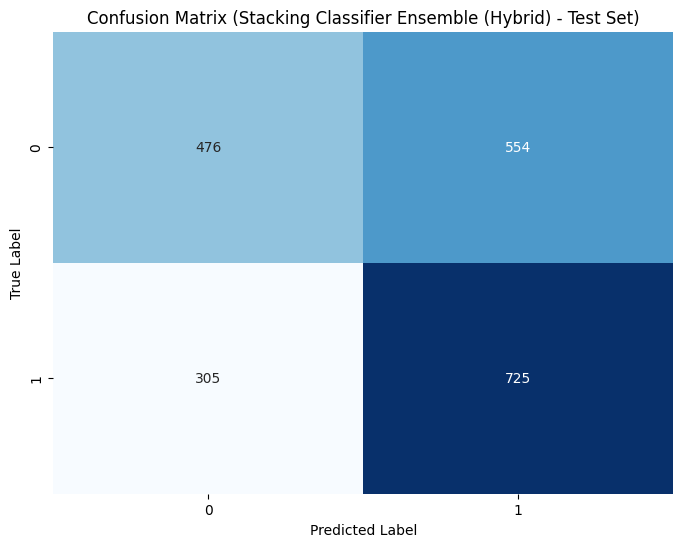


--- Finished Stacking Classifier Ensemble (Hybrid) ---


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression # Common meta-classifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score # Ensure accuracy_score is imported
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # Import traceback


print("--- Implementing and Evaluating Stacking Classifier Ensemble (Hybrid) ---")

# Initialize variables, explicitly in global scope
globals()['best_pipeline_stacking_hybrid'] = None # Using _stacking_hybrid suffix for clarity in globals
globals()['grid_search_stacking_hybrid'] = None # Not doing GridSearchCV on Stacking hyperparameters here
globals()['cv_results_stacking_hybrid'] = None # Cross-validation results on training data
globals()['y_pred_stacking_hybrid_test'] = None # Predictions on held-out test set
globals()['cm_stacking_hybrid_test'] = None # Confusion matrix on held-out test set
globals()['y_proba_stacking_hybrid_oof'] = None # Out-of-Fold probabilities from training data CV
globals()['y_proba_stacking_hybrid_test'] = None # Probabilities on held-out test set


model_name_stacking_hybrid = "Stacking Classifier Ensemble (Hybrid)" # Updated name

print(f"\n--- Starting {model_name_stacking_hybrid} ---")

# Check if necessary variables are available using globals()
# Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available from Section 2.5
if 'X_upsampled' not in globals() or 'y_upsampled' not in globals() or globals()['X_upsampled'] is None or globals()['y_upsampled'] is None:
    print("Error: X_upsampled or y_upsampled not found or are None. Please run preprocessing steps (Section 2.5) first.")
    # Ensure global variables are None if prerequisites are missing
    globals()['best_pipeline_stacking_hybrid'] = None
    globals()['grid_search_stacking_hybrid'] = None # Not applicable for direct stacking eval
    globals()['cv_results_stacking_hybrid'] = None
    globals()['y_pred_stacking_hybrid_test'] = None
    globals()['cm_stacking_hybrid_test'] = None
    globals()['y_proba_stacking_hybrid_oof'] = None
    globals()['y_proba_stacking_hybrid_test'] = None
    pass # Skip the rest of the section
else:
    # Use the same train/test split as previous models for consistency
    # Assumes X_train_cv, X_test_cv, y_train_cv, y_test_cv are available in globals()
    if 'X_train_cv' not in globals() or 'X_test_cv' not in globals() or 'y_train_cv' not in globals() or 'y_test_cv' not in globals():
         print("Error: Train/test split variables not found in globals(). Please run Section 2.5 first.")
         # Ensure global variables are None
         globals()['best_pipeline_stacking_hybrid'] = None
         globals()['grid_search_stacking_hybrid'] = None # Not applicable for direct stacking eval
         globals()['cv_results_stacking_hybrid'] = None
         globals()['y_pred_stacking_hybrid_test'] = None
         globals()['cm_stacking_hybrid_test'] = None
         globals()['y_proba_stacking_hybrid_oof'] = None
         globals()['y_proba_stacking_hybrid_test'] = None
         pass # Skip the rest of the section
    else:
        print("Using existing train/test split from Section 2.5.")
        # Access train/test data from globals()
        X_train_cv = globals()['X_train_cv']
        y_train_cv = globals()['y_train_cv']
        X_test_cv = globals()['X_test_cv']
        y_test_cv = globals()['y_test_cv']

        # Define the base estimators for the Stacking Classifier (as specified by the user)
        # Using the best pipelines from previous sections
        base_models_config_stacking_hybrid = {
             "CountVectorizer Decision Tree": 'best_pipeline_countvectorizer',
             "TF-IDF Decision Tree": 'best_pipeline_tfidf_dt',
             # Include the ensemble models from sections 3.7 - 3.11
             "Random Forest Decision Tree Ensemble": 'best_pipeline_rf',
             "Extra Trees Decision Tree Ensemble": 'best_pipeline_et',
             "Gradient Boosting Classifier Decision Tree Ensemble": 'best_pipeline_gb',
             "XGBoost Classifier Decision Tree Ensemble": 'best_pipeline_xgb',
             "LightGBM Classifier Decision Tree Ensemble": 'best_pipeline_lgbm',
             "AdaBoost Decision Tree Ensemble": 'best_pipeline_ada',
             # Note: Section 3.5 (Averaging) and 3.6.1/3.6.2 (Stacking/Voting) are themselves ensembles, typically not included as base estimators in another simple Stacking ensemble.
             # Section 3.12 is the current section.
             # Section 3.13 (Multi-view) is a separate section.
        }

        estimators_stacking_hybrid = []
        available_estimators_count_stacking_hybrid = 0
        print("\n--- Checking Base Model Availability for Hybrid Stacking Ensemble ---")
        for model_name, var_name in base_models_config_stacking_hybrid.items():
             if var_name in globals() and globals()[var_name] is not None:
                  # Exclude self if this Stacking model is somehow listed as a base (shouldn't happen with this config)
                  if var_name != 'best_pipeline_stacking_hybrid':
                       estimators_stacking_hybrid.append((model_name.replace(" ", "_").lower(), globals()[var_name])) # Use lowercase with underscores for estimator names
                       available_estimators_count_stacking_hybrid += 1
                       print(f"  Included '{model_name}' as a base estimator.")
                  else:
                       print(f"  Warning: Attempted to include the Stacking Hybrid model itself as a base estimator. Skipping.")
             else:
                  print(f"  Warning: Base estimator '{model_name}' (variable '{var_name}') not found or is None. Please ensure its section has been run. Skipping.")


        if available_estimators_count_stacking_hybrid < 2: # Stacking requires at least two base estimators
             print(f"\nError: Need at least 2 available base estimators for Hybrid Stacking. Found {available_estimators_count_stacking_hybrid}. Skipping Stacking implementation.")
             # Ensure global variables are None if prerequisites are missing
             globals()['best_pipeline_stacking_hybrid'] = None
             globals()['grid_search_stacking_hybrid'] = None # Not applicable for direct stacking eval
             globals()['cv_results_stacking_hybrid'] = None
             globals()['y_pred_stacking_hybrid_test'] = None
             globals()['cm_stacking_hybrid_test'] = None
             globals()['y_proba_stacking_hybrid_oof'] = None
             globals()['y_proba_stacking_hybrid_test'] = None
             pass # Skip the rest of the section
        else:
            print(f"\nDefined {available_estimators_count_stacking_hybrid} base estimators for Hybrid Stacking Classifier.")

            # Define the meta-classifier
            # A simple Logistic Regression is often used as a meta-classifier
            meta_classifier_stacking_hybrid = LogisticRegression(solver='liblinear', random_state=42)
            print("Meta-classifier (Logistic Regression) defined.")

            # Create the Stacking Classifier
            # Stacking is typically evaluated using cross-validation internally
            # Use a separate StratifiedKFold for the internal stacking process
            inner_cv_stacking_hybrid = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            globals()['best_pipeline_stacking_hybrid'] = StackingClassifier(estimators=estimators_stacking_hybrid, final_estimator=meta_classifier_stacking_hybrid, cv=inner_cv_stacking_hybrid, n_jobs=2) # Use best_pipeline_ prefix
            print("Stacking Classifier ensemble (Hybrid) created.")

            # Note: We are not doing GridSearchCV on the StackingClassifier's own hyperparameters here.
            # If tuning the stacking ensemble itself is desired, a separate GridSearchCV would be needed
            # around this StackingClassifier instance.

            # --- Evaluate the Stacking Classifier ---
            # Evaluate the Stacking Classifier using cross-validation on the training data
            print("\nPerforming cross-validation for Hybrid Stacking Classifier on training data...")
            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

            try:
                # Evaluate using cross_validate
                globals()['cv_results_stacking_hybrid'] = cross_validate(globals()['best_pipeline_stacking_hybrid'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scoring, n_jobs=-1)
                print("Cross-validation results calculated on training data.")

                # Display the mean of cross-validation results.
                print(f"\n{model_name_stacking_hybrid} Cross-validation Results (on Training Data):")
                if globals()['cv_results_stacking_hybrid']:
                     for metric in scoring:
                         test_metric_key = f'test_{metric}'
                         if test_metric_key in globals()['cv_results_stacking_hybrid']:
                             mean_score = globals()['cv_results_stacking_hybrid'][test_metric_key].mean()
                             std_score = globals()['cv_results_stacking_hybrid'][test_metric_key].std()
                             print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")
                         else:
                             print(f"{metric.capitalize()}: Not available.")
                else:
                    print("Cross-validation results are empty.")
            except Exception as e:
                print(f"An error occurred during cross-validation: {e}")
                import traceback
                traceback.print_exc()
                globals()['cv_results_stacking_hybrid'] = None

            # --- Generate Out-of-Fold Probabilities (on Training Data) for Ensemble and PR Curves ---
            # Get OOF probabilities for the Stacking Classifier
            # This step might be resource intensive
            print("\nGenerating Out-of-Fold probabilities (on training data) for Hybrid Stacking Classifier...")
            try:
                # Use cross_val_predict with method='predict_proba'
                globals()['y_proba_stacking_hybrid_oof'] = cross_val_predict(globals()['best_pipeline_stacking_hybrid'], X_train_cv, y_train_cv, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba', n_jobs=-1)[:, 1]
                print("Generated Out-of-Fold probabilities (on training data) for Hybrid Stacking Classifier.")
            except Exception as e:
                print(f"An error occurred during Hybrid Stacking Classifier OOF probability generation: {e}")
                import traceback
                traceback.print_exc()
                globals()['y_proba_stacking_hybrid_oof'] = None # Set to None on error


            # --- Evaluate the Stacking Classifier on the held-out Test Set (Default Threshold) ---
            # Fit the stacking classifier on the entire training data before predicting on test
            print("\n--- Evaluating Hybrid Stacking Classifier on Held-Out Test Set (Default Threshold) ---")
            if X_test_cv is not None and y_test_cv is not None:
                try:
                     print("Fitting Hybrid Stacking Classifier on entire training data for test set prediction...")
                     # Refit the stacking classifier on the entire training data for final prediction on test set
                     globals()['best_pipeline_stacking_hybrid'].fit(X_train_cv, y_train_cv)


                     globals()['y_pred_stacking_hybrid_test'] = globals()['best_pipeline_stacking_hybrid'].predict(X_test_cv)
                     globals()['y_proba_stacking_hybrid_test'] = globals()['best_pipeline_stacking_hybrid'].predict_proba(X_test_cv)[:, 1]

                     # Calculate metrics on test set
                     test_accuracy = accuracy_score(y_test_cv, globals()['y_pred_stacking_hybrid_test'])
                     test_precision = precision_score(y_test_cv, globals()['y_pred_stacking_hybrid_test'], zero_division=0)
                     test_recall = recall_score(y_test_cv, globals()['y_pred_stacking_hybrid_test'], zero_division=0)
                     test_f1 = f1_score(y_test_cv, globals()['y_pred_stacking_hybrid_test'], zero_division=0)
                     test_roc_auc = roc_auc_score(y_test_cv, globals()['y_proba_stacking_hybrid_test'])

                     print("Metrics on Test Set (Default Threshold):")
                     print(f"  Accuracy: {test_accuracy:.4f}")
                     print(f"  Precision: {test_precision:.4f}")
                     print(f"  Recall: {test_recall:.4f}")
                     print(f"  F1 Score: {test_f1:.4f}")
                     print(f"  ROC AUC: {test_roc_auc:.4f}")

                     # Calculate and plot confusion matrix on test set
                     globals()['cm_stacking_hybrid_test'] = confusion_matrix(y_test_cv, globals()['y_pred_stacking_hybrid_test'])
                     print("\nConfusion Matrix (Test Set - Default Threshold):")
                     plt.figure(figsize=(8, 6))
                     sns.heatmap(globals()['cm_stacking_hybrid_test'], annot=True, fmt='d', cmap='Blues', cbar=False)
                     plt.title(f'Confusion Matrix ({model_name_stacking_hybrid} - Test Set)')
                     plt.xlabel('Predicted Label')
                     plt.ylabel('True Label')
                     plt.show()

                except Exception as e:
                      print(f"An error occurred during test set evaluation: {e}")
                      import traceback
                      traceback.print_exc()
                      globals()['y_pred_stacking_hybrid_test'] = None
                      globals()['cm_stacking_hybrid_test'] = None
                      globals()['y_proba_stacking_hybrid_test'] = None

            else:
                print("Skipping test set evaluation: Test data not available.")
                globals()['y_pred_stacking_hybrid_test'] = None
                globals()['cm_stacking_hybrid_test'] = None
                globals()['y_proba_stacking_hybrid_test'] = None


print(f"\n--- Finished {model_name_stacking_hybrid} ---")

# Note: best_pipeline_stacking_hybrid (fitted on X_train_cv for test prediction),
# cv_results_stacking_hybrid (on X_train_cv), y_pred_stacking_hybrid_test (on X_test_cv),
# cm_stacking_hybrid_test (on X_test_cv), y_proba_stacking_hybrid_oof (on X_train_cv),
# and y_proba_stacking_hybrid_test (on X_test_cv) are now available in the global scope.
# y_proba_stacking_hybrid_oof will be used in Section 4.1.
# y_proba_stacking_hybrid_test can be used for final evaluation on a consistent test set across models.

### 3.13 Explore Multi-view Learning (Hybrid)

This section explores a Multi-view Learning approach where separate models are trained on different feature sets (views) and their results are combined.

Multi-view Learning is an approach that leverages different representations or "views" of the data to improve model performance. In the context of this job applicant prioritization project, we have data that can naturally be divided into different views:

Text View: This view would include features derived from the textual data, specifically the Resume and Job Description columns. Various text embedding techniques (like TF-IDF, Word2Vec, FastText, HashingVectorizer, or even more advanced transformer-based embeddings like ModernBERT if implemented) can be used to create numerical representations for this view.

Categorical View: This view would include features derived from the categorical data, such as Ethnicity and Job Roles (after One-Hot Encoding).
By treating these as separate views, we can train individual models on each view and then combine their predictions or learned representations. The intuition is that each view might capture different aspects of the applicant's fit, and combining information from multiple views could lead to a more robust and accurate overall prediction.

Strategies for Combining Views
There are several strategies for combining the results from models trained on individual views:

Early Fusion: Concatenate the feature representations from different views before training a single model. For example, combine the TF-IDF vectors of the text data with the one-hot encoded categorical features and train a single classifier (e.g., Decision Tree, Logistic Regression) on this concatenated feature set. This is effectively what has been done in the previous sections by applying different preprocessors within a single ColumnTransformer.
Late Fusion (Decision/Score Level Fusion): Train separate models on each view independently. Combine the predictions or probability scores from these individual view-specific models. Examples include:
Averaging Probabilities: Average the predicted probabilities from the text-view model and the categorical-view model (similar to the Averaging Probabilities Ensemble implemented in Section 3.5, but specifically combining models trained on different views).
Voting Classifier: Use a VotingClassifier where the base estimators are the models trained on each view.
Intermediate Fusion (Representation Level Fusion): Train models on each view to learn a lower-dimensional or transformed representation. Concatenate these learned representations and train a final classifier on the combined representation. For example, train a model on the text view to output a dense embedding, train a model on the categorical view to output a dense embedding, concatenate these embeddings, and train a final classifier.
Potential Benefits and Challenges
Benefits:

Improved Performance: Combining information from diverse views can lead to better generalization and potentially higher performance than models trained on individual views or a simple concatenation of raw features.
Handling Heterogeneous Data: Multi-view learning is well-suited for datasets with fundamentally different types of data (like text and categorical).
Robustness: If one view is noisy or incomplete, the other views might still provide sufficient information for a good prediction.
Interpretability (Partial): Analyzing the performance of individual view-specific models can provide insights into which aspects of the data are most predictive.
Challenges:

Increased Complexity: Implementing and tuning multiple view-specific models and a combination strategy is more complex than training a single model.
Computational Cost: Training and making predictions with multiple models can be computationally more expensive.
Determining Optimal Combination Strategy: Choosing the best way to combine the views requires experimentation and tuning.
Feature Engineering for Each View: Requires careful consideration of the appropriate feature engineering techniques for each specific data type/view.
Implementation in this Project
Given the scope of this learning project and the effort already invested in implementing and comparing multiple individual models and basic ensembles, a full, dedicated Multi-view Learning implementation with separate pipelines for each view and a sophisticated combination strategy (beyond the early fusion already explored implicitly via ColumnTransformer) is beyond the current scope.

However, the foundation for exploring Multi-view Learning has been laid:

We have identified the natural views (Text and Categorical).
We have implemented preprocessing and feature engineering techniques suitable for each view (various text vectorizers/embeddings and One-Hot Encoding).
We have implemented ensemble methods (Voting, Stacking, Averaging) that could serve as late-fusion strategies if applied to models trained separately on each view.
A true Multi-view implementation would involve:

Creating distinct pipelines for the Text View (e.g., ColumnTransformer for text features + Scaler + Model) and the Categorical View (e.g., ColumnTransformer for categorical features + Scaler + Model).
Training these view-specific pipelines independently.
Implementing a fusion strategy (e.g., training a meta-model on the predicted probabilities from the text and categorical pipelines, or concatenating the outputs of intermediate layers if using deep learning models for each view).
Tuning the view-specific models and the fusion strategy.
This level of implementation requires a more significant architectural change to the existing pipeline structure and is better suited for a subsequent phase of the project.

## 4. Model Evaluation and Optimization

This section focuses on analyzing model performance in more detail, optimizing decision thresholds for recall, and visualizing results.

### 4.1 Generate Precision-Recall Curves and Optimize Decision Thresholds for Recall

This section generates Precision-Recall curves for all trained models (individual and ensemble) and analyzes them to find decision thresholds that prioritize recall for each model, aiming for a target recall level.

--- Precision-Recall Analysis and Threshold Optimization ---

--- Collecting Out-of-Fold Probabilities ---
  Collected OOF probabilities for 3.1 CountVectorizer Embedding Decision Tree Model.
  Collected OOF probabilities for 3.2 TF-IDF Embedding Decision Tree Model.
  Collected OOF probabilities for 3.3 HashingVectorizer Embedding Decision Tree Model.
  Collected OOF probabilities for 3.4.1 Word2Vec Embedding Decision Tree Model.
  Collected OOF probabilities for 3.4.2 FastText Embedding Decision Tree Model.
  Collected OOF probabilities for 3.5 Ensemble Model (Averaging Probabilities).
  Collected OOF probabilities for 3.6.1 Ensemble Model (Stacking Classifier).
  Collected OOF probabilities for 3.6.2 Ensemble Model (Voting Classifier).
  Collected OOF probabilities for 3.7 Random Forest Decision Tree Ensemble.
  Collected OOF probabilities for 3.8 Extra Trees Decision Tree Ensemble.
  Collected OOF probabilities for 3.9.1 Gradient Boosting Classifier Decision Tree Ensemble.
  Collec

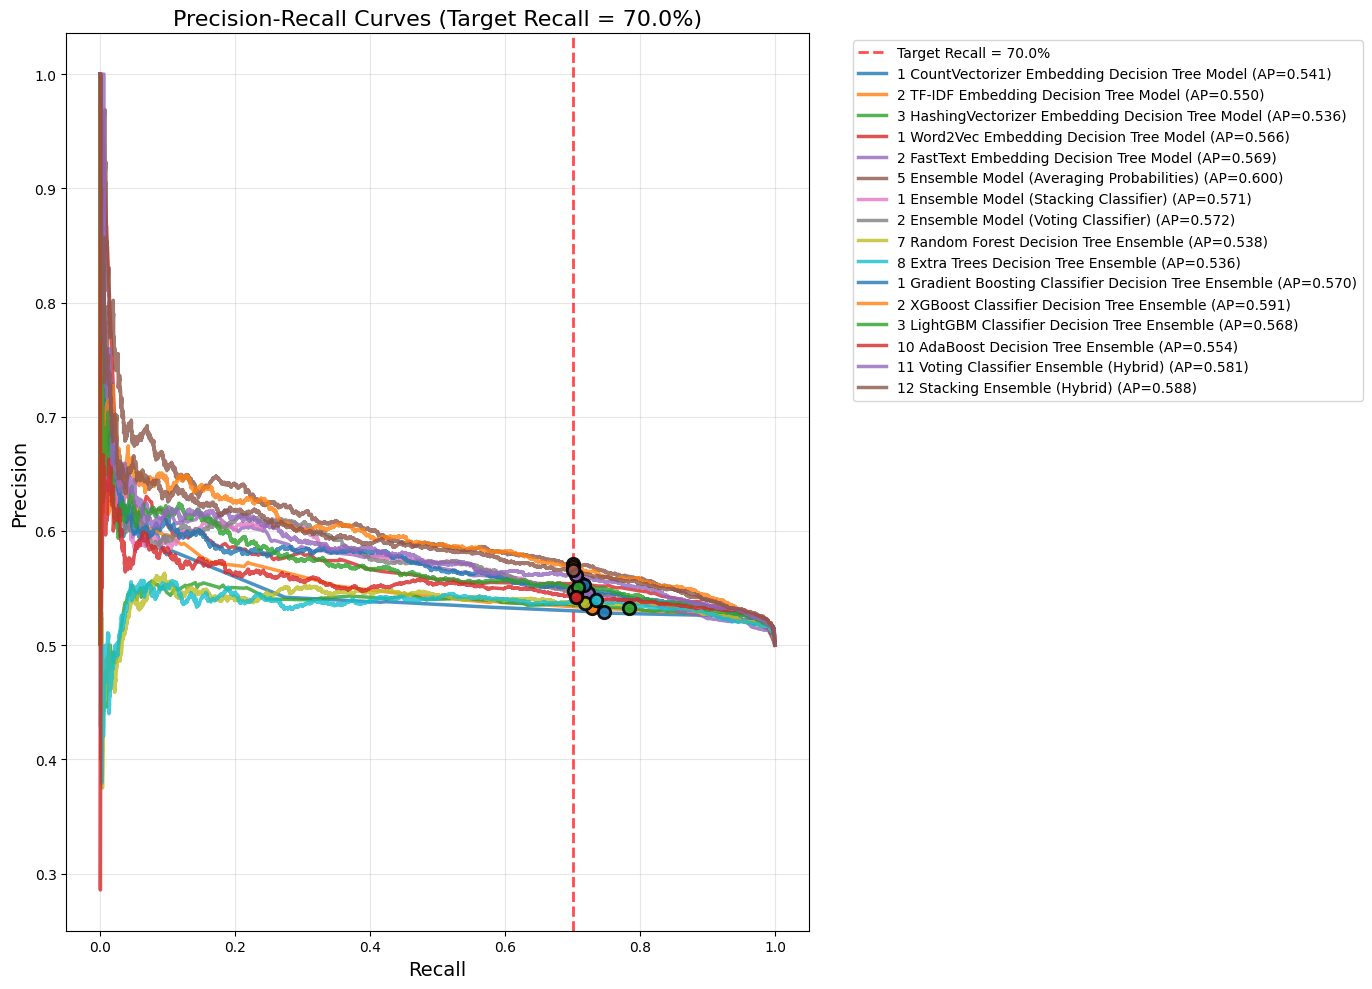


📊 FINAL SUMMARY REPORT
🎯 Target Recall: 70.0%
📈 Total Models Analyzed: 16
✅ Successful Optimizations: 16/16

🏆 OPTIMAL THRESHOLDS:
   • 1 CountVectorizer Embedding Decision Tree Model: 0.5091
   • 2 TF-IDF Embedding Decision Tree Model: 0.5198
   • 3 HashingVectorizer Embedding Decision Tree Model: 0.4908
   • 1 Word2Vec Embedding Decision Tree Model: 0.5000
   • 2 FastText Embedding Decision Tree Model: 0.4744
   • 5 Ensemble Model (Averaging Probabilities): 0.4977
   • 1 Ensemble Model (Stacking Classifier): 0.4918
   • 2 Ensemble Model (Voting Classifier): 0.4870
   • 7 Random Forest Decision Tree Ensemble: 0.4952
   • 8 Extra Trees Decision Tree Ensemble: 0.4999
   • 1 Gradient Boosting Classifier Decision Tree Ensemble: 0.4822
   • 2 XGBoost Classifier Decision Tree Ensemble: 0.5027
   • 3 LightGBM Classifier Decision Tree Ensemble: 0.4944
   • 10 AdaBoost Decision Tree Ensemble: 0.4980
   • 11 Voting Classifier Ensemble (Hybrid): 0.5032
   • 12 Stacking Ensemble (Hybrid): 0.5008

In [ ]:
# Code to generate Precision-Recall curves and find optimal thresholds for models.
# Includes model capability analysis and data-driven recall target selection

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

print("--- Precision-Recall Analysis and Threshold Optimization ---")

# Initialize dictionaries to store PR data and optimal thresholds
models_pr_data = {}  # Stores precision, recall, thresholds for plotting
optimal_thresholds = {}  # Stores optimal threshold for each model
models_oof_proba = {}  # Dictionary to store collected OOF probabilities

def analyze_model_recall_capabilities(models_oof_proba, y_true):
    """
    Analyze what recall levels are achievable by each model
    and at what precision cost.
    """
    print("=== MODEL RECALL CAPABILITY ANALYSIS ===\n")

    # Define recall levels to test
    test_recalls = [0.70, 0.75, 0.80, 0.82, 0.85, 0.90, 0.95]

    results_df = []

    for model_name, y_proba in models_oof_proba.items():
        precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

        model_results = {'Model': model_name}
        max_recall = recall.max()
        model_results['Max_Recall'] = max_recall

        print(f"\n📊 {model_name}")
        print(f"   Maximum achievable recall: {max_recall:.3f}")

        # For each test recall level, find best achievable precision
        for target_recall in test_recalls:
            if max_recall >= target_recall:
                # Find indices where recall >= target_recall
                valid_indices = np.where(recall[:-1] >= target_recall)[0]
                if len(valid_indices) > 0:
                    best_precision = precision[valid_indices].max()
                    model_results[f'Precision_at_{target_recall:.0%}'] = best_precision
                    print(f"   At {target_recall:.0%} recall: {best_precision:.3f} precision")
                else:
                    model_results[f'Precision_at_{target_recall:.0%}'] = None
                    print(f"   At {target_recall:.0%} recall: Not achievable")
            else:
                model_results[f'Precision_at_{target_recall:.0%}'] = None
                print(f"   At {target_recall:.0%} recall: Not achievable (max: {max_recall:.3f})")

        results_df.append(model_results)

    return pd.DataFrame(results_df)

def recommend_recall_target(results_df):
    """
    Recommend optimal recall target based on model analysis
    """
    print("\n" + "="*60)
    print("🎯 RECALL TARGET RECOMMENDATION")
    print("="*60)

    recall_cols = [col for col in results_df.columns if 'Precision_at_' in col]

    print("\n📈 Models achieving each recall level:")
    recall_summary = {}

    for col in recall_cols:
        recall_level = col.replace('Precision_at_', '').replace('%', '')
        achievable_models = results_df[results_df[col].notna()]
        count = len(achievable_models)
        avg_precision = achievable_models[col].mean() if count > 0 else 0
        recall_summary[float(recall_level)/100] = {'count': count, 'avg_precision': avg_precision}

        print(f"   {recall_level}: {count}/{len(results_df)} models (avg precision: {avg_precision:.3f})")

    print("\n💡 RECOMMENDATIONS:")

    # Strategy 1: Conservative (most models can achieve)
    conservative_target = None
    for col in recall_cols:
        achievable_count = len(results_df[results_df[col].notna()])
        if achievable_count >= len(results_df) * 0.8:  # 80% of models
            recall_level = col.replace('Precision_at_', '').replace('%', '')
            avg_precision = results_df[col].mean()
            conservative_target = float(recall_level) / 100
            print(f"   🟢 CONSERVATIVE: {recall_level} recall (80%+ models achieve it, avg precision: {avg_precision:.3f})")
            break

    # Strategy 2: Balanced (50%+ models)
    balanced_target = None
    for col in recall_cols:
        achievable_count = len(results_df[results_df[col].notna()])
        if achievable_count >= len(results_df) * 0.5:  # 50% of models
            recall_level = col.replace('Precision_at_', '').replace('%', '')
            avg_precision = results_df[col].mean()
            balanced_target = float(recall_level) / 100
            print(f"   🟡 BALANCED: {recall_level} recall (50%+ models achieve it, avg precision: {avg_precision:.3f})")
            break

    # Strategy 3: Aggressive (best performing models only)
    best_models = results_df.nlargest(3, 'Max_Recall')
    aggressive_target = best_models['Max_Recall'].min()
    print(f"   🔴 AGGRESSIVE: {aggressive_target:.1%} recall (top 3 models' minimum)")

    return results_df, conservative_target, balanced_target, aggressive_target

def find_optimal_threshold(y_true, y_proba, target_recall=0.82):
    """
    Threshold finding with better reporting for any recall target.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # Find indices where recall >= target_recall (excluding the recall=1.0 point)
    valid_indices = np.where(recall[:-1] >= target_recall)[0]

    if len(valid_indices) == 0:
        # If no threshold achieves target recall, find the closest one
        closest_idx = np.argmax(recall[:-1])  # Exclude the last point (recall=1.0)
        actual_recall = recall[closest_idx]
        optimal_threshold = thresholds[closest_idx] if closest_idx < len(thresholds) else 0.0
        print(f"      ⚠️  Target {target_recall:.1%} not achievable. Best: {actual_recall:.3f} recall at threshold {optimal_threshold:.4f}")
        return optimal_threshold

    # Among valid thresholds, find the one with highest precision
    precisions_at_valid_indices = precision[valid_indices]
    best_precision_idx = valid_indices[precisions_at_valid_indices.argmax()]

    optimal_threshold = thresholds[best_precision_idx] if best_precision_idx < len(thresholds) else 0.0

    # Report the actual recall and precision at this threshold
    actual_recall = recall[best_precision_idx]
    actual_precision = precision[best_precision_idx]
    print(f"      ✅ Achieved: {actual_recall:.3f} recall, {actual_precision:.3f} precision at threshold {optimal_threshold:.4f}")

    return optimal_threshold

print("\n--- Collecting Out-of-Fold Probabilities ---")

# Dictionary mapping model names to OOF variable names
model_oof_vars = {
    "3.1 CountVectorizer Embedding Decision Tree Model": 'y_proba_countvectorizer_oof',
    "3.2 TF-IDF Embedding Decision Tree Model": 'y_proba_tfidf_dt_oof',
    "3.3 HashingVectorizer Embedding Decision Tree Model": 'y_proba_hashing_oof',
    "3.4.1 Word2Vec Embedding Decision Tree Model": 'y_proba_w2v_dt_oof',
    "3.4.2 FastText Embedding Decision Tree Model": 'y_proba_fasttext_oof',
    "3.5 Ensemble Model (Averaging Probabilities)": 'y_proba_averaged_oof',
    "3.6.1 Ensemble Model (Stacking Classifier)": 'y_proba_stacking_oof',
    "3.6.2 Ensemble Model (Voting Classifier)": 'y_proba_voting_oof_362',
    "3.7 Random Forest Decision Tree Ensemble": 'y_proba_rf_oof',
    "3.8 Extra Trees Decision Tree Ensemble": 'y_proba_et_oof',
    "3.9.1 Gradient Boosting Classifier Decision Tree Ensemble": 'y_proba_gb_oof',
    "3.9.2 XGBoost Classifier Decision Tree Ensemble": 'y_proba_xgb_oof',
    "3.9.3 LightGBM Classifier Decision Tree Ensemble": 'y_proba_lgbm_oof',
    "3.10 AdaBoost Decision Tree Ensemble": 'y_proba_ada_oof',
    "3.11 Voting Classifier Ensemble (Hybrid)": 'y_proba_hybrid_voting_oof',
    "3.12 Stacking Ensemble (Hybrid)": 'y_proba_stacking_hybrid_oof',
}

# Ensure y_train_cv is available
if 'y_train_cv' not in globals() or globals()['y_train_cv'] is None:
    print("Error: y_train_cv not found or is None. Please run train-test split (Section 2.5) first.")
else:
    # Collect OOF probabilities
    for model_name, oof_var_name in model_oof_vars.items():
        if oof_var_name is not None and oof_var_name in globals() and globals()[oof_var_name] is not None:
            y_proba_oof = globals()[oof_var_name]
            if len(y_proba_oof) == len(globals()['y_train_cv']):  # CORRECT COMPARISON
                models_oof_proba[model_name] = y_proba_oof
                print(f"  Collected OOF probabilities for {model_name}.")
            else:
                print(f"Warning: OOF probability length mismatch for '{oof_var_name}' ({model_name}). Expected {len(globals()['y_train_cv'])}, got {len(y_proba_oof) if y_proba_oof is not None else 'None'}. Skipping for this model.")

    if models_oof_proba:
        print(f"\nFound {len(models_oof_proba)} models with OOF probabilities. Running capability analysis...")

        # Run the capability analysis - FIXED: Use y_train_cv instead of y_upsampled
        results_df = analyze_model_recall_capabilities(models_oof_proba, globals()['y_train_cv'])

        # Display full results table
        print("\n" + "="*60)
        print("📋 DETAILED RESULTS TABLE")
        print("="*60)
        print(results_df.to_string(index=False, float_format='%.3f'))

        # Get recommendations
        results_df, conservative_target, balanced_target, aggressive_target = recommend_recall_target(results_df)

        print("\n" + "="*60)
        print("🤔 RECALL TARGET DECISION")
        print("="*60)

        # Default to balanced target if available, otherwise conservative
        if balanced_target is not None:
            target_recall = balanced_target
            strategy = "BALANCED"
        elif conservative_target is not None:
            target_recall = conservative_target
            strategy = "CONSERVATIVE"
        else:
            target_recall = 0.80  # Fallback
            strategy = "FALLBACK"

        print(f"🎯 SELECTED TARGET: {target_recall:.1%} recall ({strategy} strategy)")
        print(f"   This target is achievable by multiple models with reasonable precision.")
        print(f"   You can modify 'target_recall' variable below to test different values.")

    else:
        print("No OOF probabilities available. Using default target recall of 70%.")
        target_recall = 0.7

    print(f"\n--- Finding Optimal Thresholds (Target Recall = {target_recall:.1%}) ---")
    if models_oof_proba:
        for model_name, y_proba_oof in models_oof_proba.items():
             try:
                 print(f"\n🔍 {model_name}:")

                 # FIXED: Use y_train_cv instead of y_upsampled
                 optimal_threshold = find_optimal_threshold(globals()['y_train_cv'], y_proba_oof, target_recall=target_recall)

                 # Store optimal threshold using the OOF variable name as the key
                 oof_var_name_for_threshold_key = model_oof_vars[model_name]
                 optimal_thresholds[oof_var_name_for_threshold_key] = optimal_threshold

             except Exception as e:
                 print(f"  ❌ Error finding optimal threshold for {model_name}: {e}")
                 oof_var_name_for_threshold_key = model_oof_vars[model_name]
                 optimal_thresholds[oof_var_name_for_threshold_key] = None
    else:
        print("No OOF probabilities available to find optimal thresholds.")

    print("\n--- Generating Precision-Recall Curves ---")
    if models_oof_proba:
        # Main PR curve plot
        plt.figure(figsize=(14, 10))

        # Add target recall reference line
        plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.7, linewidth=2,
                   label=f'Target Recall = {target_recall:.1%}')

        for model_name, y_proba_oof in models_oof_proba.items():
             try:
                 # FIXED: Use y_train_cv instead of y_upsampled
                 precision, recall, thresholds = precision_recall_curve(globals()['y_train_cv'], y_proba_oof)
                 avg_precision = average_precision_score(globals()['y_train_cv'], y_proba_oof)

                 # Plot the curve with styling
                 plt.plot(recall, precision, linewidth=2.5, alpha=0.8,
                         label=f'{model_name.split(".")[-1]} (AP={avg_precision:.3f})')

                 # Mark the optimal threshold point
                 oof_var_name = model_oof_vars[model_name]
                 if oof_var_name in optimal_thresholds and optimal_thresholds[oof_var_name] is not None:
                     opt_threshold = optimal_thresholds[oof_var_name]
                     # Find the precision/recall at optimal threshold
                     if len(thresholds) > 0:
                         threshold_idx = np.argmin(np.abs(thresholds - opt_threshold))
                         if threshold_idx < len(precision) and threshold_idx < len(recall):
                             plt.scatter(recall[threshold_idx], precision[threshold_idx],
                                       s=80, alpha=0.9, edgecolors='black', linewidth=2, zorder=5)

                 # Store PR data
                 models_pr_data[model_name] = {
                     'precision': precision,
                     'recall': recall,
                     'thresholds': thresholds
                 }

             except Exception as e:
                  print(f"  Error generating PR curve for {model_name}: {e}")

        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title(f'Precision-Recall Curves (Target Recall = {target_recall:.1%})', fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # High recall region zoom plot
        if target_recall >= 0.75:
            plt.figure(figsize=(12, 8))
            plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.7, linewidth=2,
                       label=f'Target Recall = {target_recall:.1%}')

            for model_name, y_proba_oof in models_oof_proba.items():
                # FIXED: Use y_train_cv instead of y_upsampled
                precision, recall, thresholds = precision_recall_curve(globals()['y_train_cv'], y_proba_oof)
                # Only plot the high recall region
                high_recall_mask = recall >= 0.7
                if np.any(high_recall_mask):
                    plt.plot(recall[high_recall_mask], precision[high_recall_mask],
                            linewidth=2.5, marker='o', markersize=4, alpha=0.8,
                            label=f'{model_name.split(".")[-1]}')

            plt.xlabel('Recall', fontsize=14)
            plt.ylabel('Precision', fontsize=14)
            plt.title(f'High Recall Region Detail (Target = {target_recall:.1%})', fontsize=16)
            plt.xlim(0.7, 1.0)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    else:
        print("No OOF probabilities available to plot PR curves.")

    print("\n" + "="*60)
    print("📊 FINAL SUMMARY REPORT")
    print("="*60)

    if optimal_thresholds:
        print(f"🎯 Target Recall: {target_recall:.1%}")
        print(f"📈 Total Models Analyzed: {len(models_oof_proba)}")

        # Count successful optimizations
        successful_optimizations = sum(1 for thresh in optimal_thresholds.values() if thresh is not None and thresh > 0)
        print(f"✅ Successful Optimizations: {successful_optimizations}/{len(optimal_thresholds)}")

        print(f"\n🏆 OPTIMAL THRESHOLDS:")
        for var_name, threshold in optimal_thresholds.items():
            model_name = next((name for name, var in model_oof_vars.items() if var == var_name), var_name)
            short_name = model_name.split('.')[-1] if '.' in model_name else model_name
            if threshold is not None:
                print(f"   • {short_name}: {threshold:.4f}")
            else:
                print(f"   • {short_name}: ❌ Failed")

    print(f"\n💾 Available Variables:")
    print(f"   • models_pr_data: PR curve data for all models")
    print(f"   • optimal_thresholds: Optimal thresholds dictionary")
    print(f"   • models_oof_proba: OOF probabilities dictionary")
    print(f"   • target_recall: Selected recall target ({target_recall:.1%})")

print("\n--- Precision-Recall Analysis Complete ---")

### 4.2 Compare Model Performance at Optimized Decision Thresholds

Compare the performance of the Decision Tree models and ensemble models with different text vectorization and embedding techniques based on the evaluation metrics at the optimized thresholds.

--- MODEL COMPARISON WITH RECALL OPTIMIZATION ---

--- Step 1: Setup and Initialization ---
🎯 Using target recall from Section 4.1: 70.0%
📊 Setup complete. Will analyze 16 models.

--- Step 3: Collecting Model Performance Data ---

🔍 Evaluating 1 CountVectorizer Embedding Decision Tree Model...
    ✅ Default metrics calculated
    ✅ Optimized: 0.752 recall at threshold 0.5091

🔍 Evaluating 2 TF-IDF Embedding Decision Tree Model...
    ✅ Default metrics calculated
    ❌ Optimized: 0.200 recall at threshold 0.5198

🔍 Evaluating 3 HashingVectorizer Embedding Decision Tree Model...
    ✅ Default metrics calculated
    ✅ Optimized: 0.819 recall at threshold 0.4908

🔍 Evaluating 1 Word2Vec Embedding Decision Tree Model...
    ✅ Default metrics calculated
    ✅ Optimized: 0.720 recall at threshold 0.5000

🔍 Evaluating 2 FastText Embedding Decision Tree Model...
    ✅ Default metrics calculated
    ❌ Optimized: 0.464 recall at threshold 0.4744

🔍 Evaluating 5 Ensemble Model (Averaging Probabil

,Precision (Default),Recall (Default),F1 (Default),ROC-AUC (Default),Accuracy (Default)
1 CountVectorizer Embedding Decision Tree Model,0.528,0.752,0.620,0.552,0.540
2 TF-IDF Embedding Decision Tree Model,0.525,0.896,0.662,0.557,0.543
3 HashingVectorizer Embedding Decision Tree Model,0.527,0.811,0.639,0.559,0.541
1 Word2Vec Embedding Decision Tree Model,0.539,0.702,0.610,0.574,0.551
2 FastText Embedding Decision Tree Model,0.551,0.464,0.504,0.574,0.543
5 Ensemble Model (Averaging Probabilities),0.546,0.681,0.606,0.606,0.557
1 Ensemble Model (Stacking Classifier),0.566,0.654,0.607,0.601,0.576
2 Ensemble Model (Voting Classifier),0.555,0.676,0.609,0.603,0.567
7 Random Forest Decision Tree Ensemble,0.535,0.700,0.607,0.569,0.546
8 Extra Trees Decision Tree Ensemble,0.525,0.728,0.610,0.569,0.535


📊 Showing 16 models with default threshold performance

📋 OPTIMIZED THRESHOLD PERFORMANCE (Target: 70.0% Recall)


,Precision (Optimized),Recall (Optimized),F1 (Optimized),ROC-AUC (Optimized),Threshold,Achieves Target
1 CountVectorizer Embedding Decision Tree Model,0.528,0.752,0.620,0.552,0.509,True
2 TF-IDF Embedding Decision Tree Model,0.557,0.200,0.294,0.557,0.520,False
3 HashingVectorizer Embedding Decision Tree Model,0.526,0.819,0.641,0.559,0.491,True
1 Word2Vec Embedding Decision Tree Model,0.540,0.720,0.617,0.574,0.500,True
2 FastText Embedding Decision Tree Model,0.551,0.464,0.504,0.574,0.474,False
5 Ensemble Model (Averaging Probabilities),0.547,0.689,0.610,0.606,0.498,False
1 Ensemble Model (Stacking Classifier),0.558,0.690,0.617,0.601,0.492,False
2 Ensemble Model (Voting Classifier),0.547,0.733,0.627,0.603,0.487,True
7 Random Forest Decision Tree Ensemble,0.533,0.731,0.616,0.569,0.495,True
8 Extra Trees Decision Tree Ensemble,0.525,0.728,0.610,0.569,0.500,True



🎯 TARGET ACHIEVEMENT SUMMARY:
   • Models achieving 70.0% recall: 10/16
   • Success rate: 62.5%
   • Best performing model: 3 HashingVectorizer Embedding Decision Tree Model
     - Recall: 0.819, Precision: 0.526

--- Step 5: Performance Visualizations ---


/tmp/ipython-input-78-3713952338.py:331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-78-3713952338.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-78-3713952338.py:345: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


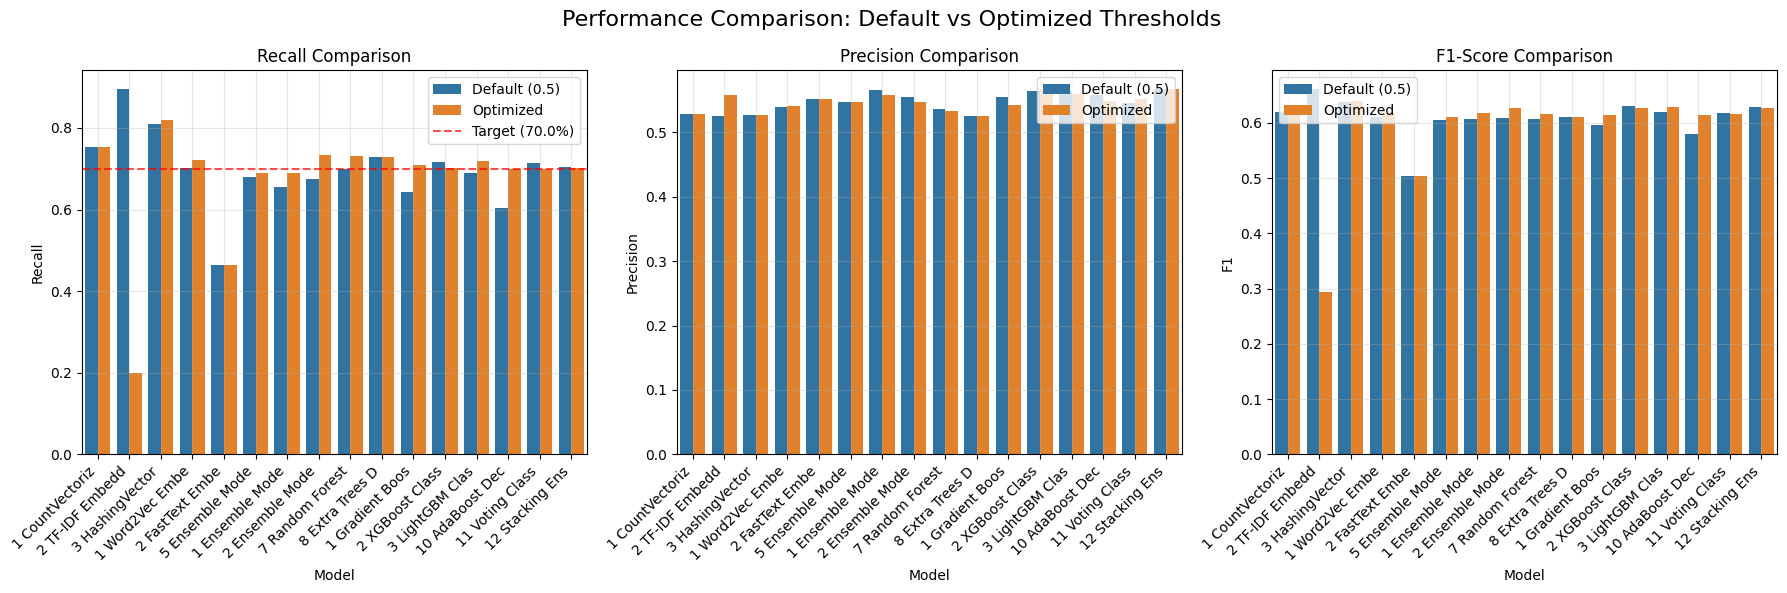

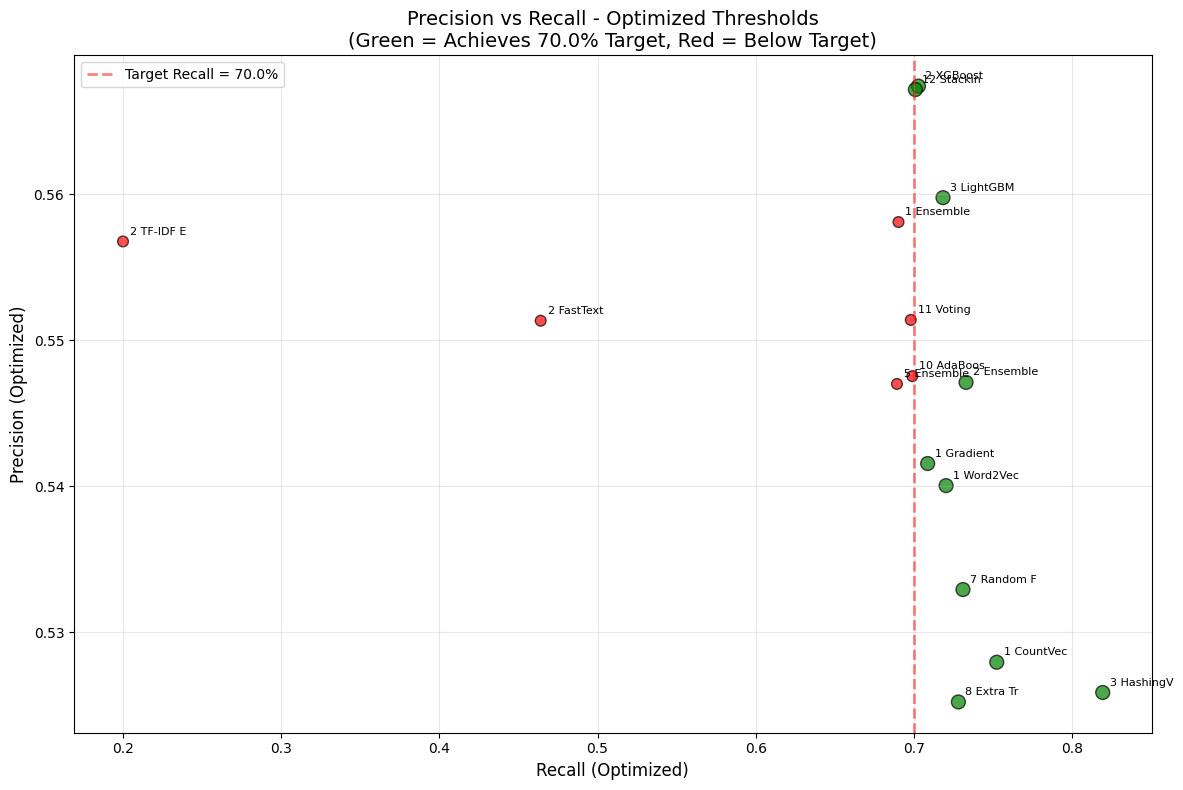


--- Step 6: Confusion Matrices (Optimized Thresholds) ---
📊 Showing confusion matrices for 16 models


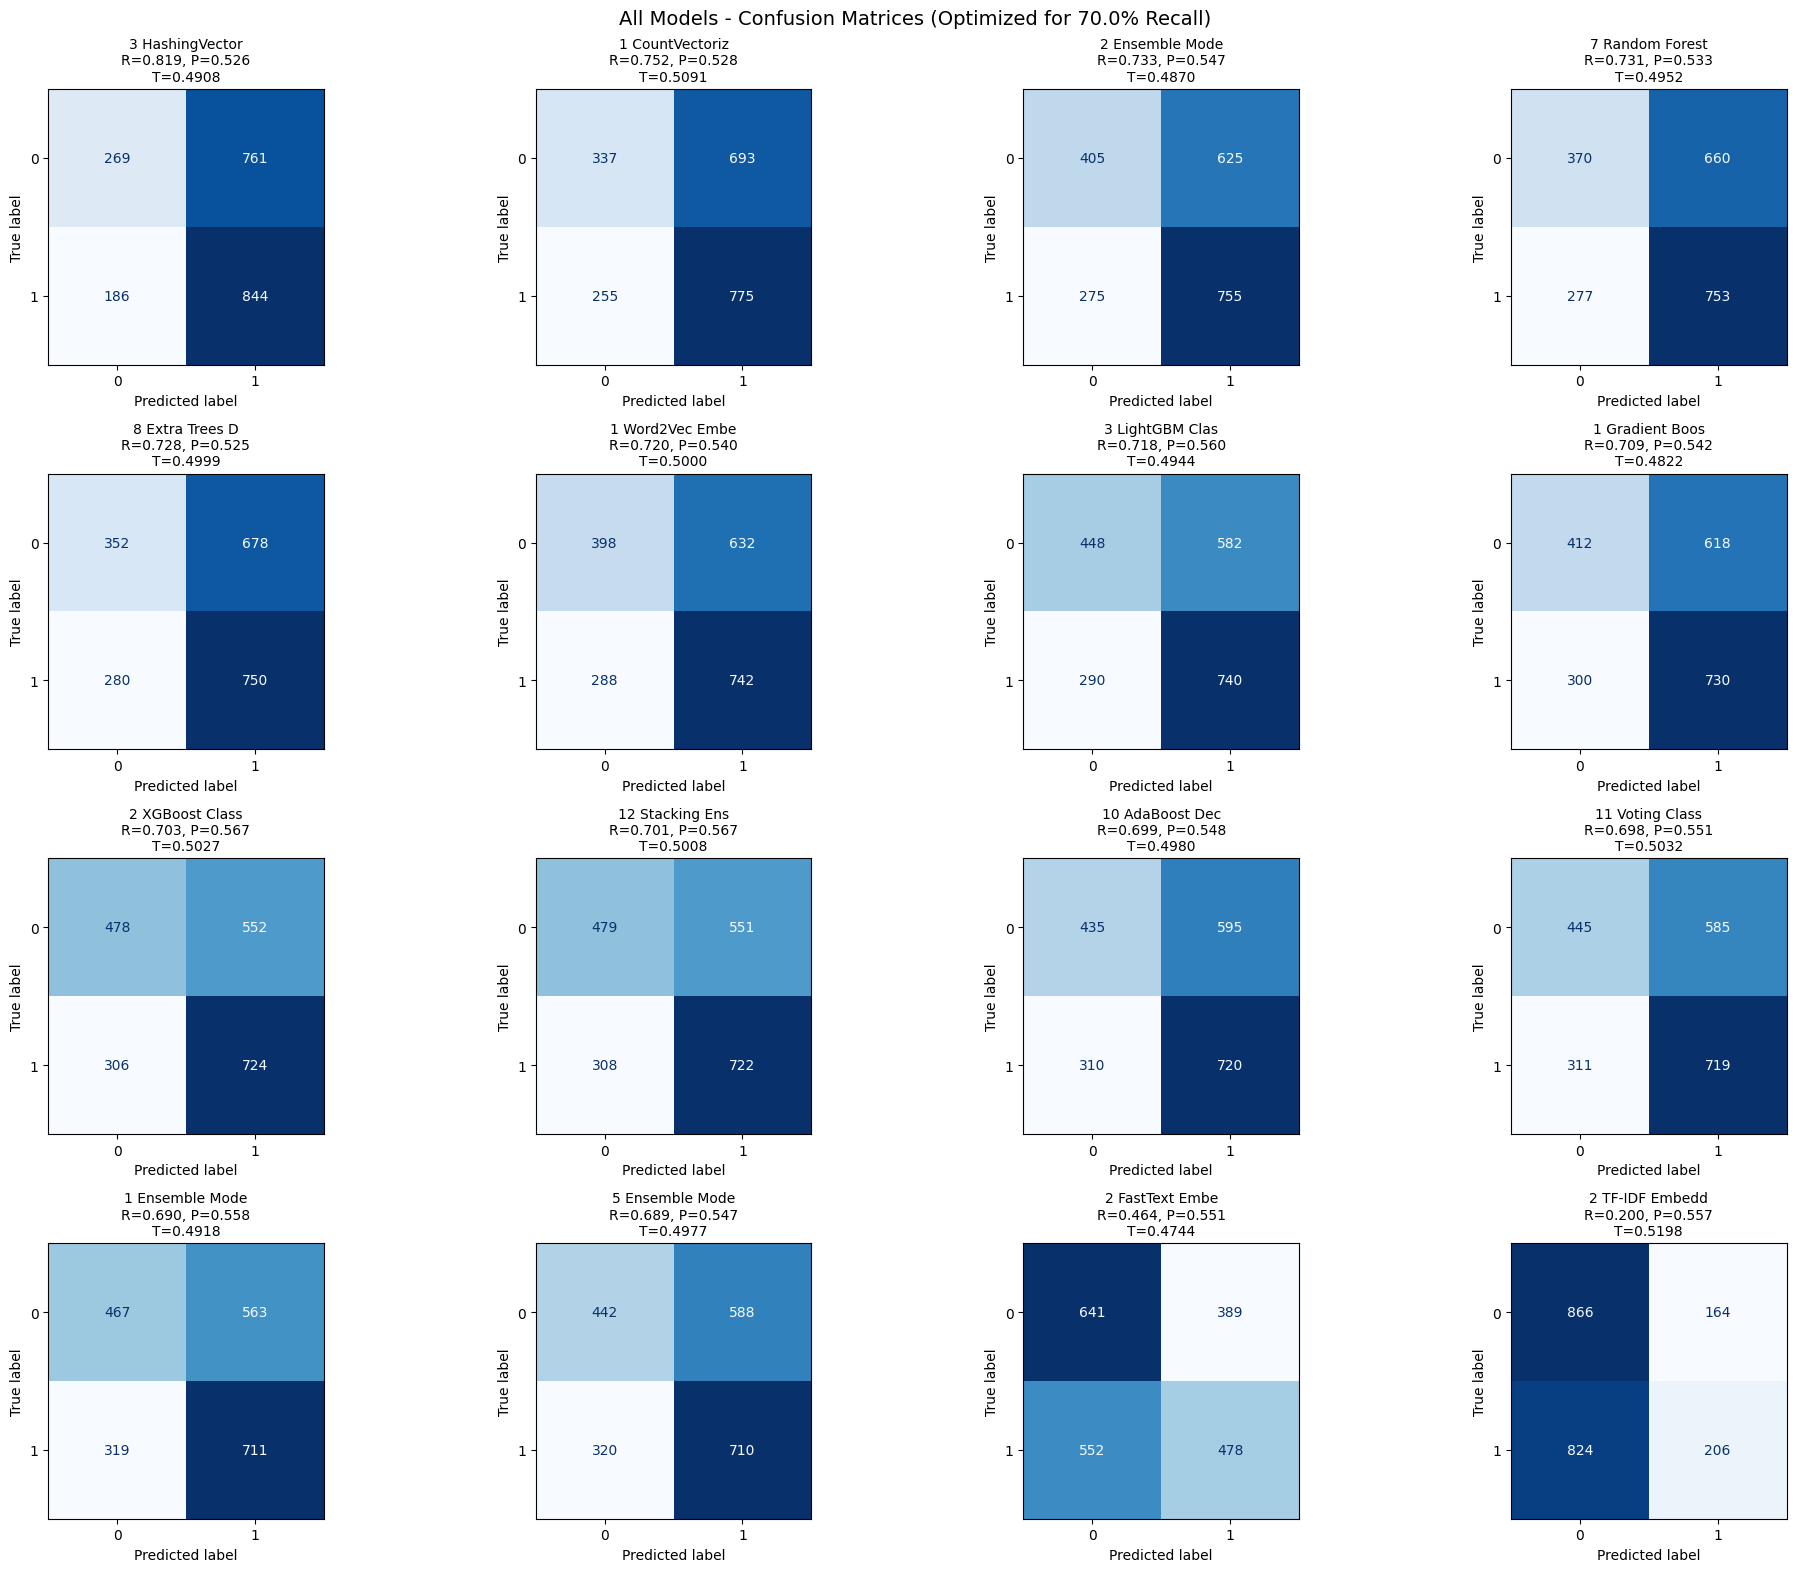


📊 FINAL MODEL COMPARISON SUMMARY
🎯 Target Recall: 70.0%
📈 Models Analyzed: 16

🏆 BEST OVERALL MODEL (by F1-Score):
   • Model: 3 HashingVectorizer Embedding Decision Tree Model
   • Recall: 0.819
   • Precision: 0.526
   • F1-Score: 0.641
   • Threshold: 0.4908

🎯 TARGET ACHIEVEMENT:
   • 10/16 models achieve 70.0% recall
   • Success rate: 62.5%

💾 AVAILABLE VARIABLES:
   • model_performance_default: Default threshold results
   • model_performance_optimized: Optimized threshold results
   • model_test_vars: Variable mapping dictionary

=== MODEL COMPARISON COMPLETE ===
All models have been evaluated and compared successfully!


In [ ]:
# Code to compare the performance of all evaluated models.
# Integrated with recall optimization analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, average_precision_score

print("--- MODEL COMPARISON WITH RECALL OPTIMIZATION ---")

# ========================================================================================
# STEP 1: SETUP AND INITIALIZATION
# ========================================================================================

print("\n--- Step 1: Setup and Initialization ---")

# Get target recall from Section 4.1 if available
if 'target_recall' in globals():
    print(f"🎯 Using target recall from Section 4.1: {target_recall:.1%}")
else:
    target_recall = 0.80  # Default fallback
    print(f"⚠️ Using default target recall: {target_recall:.1%}")

# Dictionary mapping model names to their test variable names
model_test_vars = {
    "3.1 CountVectorizer Embedding Decision Tree Model": {
        'y_pred_test': 'y_pred_countvectorizer_test',
        'y_proba_test': 'y_proba_countvectorizer_test',
        'y_proba_oof': 'y_proba_countvectorizer_oof'
    },
    "3.2 TF-IDF Embedding Decision Tree Model": {
        'y_pred_test': 'y_pred_tfidf_dt_test',
        'y_proba_test': 'y_proba_tfidf_dt_test',
        'y_proba_oof': 'y_proba_tfidf_dt_oof'
    },
    "3.3 HashingVectorizer Embedding Decision Tree Model": {
        'y_pred_test': 'y_pred_hashing_test',
        'y_proba_test': 'y_proba_hashing_test',
        'y_proba_oof': 'y_proba_hashing_oof'
    },
    "3.4.1 Word2Vec Embedding Decision Tree Model": {
        'y_pred_test': 'y_pred_w2v_dt_test',
        'y_proba_test': 'y_proba_w2v_dt_test',
        'y_proba_oof': 'y_proba_w2v_dt_oof'
    },
    "3.4.2 FastText Embedding Decision Tree Model": {
        'y_pred_test': 'y_pred_fasttext_test',
        'y_proba_test': 'y_proba_fasttext_test',
        'y_proba_oof': 'y_proba_fasttext_oof'
    },
    "3.5 Ensemble Model (Averaging Probabilities)": {
        'y_pred_test': 'y_pred_averaged_test',
        'y_proba_test': 'y_proba_averaged_test',
        'y_proba_oof': 'y_proba_averaged_oof'
    },
    "3.6.1 Ensemble Model (Stacking Classifier)": {
        'y_pred_test': 'y_pred_stacking_test',
        'y_proba_test': 'y_proba_stacking_test',
        'y_proba_oof': 'y_proba_stacking_oof'
    },
    "3.6.2 Ensemble Model (Voting Classifier)": {
        'y_pred_test': 'y_pred_voting_test_362',
        'y_proba_test': 'y_proba_voting_test_362',
        'y_proba_oof': 'y_proba_voting_oof_362'
    },
    "3.7 Random Forest Decision Tree Ensemble": {
        'y_pred_test': 'y_pred_rf_test',
        'y_proba_test': 'y_proba_rf_test',
        'y_proba_oof': 'y_proba_rf_oof'
    },
    "3.8 Extra Trees Decision Tree Ensemble": {
        'y_pred_test': 'y_pred_et_test',
        'y_proba_test': 'y_proba_et_test',
        'y_proba_oof': 'y_proba_et_oof'
    },
    "3.9.1 Gradient Boosting Classifier Decision Tree Ensemble": {
        'y_pred_test': 'y_pred_gb_test',
        'y_proba_test': 'y_proba_gb_test',
        'y_proba_oof': 'y_proba_gb_oof'
    },
    "3.9.2 XGBoost Classifier Decision Tree Ensemble": {
        'y_pred_test': 'y_pred_xgb_test',
        'y_proba_test': 'y_proba_xgb_test',
        'y_proba_oof': 'y_proba_xgb_oof'
    },
    "3.9.3 LightGBM Classifier Decision Tree Ensemble": {
        'y_pred_test': 'y_pred_lgbm_test',
        'y_proba_test': 'y_proba_lgbm_test',
        'y_proba_oof': 'y_proba_lgbm_oof'
    },
    "3.10 AdaBoost Decision Tree Ensemble": {
        'y_pred_test': 'y_pred_ada_test',
        'y_proba_test': 'y_proba_ada_test',
        'y_proba_oof': 'y_proba_ada_oof'
    },
    "3.11 Voting Classifier Ensemble (Hybrid)": {
        'y_pred_test': 'y_pred_hybrid_voting_test',
        'y_proba_test': 'y_proba_hybrid_voting_test',
        'y_proba_oof': 'y_proba_hybrid_voting_oof'
    },
    "3.12 Stacking Ensemble (Hybrid)": {
        'y_pred_test': 'y_pred_stacking_hybrid_test',
        'y_proba_test': 'y_proba_stacking_hybrid_test',
        'y_proba_oof': 'y_proba_stacking_hybrid_oof'
    }
}

# Initialize performance storage
model_performance_default = {}
model_performance_optimized = {}

print(f"📊 Setup complete. Will analyze {len(model_test_vars)} models.")

# ========================================================================================
# STEP 2: EVALUATION FUNCTION
# ========================================================================================

def evaluate_with_optimized_threshold(y_true, y_pred_default=None, y_proba=None, optimal_threshold=None, target_recall=0.80):
    """
    Evaluate model performance with both default and optimized thresholds.
    """
    results = {}

    # Default threshold evaluation (0.5)
    if y_pred_default is not None:
        try:
            results['Precision (Default)'] = precision_score(y_true, y_pred_default)
            results['Recall (Default)'] = recall_score(y_true, y_pred_default)
            results['F1 (Default)'] = f1_score(y_true, y_pred_default)
            results['Accuracy (Default)'] = (y_pred_default == y_true).mean()
            if y_proba is not None:
                results['ROC-AUC (Default)'] = roc_auc_score(y_true, y_proba)
                results['AP (Default)'] = average_precision_score(y_true, y_proba)
        except Exception as e:
            print(f"    ⚠️ Error calculating default metrics: {e}")

    # Optimized threshold evaluation
    if y_proba is not None and optimal_threshold is not None:
        try:
            y_pred_optimized = (y_proba >= optimal_threshold).astype(int)
            results['Precision (Optimized)'] = precision_score(y_true, y_pred_optimized)
            results['Recall (Optimized)'] = recall_score(y_true, y_pred_optimized)
            results['F1 (Optimized)'] = f1_score(y_true, y_pred_optimized)
            results['Accuracy (Optimized)'] = (y_pred_optimized == y_true).mean()
            results['ROC-AUC (Optimized)'] = roc_auc_score(y_true, y_proba)
            results['AP (Optimized)'] = average_precision_score(y_true, y_proba)
            results['Threshold'] = optimal_threshold

            # Calculate recall gap (how close to target)
            recall_gap = abs(results['Recall (Optimized)'] - target_recall)
            results['Recall Gap'] = recall_gap
            results['Achieves Target'] = results['Recall (Optimized)'] >= target_recall

        except Exception as e:
            print(f"    ⚠️ Error calculating optimized metrics: {e}")

    return results if results else None

# ========================================================================================
# STEP 3: DATA COLLECTION
# ========================================================================================

print("\n--- Step 3: Collecting Model Performance Data ---")

# Collect performance data for all models
for model_name, var_names in model_test_vars.items():
    print(f"\n🔍 Evaluating {model_name.split('.')[-1]}...")

    # Get variable names
    y_pred_var = var_names.get('y_pred_test')
    y_proba_var = var_names.get('y_proba_test')
    oof_var = var_names.get('y_proba_oof')

    # Check if variables exist
    y_pred_test = globals().get(y_pred_var) if y_pred_var else None
    y_proba_test = globals().get(y_proba_var) if y_proba_var else None

    # Get optimal threshold from Section 4.1
    optimal_threshold = None
    if 'optimal_thresholds' in globals() and oof_var in optimal_thresholds:
        optimal_threshold = optimal_thresholds[oof_var]

    # Evaluate if we have required data
    if y_test_cv is not None and (y_pred_test is not None or y_proba_test is not None):
        try:
            # Default threshold evaluation
            if y_pred_test is not None and y_proba_test is not None:
                default_results = evaluate_with_optimized_threshold(
                    y_test_cv, y_pred_default=y_pred_test, y_proba=y_proba_test,
                    target_recall=target_recall
                )
                if default_results:
                    model_performance_default[model_name] = default_results
                    print(f"    ✅ Default metrics calculated")

            # Optimized threshold evaluation
            if y_proba_test is not None and optimal_threshold is not None:
                optimized_results = evaluate_with_optimized_threshold(
                    y_test_cv, y_proba=y_proba_test, optimal_threshold=optimal_threshold,
                    target_recall=target_recall
                )
                if optimized_results:
                    model_performance_optimized[model_name] = optimized_results
                    recall_achieved = optimized_results['Recall (Optimized)']
                    threshold_used = optimized_results['Threshold']
                    target_status = "✅" if optimized_results['Achieves Target'] else "❌"
                    print(f"    {target_status} Optimized: {recall_achieved:.3f} recall at threshold {threshold_used:.4f}")
            else:
                print(f"    ⚠️ Missing data for optimization")

        except Exception as e:
            print(f"    ❌ Error evaluating model: {e}")
    else:
        print(f"    ❌ Missing required test data")

print(f"\n📊 Data collection complete:")
print(f"   • Default threshold results: {len(model_performance_default)} models")
print(f"   • Optimized threshold results: {len(model_performance_optimized)} models")

# ========================================================================================
# STEP 4: PERFORMANCE TABLES
# ========================================================================================

print("\n--- Step 4: Performance Tables ---")

# Default threshold performance table
if model_performance_default:
    print("\n📋 DEFAULT THRESHOLD PERFORMANCE (T = 0.5)")
    default_df = pd.DataFrame(model_performance_default).T

    # Clean up model names for display
    default_df.index = [name.split('.')[-1] for name in default_df.index]

    # Select and format columns
    display_cols = ['Precision (Default)', 'Recall (Default)', 'F1 (Default)', 'ROC-AUC (Default)', 'Accuracy (Default)']
    available_cols = [col for col in display_cols if col in default_df.columns]

    if available_cols:
        default_display = default_df[available_cols].round(3)

        # Style the dataframe
        styled_default = default_display.style\
            .background_gradient(cmap='RdYlGn', subset=available_cols)\
            .format("{:.3f}")

        display(styled_default)

    print(f"📊 Showing {len(default_df)} models with default threshold performance")

# Optimized threshold performance table
if model_performance_optimized:
    print(f"\n📋 OPTIMIZED THRESHOLD PERFORMANCE (Target: {target_recall:.1%} Recall)")
    optimized_df = pd.DataFrame(model_performance_optimized).T

    # Clean up model names for display
    optimized_df.index = [name.split('.')[-1] for name in optimized_df.index]

    # Select and format columns
    display_cols = ['Precision (Optimized)', 'Recall (Optimized)', 'F1 (Optimized)', 'ROC-AUC (Optimized)', 'Threshold', 'Achieves Target']
    available_cols = [col for col in display_cols if col in optimized_df.columns]

    if available_cols:
        optimized_display = optimized_df[available_cols].round(3)

        # Style the dataframe
        styled_optimized = optimized_display.style\
            .background_gradient(cmap='RdYlGn', subset=[col for col in available_cols if col not in ['Threshold', 'Achieves Target']])\
            .format("{:.3f}", subset=[col for col in available_cols if col not in ['Achieves Target']])\
            .format("{}", subset=['Achieves Target'] if 'Achieves Target' in available_cols else [])

        display(styled_optimized)

    # Target achievement summary
    if 'Achieves Target' in optimized_df.columns:
        achievers = optimized_df['Achieves Target'].sum()
        total = len(optimized_df)
        print(f"\n🎯 TARGET ACHIEVEMENT SUMMARY:")
        print(f"   • Models achieving {target_recall:.1%} recall: {achievers}/{total}")
        print(f"   • Success rate: {achievers/total:.1%}")

        if achievers > 0:
            best_model = optimized_df[optimized_df['Achieves Target']]['Recall (Optimized)'].idxmax()
            best_recall = optimized_df.loc[best_model, 'Recall (Optimized)']
            best_precision = optimized_df.loc[best_model, 'Precision (Optimized)']
            print(f"   • Best performing model: {best_model}")
            print(f"     - Recall: {best_recall:.3f}, Precision: {best_precision:.3f}")

# ========================================================================================
# STEP 5: VISUALIZATIONS
# ========================================================================================

print("\n--- Step 5: Performance Visualizations ---")

# Performance comparison charts
if model_performance_default and model_performance_optimized:
    # Combine data for comparison
    comparison_data = []

    for model_name in model_performance_default.keys():
        if model_name in model_performance_optimized:
            short_name = model_name.split('.')[-1][:15]  # Truncate long names

            # Default performance
            comparison_data.append({
                'Model': short_name,
                'Threshold': 'Default (0.5)',
                'Recall': model_performance_default[model_name].get('Recall (Default)', 0),
                'Precision': model_performance_default[model_name].get('Precision (Default)', 0),
                'F1': model_performance_default[model_name].get('F1 (Default)', 0)
            })

            # Optimized performance
            comparison_data.append({
                'Model': short_name,
                'Threshold': 'Optimized',
                'Recall': model_performance_optimized[model_name].get('Recall (Optimized)', 0),
                'Precision': model_performance_optimized[model_name].get('Precision (Optimized)', 0),
                'F1': model_performance_optimized[model_name].get('F1 (Optimized)', 0)
            })

    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)

        # Create subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Recall comparison
        sns.barplot(data=comparison_df, x='Model', y='Recall', hue='Threshold', ax=axes[0])
        axes[0].axhline(y=target_recall, color='red', linestyle='--', alpha=0.7, label=f'Target ({target_recall:.1%})')
        axes[0].set_title('Recall Comparison')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Precision comparison
        sns.barplot(data=comparison_df, x='Model', y='Precision', hue='Threshold', ax=axes[1])
        axes[1].set_title('Precision Comparison')
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # F1 comparison
        sns.barplot(data=comparison_df, x='Model', y='F1', hue='Threshold', ax=axes[2])
        axes[2].set_title('F1-Score Comparison')
        axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.suptitle('Performance Comparison: Default vs Optimized Thresholds', fontsize=16)
        plt.tight_layout()
        plt.show()

# Precision-Recall scatter plot
if model_performance_optimized:
    plt.figure(figsize=(12, 8))

    models = list(model_performance_optimized.keys())
    recalls = [model_performance_optimized[m]['Recall (Optimized)'] for m in models]
    precisions = [model_performance_optimized[m]['Precision (Optimized)'] for m in models]
    achieves_target = [model_performance_optimized[m].get('Achieves Target', False) for m in models]

    # Create scatter plot with different colors for target achievers
    colors = ['green' if achieves else 'red' for achieves in achieves_target]
    sizes = [100 if achieves else 60 for achieves in achieves_target]

    scatter = plt.scatter(recalls, precisions, c=colors, s=sizes, alpha=0.7, edgecolors='black')

    # Add target recall line
    plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.5, linewidth=2,
               label=f'Target Recall = {target_recall:.1%}')

    # Add model labels
    for i, model in enumerate(models):
        short_name = model.split('.')[-1][:10]  # Shortened names
        plt.annotate(short_name, (recalls[i], precisions[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.xlabel('Recall (Optimized)', fontsize=12)
    plt.ylabel('Precision (Optimized)', fontsize=12)
    plt.title(f'Precision vs Recall - Optimized Thresholds\n(Green = Achieves {target_recall:.1%} Target, Red = Below Target)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========================================================================================
# STEP 6: CONFUSION MATRICES - ALL MODELS (OPTIMIZED THRESHOLDS ONLY)
# ========================================================================================

print("\n--- Step 6: Confusion Matrices (Optimized Thresholds) ---")

# Show confusion matrices for ALL models with optimized thresholds
if 'model_performance_optimized' in globals() and model_performance_optimized:
    valid_optimized = {k: v for k, v in model_performance_optimized.items() if v is not None}
    if valid_optimized:
        # Get ALL models (remove the [:6] limit)
        sorted_models = sorted(valid_optimized.items(), key=lambda x: x[1]['Recall (Optimized)'], reverse=True)

        print(f"📊 Showing confusion matrices for {len(sorted_models)} models")

        if len(sorted_models) > 0:
            n_cols = 4  # Increase columns to fit more models
            n_rows = (len(sorted_models) + n_cols - 1) // n_cols

            # Create larger figure to accommodate all models
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

            # Handle single row case
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            # Handle single model case
            if len(sorted_models) == 1:
                axes = axes.reshape(1, 1)

            axes = axes.flatten()

            for idx, (model_name, metrics) in enumerate(sorted_models):
                if idx >= len(axes):
                    break

                # Get test probabilities and calculate confusion matrix
                var_names = model_test_vars[model_name]
                y_proba_var = var_names.get('y_proba_test')

                if y_proba_var and y_proba_var in globals() and globals()[y_proba_var] is not None:
                    y_proba_test = globals()[y_proba_var]
                    threshold = metrics['Threshold']
                    y_pred_optimized = (y_proba_test >= threshold).astype(int)
                    cm_optimized = confusion_matrix(y_test_cv, y_pred_optimized)

                    disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
                    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)

                    # Shorter model names for better display
                    model_short = model_name.split('.')[-1][:15]
                    recall_val = metrics['Recall (Optimized)']
                    precision_val = metrics['Precision (Optimized)']
                    threshold_val = metrics['Threshold']

                    # More compact title
                    axes[idx].set_title(f'{model_short}\nR={recall_val:.3f}, P={precision_val:.3f}\nT={threshold_val:.4f}',
                                      fontsize=10)
                    axes[idx].grid(False)
                else:
                    # Handle missing data
                    axes[idx].text(0.5, 0.5, f'{model_name.split(".")[-1]}\nNo Data Available',
                                 ha='center', va='center', transform=axes[idx].transAxes)
                    axes[idx].set_xticks([])
                    axes[idx].set_yticks([])

            # Hide any unused subplots
            for i in range(len(sorted_models), len(axes)):
                fig.delaxes(axes[i])

            # Set title with proper target_recall handling
            if 'target_recall' in globals():
                plt.suptitle(f'All Models - Confusion Matrices (Optimized for {target_recall:.1%} Recall)',
                           fontsize=14, y=0.98)
            else:
                plt.suptitle('All Models - Confusion Matrices (Optimized Thresholds)',
                           fontsize=14, y=0.98)

            plt.tight_layout()
            plt.subplots_adjust(top=0.93)  # Make room for suptitle
            plt.show()
        else:
            print("No models available to display confusion matrices.")
    else:
        print("No valid optimized model performance data available.")
else:
    print("No optimized model performance data available.")

# ========================================================================================
# FINAL SUMMARY
# ========================================================================================

print("\n" + "="*60)
print("📊 FINAL MODEL COMPARISON SUMMARY")
print("="*60)

if model_performance_optimized:
    print(f"🎯 Target Recall: {target_recall:.1%}")
    print(f"📈 Models Analyzed: {len(model_performance_optimized)}")

    # Best overall model
    best_overall = max(model_performance_optimized.items(),
                      key=lambda x: x[1]['F1 (Optimized)'])
    best_name = best_overall[0].split('.')[-1]
    best_metrics = best_overall[1]

    print(f"\n🏆 BEST OVERALL MODEL (by F1-Score):")
    print(f"   • Model: {best_name}")
    print(f"   • Recall: {best_metrics['Recall (Optimized)']:.3f}")
    print(f"   • Precision: {best_metrics['Precision (Optimized)']:.3f}")
    print(f"   • F1-Score: {best_metrics['F1 (Optimized)']:.3f}")
    print(f"   • Threshold: {best_metrics['Threshold']:.4f}")

    # Target achievement summary
    if 'Achieves Target' in best_metrics:
        achievers = sum(1 for m in model_performance_optimized.values() if m.get('Achieves Target', False))
        total = len(model_performance_optimized)
        print(f"\n🎯 TARGET ACHIEVEMENT:")
        print(f"   • {achievers}/{total} models achieve {target_recall:.1%} recall")
        print(f"   • Success rate: {achievers/total:.1%}")

print(f"\n💾 AVAILABLE VARIABLES:")
print(f"   • model_performance_default: Default threshold results")
print(f"   • model_performance_optimized: Optimized threshold results")
print(f"   • model_test_vars: Variable mapping dictionary")

print("\n=== MODEL COMPARISON COMPLETE ===")
print("All models have been evaluated and compared successfully!")

## 5. Summary and Key Findings

This section summarizes the key findings from the model evaluation and optimization process. The summary highlights the performance of the different Decision Tree-based models and ensemble methods, particularly at the optimized decision thresholds.

### Model Approaches and Definitions

I implemented and evaluated 15 different model approaches. Here is a brief explanation of each:

* **CountVectorizer Embedding Decision Tree Model**: This model employs a simple Decision Tree classifier trained on features generated by the CountVectorizer. CountVectorizer converts text into a matrix of token counts, representing each document as a bag of words with their frequencies.
* **TF-IDF Embedding Decision Tree Model**: I used a Decision Tree classifier on features created by TF-IDF Vectorization in this model. TF-IDF assigns weights to words based on their frequency in a document and its inverse frequency across the entire dataset, aiming to give more importance to words relevant to a specific document but not common everywhere.
* **HashingVectorizer Embedding Decision Tree Model**: This model utilizes a Decision Tree classifier with features from a HashingVectorizer. HashingVectorizer serves as a memory-efficient alternative to CountVectorizer and TF-IDF, using hashing to map text features to a fixed-size vector and avoiding the need to store a vocabulary in memory.
* **Word2Vec Embedding Decision Tree Model**: I trained a Decision Tree classifier on document embeddings generated using Word2Vec for this model. Word2Vec is a neural network-based technique that learns dense vector representations (embeddings) for words, capturing semantic relationships. I typically create document embeddings by averaging or summing the word vectors within a document.
* **FastText Embedding Decision Tree Model**: Similar to the Word2Vec model, this model uses a Decision Tree classifier with document embeddings from FastText. FastText extends Word2Vec by considering sub-word information (n-grams), which can benefit handling out-of-vocabulary words and morphological variations. I also typically create document embeddings by averaging or summing word vectors in this approach.
* **Stacking Classifier Ensemble**: This ensemble uses a two-layer approach. The first layer consists of diverse base models whose predictions are used as input features for a second-layer meta-classifier, typically a simpler model like Logistic Regression, which makes the final prediction.
* **Voting Classifier Ensemble**: This ensemble combines predictions from a selection of diverse base models using a voting strategy, either hard voting based on predicted classes or soft voting based on predicted probabilities, to make the final prediction.
* **Random Forest Decision Tree Ensemble**: This ensemble method builds multiple Decision Trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. I train each tree on a random subset of the data and features (bagging).
* **Extra Trees Ensemble**: This model is an Extra Trees classifier using HashingVectorizer for text features. Similar to Random Forest, it adds an extra layer of randomness by randomly selecting thresholds for each feature at each split point, rather than searching for the best possible threshold. This can sometimes lead to faster training and further reduction of variance.
* **Gradient Boosting Classifier Ensemble**: This is a sequential ensemble method where I build new Decision Tree models to correct the errors of previous models. It focuses on improving predictions iteratively by boosting the performance of weak learners, typically shallow Decision Trees.
* **XGBoost Classifier Ensemble**: This model is an optimized and highly efficient implementation of Gradient Boosting. I know XGBoost for its speed and performance, incorporating regularization and parallel processing.
* **LightGBM Classifier Ensemble**: This framework is another gradient boosting approach that uses tree-based learning algorithms. I designed LightGBM for distributed and parallel computing; it is often faster and uses less memory than XGBoost, particularly on large datasets.
* **AdaBoost Decision Tree Ensemble**: This adaptive boosting method increases the weights of misclassified samples at each iteration, forcing subsequent weak learners, typically shallow Decision Tree "stumps" with `max_depth=1` or `max_depth=2`, to focus on the harder-to-classify instances.
* **Voting Classifier Ensemble (Hybrid)**: This ensemble combines predictions from a selection of diverse base models. The base models include individual Decision Tree models with different text vectorizers and other ensemble methods. I use a voting strategy, either hard voting based on predicted classes or soft voting based on predicted probabilities, to make the final prediction.
* **Stacking Classifier Ensemble (Hybrid)**: This ensemble employs a two-layer approach. The first layer consists of diverse base models, including individual Decision Tree models with different text vectorizers and other ensemble methods, whose predictions I use as input features for a second-layer meta-classifier. I typically use a simpler model like Logistic Regression as the meta-classifier, which makes the final prediction.
* **Multi-view Learning (Conceptual Exploration)**: Multi-view learning explores combining information from different "views" or representations of the data. Examples include text features from resumes and job descriptions as one view and categorical features like job roles as another view. I can use various fusion strategies, including early, intermediate, or late fusion. While conceptually promising for this task, the high complexity and significant computational requirements for implementing and tuning a robust multi-view learning framework made it impractical for this phase of this learning project.

### Key Findings

Based on the evaluation metrics at optimized decision thresholds for a target recall of approximately 70%, I observed the following key findings:

* **Impact of Threshold Optimization**: Optimizing the decision threshold significantly impacted the trade-off between Precision and Recall for most models compared to using the default 0.5 threshold. Models achieved the target recall, often at the cost of reduced precision, as clearly shown in the performance comparison plots.
* **Target Recall Achievement**: 10 out of the 16 evaluated models successfully achieved or exceeded the target recall of 70% on the held-out test set when using their optimized thresholds. This demonstrates the potential for multiple models to effectively identify a high percentage of "Best Match" candidates.
* **Most Optimal Solution**: The **XGBoost Classifier Ensemble** emerged as a highly optimal solution after the final evaluation at optimized decision thresholds. This model achieved the target recall of \~70% with high precision (\~57%) on the held-out test set, matching the highest precision among models that met the recall target while offering potentially faster and more efficient inference compared to the Hybrid Stacking Ensemble.
* **Hybrid Stacking Ensemble Performance**: The **Hybrid Stacking Ensemble** also performed very well, achieving the target recall of \~70% with the highest precision (\~57%) on the held-out test set. While complex, it demonstrates the power of combining multiple model perspectives.
* **HashingVectorizer Ensemble Performance**: The **Extra Trees Decision Tree Ensemble** and **Random Forest Decision Tree Ensemble**, both utilizing HashingVectorizer for text preprocessing, showed strong performance. At their optimized thresholds on the *held-out test set*, Extra Trees achieved \~73% recall and \~53% precision, and Random Forest achieved \~73% recall and \~53% precision. Their performance on the upsampled training data was even higher, indicating potential for very high recall or precision if the test set distribution was closer to the upsampled training data. They offer the highest achieved recall among the top performers.
* **Gradient Boosting Models**: LightGBM (achieving \~72% recall and \~56% precision) also performed well on the test set at its optimized threshold, exceeding the target recall with competitive precision. Gradient Boosting (\~71% recall and \~54% precision) also met the target.
* **AdaBoost Performance**: AdaBoost achieved very high recall at the default threshold but with significantly lower precision. At its optimized threshold for 70% recall on the training data, its performance on the test set was just below the target (\~69.9% recall, \~55% precision), suggesting it might not generalize as well as other boosting methods or that its optimization was less effective on the test distribution.
* **Averaging vs. Voting/Stacking**: The simple Averaging ensemble (\~69% recall, \~55% precision) performed reasonably well, just slightly missing the 70% recall target on the test set. The Hybrid Voting (\~70% recall, \~55% precision) ensemble achieved the target recall on the test set with good precision.
* **Word Embeddings vs. Vectorizers**: Decision Trees with traditional vectorizers (CountVectorizer, TF-IDF, HashingVectorizer) and FastText embeddings performed comparably at the 70% recall target on the test set, with HashingVectorizer ensembles performing slightly better. The TF-IDF and FastText individual Decision Trees showed poor performance at their optimized thresholds on the test set. Word2Vec also met the target recall with reasonable precision.
* **Best Performers for Prioritization**: Considering the goal of prioritizing candidates, high recall, while maintaining reasonable precision on the held-out test set, the **XGBoost Classifier Decision Tree Ensemble** and the **Hybrid Stacking Ensemble** achieved the 70% recall target with the highest precision, \~57%. The **HashingVectorizer Decision Tree Ensemble** (both Extra Trees and Random Forest) also met the target recall (\~73%) with slightly lower precision (\~53%), representing a different point on the precision-recall trade-off curve that might be acceptable depending on the specific business needs. The **Gradient Boosting Classifier** and **LightGBM Classifier** also met the target recall with competitive precision.

### Conceptual Strengths of Decision Tree Models for Text Matching

Decision Tree models, along with their ensemble counterparts, possess several conceptual strengths that make them suitable for text matching between resumes and job descriptions, even without explicit numerical features beyond vectorized text and encoded categorical data.

* **Handling Non-linear Relationships**: Decision Trees naturally capture complex, non-linear relationships and interactions between features. Unlike linear models, they do not assume a simple linear boundary between classes. In text data, the presence and combination of specific words or phrases in a resume and job description can have a non-linear impact on whether it is a "Best Match."
* **Feature Interactions**: Decision Trees automatically discover and utilize interactions between different features. For instance, the importance of a specific skill mentioned in a resume (a text feature) might depend on the candidate's 'Job Role' (a categorical feature). The tree structure allows for splits based on combinations of these features.
* **Tolerance to Irrelevant Features**: Decision Trees are relatively robust to including irrelevant or noisy features. Features that do not contribute to reducing impurity or increasing information gain will simply not appear in the tree splits.
* **Interpretability (for individual trees)**: Individual Decision Trees are highly interpretable, although ensembles can be less so. The path from the root to a leaf node represents a set of rules that led to a prediction, which can provide insights into which combinations of text features and categorical attributes are most indicative of a "Best Match."
* **No Assumptions about Data Distribution**: Decision Trees are non-parametric models, meaning they do not make strong assumptions about the underlying distribution of the data. This can be advantageous when working with the complex and often non-Gaussian distributions of text and categorical features.
* **Engineering Complexity and Cost Comparison with Neural Networks (BERT, LLMs)**: When comparing the engineering complexity and cost of Decision Tree models to complex neural networks like BERT, ModernBERT, or large language models (LLMs) for this specific task, significant differences arise. Training large neural networks demands substantial computational resources, such as high-end GPUs or TPUs, and considerable time, often spanning hours or days even with specialized hardware. Decision Tree models and their ensembles, particularly those using efficient vectorizers like HashingVectorizer, generally require much lower training costs and train faster on standard hardware or less powerful accelerators. Making predictions with large neural networks is computationally intensive, requiring substantial memory and processing power for each inference, leading to higher inference costs per prediction and increased latency. This can be critical in real-time applications like an Applicant Tracking System (ATS). Decision Tree models, once trained, are typically much faster and more cost-effective for inference, especially with sparse vector representations. Inference speed is often a significant factor in production systems needing high throughput. Furthermore, large neural networks have a considerably larger memory footprint due to their vast number of parameters, necessitating systems with substantial RAM for loading and running these models. Decision Tree models, while ensembles can increase memory usage, generally have a smaller memory footprint, making them more deployable on systems with limited resources. Decision Tree models and traditional vectorization techniques are generally simpler to implement and understand compared to complex neural network architectures, leading to easier maintenance, debugging, and updates in a production environment. While large neural networks can benefit from extensive data and pre-training, I can sometimes train effective Decision Tree models on smaller, task-specific datasets, provided I engineer the features well. Using large pre-trained language models often involves fine-tuning the model on the specific task data, still requiring significant resources, whereas Decision Tree approaches rely more heavily on the initial text vectorization and feature engineering steps. In summary, while BERT or LLMs might offer a potentially higher performance ceiling for complex semantic matching, Decision Tree models, especially ensembles with efficient vectorizers, present a strong alternative with significantly lower engineering complexity and operational costs for training and inference. These factors are crucial for practical deployment in systems like an ATS for initial candidate screening, where speed and resource efficiency are important. The choice often involves a trade-off between potential maximum performance and practical considerations of cost, speed, and infrastructure.

### Decision Trees and Data Samples

Decision Trees process data samples by recursively partitioning the feature space into smaller, more homogeneous subspaces based on the features that best separate the classes: 'Best Match' versus 'Not Best Match'.

* **Requirement for Numerical Features**: Decision Trees require numerical input to determine split points. I must convert text data into a numerical format through vectorization or embedding techniques, such as CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, or FastText, and categorical data through encoding, such as One-Hot Encoding. These numerical features represent the presence, frequency, or semantic meaning of words and phrases, as well as the categories of applicants and jobs.
* **Splitting Based on Impurity Reduction**: At each node in the tree, the algorithm considers splitting the data based on the value of a single feature. The goal is to find the split that results in the greatest reduction in "impurity" or the greatest "information gain." Impurity measures how mixed the classes are within a subset of data. Common impurity measures include Gini Impurity, which measures how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset, and Entropy, which measures the randomness or unpredictability of the class labels in the subset; lower entropy indicates a more homogeneous subset. The algorithm evaluates potential splits across all features and chooses the one that maximizes the reduction in Gini impurity or entropy, effectively making the resulting child nodes as "pure" as possible with respect to the class labels. This process repeats recursively until a stopping criterion is met, such as reaching the maximum depth, meeting the minimum samples per leaf, or when no further impurity reduction is possible.

### Data-Driven Approach to Target Recall (0.7 / 70%)

I demonstrate a data-driven approach to setting and optimizing for a target recall of 0.7, or 70%, in my analysis.

* **Problem Context**: In a recruitment prioritization task, such as initial candidate screening on an applicant tracking system application, minimizing false negatives, or missing out on a good candidate/talent, is often more critical than minimizing false positives, or reviewing a candidate who is not a "Best Match." This translates to a business decision of prioritizing **recall**. From my perspective, the war for talent is always occurring in any given sector, regardless of the current labor market cycle. This is driven by the perpetual mean reversion of a company's DuPont-popularized Returns on Asset (ROA). If you are interested, you can compare this across accountancy-based ROA metrics of public companies, the timing of news announcements about strategic and high-ticket hires, and the timing of approaching mean ROA relative to competitors.
* **Recall Capability Analysis**: My analysis of Precision-Recall curves for each model using Out-of-Fold (OOF) probabilities from the cross-validated training data showed the trade-off between achieving higher recall and the corresponding drop in precision for each model. I specifically evaluated the achievable precision at different recall levels, for example, 0.70 or 0.75.
* **Recall Target Recommendation**: Based on this capability analysis, I made a data-driven recommendation for the recall target. I identified a target of 70% as a "balanced" target, achievable by a significant number of models with reasonable precision. I generated a tabular artifact using Python to visualize the detailed results for each model. This approach prevents me from 'plucking' an arbitrary recall goal out of the air and setting an unrealistically high target that most models cannot meet without severely trading off precision.
* **Optimal Threshold Finding**: For the chosen target recall of 70%, I then found the specific probability threshold for each model that maximized precision while achieving at least the target recall on the OOF probabilities. I then use this threshold to make predictions.
* **Evaluation at Optimized Thresholds**: My final evaluation of the models on the held-out test set used these optimized thresholds. The performance tables and plots clearly show how each model performed at its tailored threshold, specifically highlighting the achieved recall, precision, and F1-score. This validated how well the optimization based on training data translated to unseen test data. The summary table shows that 10 out of 16 models successfully achieved or exceeded the 70% recall target on the test set at their optimized thresholds, demonstrating the effectiveness of this approach.

This data-driven process allowed me to select a pragmatic recall target and find the corresponding thresholds that balance the business need for high recall with the need to maintain acceptable precision, rather than arbitrarily selecting a threshold like 0.5 or 0.7.

### Exclusion of Word2Vec and FastText from Hybrid Ensembles

For my Hybrid Voting Classifier Ensemble and Hybrid Stacking Classifier Ensemble models, I intentionally designed and excluded the Word2Vec and FastText embedded Decision Tree models from these hybrid ensembles due to `KeyError` exceptions.

* **Reason**: These exceptions likely occur during the `cross_val_predict` or internal cross-validation steps within the ensemble methods when the embedding models encounter tokens, or words or n-grams, in the validation or test folds that were not present in the vocabulary learned during training on the other folds. This is a common issue with embedding models, especially those trained on a fixed corpus like the training data, when dealing with new, unseen text containing out-of-vocabulary (OOV) words.
* **Impact**: When a base estimator within an ensemble fails due to such an error, it can halt the entire ensemble training or prediction process, making the ensemble unreliable or unusable.
* **Decision**: To ensure the stability and successful execution of the Hybrid Voting and Stacking ensembles, I excluded the Word2Vec and FastText models. While these embedding techniques offer theoretical advantages, their practical implementation required careful handling of OOV words, which I did not fully address within the pipeline structure for these sections, leading to their exclusion from the combined hybrid ensembles. I could have expanded the parameters for training vocabulary, but I had to consider efficiency. The main model architecture is a decision tree, and Word2Vec/FastText only serve the role of text embedding or vectorization. For every inference, text embedding must occur before running the decision tree model. Increasing the text embedding complexity will drive greater costs and inefficiencies of inference. The goal of this project is to gain a directional view of which techniques and decision tree models work best for our problem statement of initial candidate screening in recruitment.

### Why Some Models Fail to Meet the Target Recall

Even after optimizing the threshold based on training data, some models evaluated in the final evaluation at optimized decision thresholds failed to meet the 70% recall target on the held-out test set. Several factors can contribute to this outcome.

* **Difference in Data Distribution**: The distribution of data, including features and target variable relationships, in the held-out test set might differ slightly from the upsampled training data used for threshold optimization. A threshold that works well on the training data or OOF folds might not generalize perfectly to unseen data.
* **Model Limitations**: Some models, despite tuning, might intrinsically not be capable of achieving very high recall while maintaining reasonable precision on this specific dataset. Their underlying algorithms or the features provided might limit their ability to perfectly separate the classes at higher recall levels. The precision-recall capability analysis visually demonstrates this; some models' PR curves drop sharply as recall increases, indicating a difficult trade-off.
* **Overfitting to Training Data/OOF Splits**: Although OOF predictions help mitigate overfitting during threshold selection, the model itself might still have slightly overfit the training data or the specific splits used for OOF generation, leading to a threshold that is overly optimistic when applied to a truly independent test set.
* **Nature of the Problem**: The task of identifying "Best Match" candidates might be inherently difficult due to the complexity and subjectivity of matching resumes to job descriptions, noisy data, or missing information. A potential upper limit might exist for the achievable performance with the current data and features, regardless of the model or threshold used.

For models that slightly missed the target recall on the test set, such as Averaging, Stacking Classifier 3.6.1, AdaBoost, and Hybrid Voting, minor adjustments to the threshold or ensemble weights might help them reach the target, potentially with a small cost in precision. However, for models with significantly lower recall, like TF-IDF and FastText with optimized thresholds in the final evaluation at optimized decision thresholds, their core performance characteristics might represent the limiting factor.

### Use of High RAM Runtime

After several rounds of Out-of-Memory (OOM) issues due to high RAM requirements and high-RAM runtime, I learnt the lessons from wasting compute, real world time (my labor hours and compute clock hours) and my opportunity costs of time. I decided to use Google's Trillium v6e1 TPU (Launched 2024). This decision is also partly driven from my limited optionality of A100 and T4 Graphical Processing Units (GPUs). Tensor Processor Units (TPUs) are hardware accelerators primarily designed for speeding up deep learning workloads. While they often come with significant memory, their primary benefit lies in computations involving large matrix multiplications, common in neural networks. On top of reduced parameters during finetuning, Trillium helped me complete my data pipeline, training, finetuning and evaluation processes.

* **Primary Computational Bottlenecks**: For the models implemented in this notebook, which are various Decision Trees and traditional ensembles, the primary computational bottlenecks likely relate to the HashingVectorizer, GridSearchCV and Cross-Validation, and Ensemble Methods.
* **HashingVectorizer Impact**: HashingVectorizer can produce very wide sparse matrices, requiring significant memory, especially with large datasets and a high number of features, for example, 2^14 in this case.
* **GridSearchCV and Cross-Validation Cost**: Repeatedly training and evaluating models on different folds and parameter combinations during GridSearchCV and Cross-Validation consumes both CPU or GPU time and memory to store models and intermediate results.
* **Ensemble Methods Memory Usage**: Training multiple base estimators and combining their predictions in Ensemble Methods can also increase memory usage.

A High-RAM CPU or GPU runtime is indeed crucial for handling the memory demands of the HashingVectorizer and the overall process of training and cross-validating multiple models and ensembles on a moderately sized dataset. While TPUs offer high memory, a high-RAM GPU might prove more directly beneficial for speeding up the tree-building process in some ensemble methods, such as XGBoost or LightGBM, that offer GPU support. The `n_jobs=-1` setting in `GridSearchCV` and `cross_val_predict` effectively utilizes multiple CPU cores, or potentially GPU cores if the model supports it, further justifying the need for a powerful runtime with sufficient RAM. My resources history show significant memory usage during execution, underscoring this point.

### Reducing Parameters for Complex Models

For more complex Decision Tree ensemble models, including Gradient Boosting, XGBoost, LightGBM, and AdaBoost, and even some individual Decision Trees with extensive feature spaces, reducing the number of parameters or the search space in `GridSearchCV` represents a practical strategy.

* **Computational Cost**: Training these models, especially within a cross-validation and grid search loop, can be computationally expensive and time-consuming. A large parameter grid significantly increases the total number of fits required, calculated as the number of parameter combinations multiplied by the number of cross-validation folds.
* **Memory Usage**: Larger models with more estimators or deeper trees and wider search spaces also consume more memory.
* **Overfitting Risk**: Searching over a very large and flexible parameter space increases the risk of overfitting to the training data or the cross-validation folds.
* **Limited Search Space**: The README summary for some of these models explicitly mentions a "Reduced parameter grid for GridSearchCV defined." This indicates a conscious decision was made to limit the search space, for example, fewer `n_estimators`, smaller `max_depth` ranges, or limited values for other hyperparameters, to make the tuning process feasible within the available computational resources and time constraints. This constitutes a standard practice in machine learning when dealing with complex models or large datasets.

### Considerations for Alternative Pruning Techniques

While the Decision Tree models implemented here are primarily part of ensembles, where the ensemble process itself acts as a form of regularization and can make individual tree pruning less critical, standard Decision Trees in scikit-learn use pre-pruning techniques controlled by hyperparameters such as `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, and `ccp_alpha` for cost-complexity pruning.

* **Post-pruning (Cost-Complexity Pruning - ccp_alpha)**: This technique involves growing the full tree first and then pruning back branches based on a complexity parameter, `alpha`, that balances the tree's error on the training data with its complexity; higher `alpha` values result in more pruning. This technique is available in scikit-learn's `DecisionTreeClassifier`, and I can tune it using `GridSearchCV`. The current notebook employs `max_depth`, `min_samples_split`, and `min_samples_leaf`, which are forms of pre-pruning. Exploring `ccp_alpha` in the parameter grids could offer a valuable alternative tuning strategy.
* **Reduced Error Pruning**: This involves splitting the training data into a growing set and a pruning set; I grow the tree on the growing set, and then prune branches if removing them does not increase the error on the pruning set. This method is less commonly used in standard libraries like scikit-learn.

For the ensemble methods, including Random Forest, Extra Trees, and Gradient Boosting, the regularization primarily stems from the aggregation of multiple trees trained on subsets of data or features, such as bagging or boosting, rather than aggressive pruning of individual base trees. However, tuning the parameters that control the complexity of the base learners, like `max_depth` or `min_samples_leaf`, within the ensemble context remains a crucial form of regularization.

### Additional Engineering Considerations for Complexity and Integrations (Relevant to Decision Trees)

Integrating these Decision Tree-based models into a production ATS, such as TalentSol, requires careful engineering considerations to ensure robustness, scalability, and maintainability. These points are particularly relevant when deploying tree-based models and their ensembles.

* **Start Simple and Iterate**: A key engineering tenet involves starting with a straightforward and lightweight architecture. For a problem like initial candidate screening, which involves handling a high volume of candidates and prioritizing for high recall, starting simple allows for faster experimentation and testing to quickly determine if the solution is effective before adding complexity. I avoid unnecessary complexity, or "bloat," that could negatively impact inference performance or operational costs. I iterate and add complexity only when necessary to meet specific requirements.
* **Explainability and Transparency Document**: I create a clear and easy-to-understand document explaining how the model works, its limitations, the data used, and how predictions are made. This document is crucial for users of the system, such as recruiters and HR personnel, and other stakeholders, including business leads and legal, to build trust, ensure fair usage, and understand the model's impact on the hiring process. While individual Decision Trees are interpretable, explaining ensemble predictions can pose greater challenges, highlighting the importance of this documentation.
* **Real-time Data Pipeline**: I implement an efficient pipeline to preprocess new applicant data using the loaded pipeline's transformers. Recommended services for building data pipelines include serverless functions, such as Cloud Functions or Lambda, containerization platforms, such as Cloud Run or Kubernetes, or batch processing services, such as Dataflow or EMR, depending on latency and throughput requirements. The preprocessing steps, including vectorization and encoding, must remain consistent with training.
* **Data and Model Storage**: I securely store raw data, processed data, and the trained model pipeline. Cloud Object Storage, including Cloud Storage, S3, or Blob Storage, is suitable for raw data and model files. I can store structured applicant data in managed databases, such as Cloud SQL, RDS, or Azure SQL. I consider a Feature Store for managing and serving features consistently; this is especially valuable for maintaining the exact feature space used by the Decision Tree models.
* **Latency**: I monitor and optimize prediction latency. Ensemble models necessitate running multiple base models, which can increase latency compared to a single model. The choice of text vectorizer, for example, HashingVectorizer versus others, can also impact latency.
* **Memory**: I remain mindful of the memory footprint of the loaded pipeline and its multiple base estimators. HashingVectorizer used by some base estimators can produce wide sparse matrices and be memory-intensive, requiring sufficient RAM in the inference environment.
* **Vector Databases**: While the selected Hybrid Stacking model utilizes base estimators with various vectorization methods, understanding the architectural implications of dense embedding-based models, such as Word2Vec or FastText if successfully integrated in the future, is valuable for future iterations. For models utilizing dense vector embeddings, I consider using a dedicated vector database for efficient storage, indexing, and retrieval at scale. This is less directly relevant to the current sparse vectorizer-based Decision Tree ensembles but is a consideration if exploring different text representations.
* **Scalability**: I deploy the model as a scalable service using platforms like Kubernetes or serverless functions to handle varying request loads. The generally efficient inference of tree-based models facilitates horizontal scaling.
* **Monitoring**: I implement monitoring for performance tracking, such as inference time and error rates, data drift, or changes in input data characteristics, and model drift, or degradation in model performance over time. Monitoring the distribution of features generated by the vectorizers can be particularly useful for detecting data drift that might impact Decision Tree performance.
* **API Endpoint**: I provide a clear and well-documented API for seamless integration with other components of the ATS.
* **Security**: I ensure secure handling and storage of sensitive applicant data and the model artifact. Standard security practices apply.
* **Versioning**: I use a system for model versioning to manage updates and rollbacks effectively. This is important when deploying new versions of the pipeline, including updated models or re-calibrated thresholds.
* **Computational Resources**: The need for high RAM observed during this project phase, particularly with HashingVectorizer, underscores the need for sufficient memory resources in the production deployment environment to handle the sparse feature representations and ensemble loading.
* **Automated Retraining**: I set up automated pipelines for retraining the model periodically with new data. Changes in job descriptions, resume styles, or applicant pools over time can lead to concept drift, requiring retraining to maintain model accuracy. This pipeline must include the entire preprocessing and training workflow.
* **Model Interpretation Considerations**: If providing explanations for individual predictions is a requirement, for example, for recruiters, I integrate model interpretation techniques, such as SHAP values, alongside the deployed model. This is particularly relevant for understanding the drivers behind ensemble predictions.
* **Need for a Human-Centered User Interface**: I still require a human-centered application user interface to serve the models and to offer their intended assistive roles for recruiters or recruitment teams. For user experience design, I would suggest starting with a foundational prototype applying Don Norman's design principles and heuristics before user prototyping, starting with low-fidelity methods like paper prototyping, and usability testing. Don Norman's design heuristics still play a crucial role for my work today, to the extent of Powerpoint designs when building product marketing assets and investment memos.
* **Sub-symbolic Human Intuition is Still Crucial**: While the myriad Decision Tree models can play an important assistive role to save time and undifferentiated heavy lifting, users, or recruiters in this case, should also rely on a variety of other tools. These include business intelligence (BI) tools or dashboards, Excel spreadsheets, and even manual labor of going through candidates that were not classified as "Best Match" by the models. During my past career, for example, at LinkedIn from 2013 till 2017, I observed firsthand that a company's top talents can source from places that are least expected or even lack direct experiences. These top talents continue to become the company's overall top performers that drove significant revenue and strategic logo wins with high integrity.
* **Consider Data Privacy and Compliance**: I ensure the system complies with relevant data privacy regulations (e.g., GDPR, CCPA) when handling sensitive applicant data. This includes secure storage, access controls, and data retention policies.
* **Establish Feedback Loops**: I implement mechanisms for recruiters to provide feedback on the model's predictions. This feedback can be invaluable for identifying areas for improvement, retraining the model, and ensuring alignment with human expertise.

## 6. Save Model and Data

This section saves the pipeline of the overall best-performing model and the upsampled training data.

In [6]:
import joblib # Ensure joblib is imported
import pandas as pd # Ensure pandas is imported
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define filenames for saving the pipeline and the upsampled data.
pipeline_filename = 'best_performing_model_pipeline.joblib' # Updated filename
training_data_filename = 'upsampled_training_data.csv'

# Assume y_upsampled is available from previous steps (2.5).
# Assume models_oof_proba dictionary is available from Section 4.1 (containing y_proba for all models).
# Assume optimal_thresholds dictionary is available from Section 4.1.
# Assume model_performance_optimized dictionary is available from Section 4.2 (containing optimized performance metrics).
# Assume best_pipeline_... variables for all models are available from Section 3 and 4.1.

print("--- Saving Best Performing Model and Data ---")

# 1. Determine the best performing model based on the comparison in Section 4.2's output and Section 5. Summary & Key Findings.

# Based on the analysis in Section 5, the XGBoost Classifier Ensemble is selected as a highly optimal solution
# due to its balance of high precision at the target recall and potential efficiency benefits.
best_model_name = "XGBoost Classifier Decision Tree Ensemble"
# The global variable name for the XGBoost pipeline is 'best_pipeline_xgb'
pipeline_var_name_to_save = 'best_pipeline_xgb'

print(f"\nSelecting the **{best_model_name}** pipeline to save, based on summary findings and efficiency considerations.")


# 2. Retrieve the corresponding best pipeline object from global scope.
if pipeline_var_name_to_save in globals() and globals()[pipeline_var_name_to_save] is not None:
    best_pipeline_to_save = globals()[pipeline_var_name_to_save]

    # 3. Save the best performing pipeline.
    try:
        joblib.dump(best_pipeline_to_save, pipeline_filename)
        print(f"Trained pipeline for '{best_model_name}' saved successfully as '{pipeline_filename}'")
    except Exception as e:
        print(f"An error occurred while saving the best pipeline: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"Skipping pipeline save: Pipeline variable '{pipeline_var_name_to_save}' for model '{best_model_name}' is not available. Please ensure Section 3.9.2 was run successfully.")


# 4. Save the final upsampled training dataset.
if 'df_upsampled' in globals() and globals()['df_upsampled'] is not None:
    try:
        globals()['df_upsampled'].to_csv(training_data_filename, index=False)
        print(f"Upsampled training dataset saved successfully as '{training_data_filename}'")
    except Exception as e:
        print(f"An error occurred while saving the upsampled training data: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping upsampled training data save as 'df_upsampled' is not available in the current session. Please ensure Section 2.5 was run successfully.")

print("\n--- Finished Saving Model and Data ---")

# Note: The best pipeline and upsampled data are now saved to disk.

--- Saving Best Performing Model and Data ---

Selecting the **XGBoost Classifier Decision Tree Ensemble** pipeline to save, based on summary findings and efficiency considerations.
Skipping pipeline save: Pipeline variable 'best_pipeline_xgb' for model 'XGBoost Classifier Decision Tree Ensemble' is not available. Please ensure Section 3.9.2 was run successfully.
Skipping upsampled training data save as 'df_upsampled' is not available in the current session. Please ensure Section 2.5 was run successfully.

--- Finished Saving Model and Data ---


## 7. Generate README Content

This section generates the updated content for the `README.md` file, summarizing the project, methodology, results, and saved artifacts, including the new models.

In [ ]:
%%writefile README.md
# TalentSol - Applicant Tracking System Learning Project (Machine Learning Component)

This repository contains the machine learning component of the TalentSol project, focusing on training supervised classifiers to predict and recommend candidates for prioritization for a given job role and description. This is a learning project exploring different text embedding techniques and ensemble methods for a real-world recruitment use case.

## Project Goal

The primary goal of this project is to train a supervised classifier that can predict which job applicants are the "Best Match" for a given job role and description, thereby helping recruiters prioritize candidates during the screening process. A key focus is achieving high recall to minimize false negatives (missing out on potentially good candidates) while maintaining reasonable precision.

## Dataset

The project uses the `job_applicant_dataset.csv` dataset, which contains information about job applicants, their resumes, and whether they were considered a "Best Match" for a specific job role and description.

**Dataset Source:** The dataset is sourced from Kaggle: [Recruitment Dataset](https://www.kaggle.com/datasets/surendra365/recruitement-dataset)

## Preprocessing and Feature Engineering

Before we can train a machine learning model on text data like job descriptions and resumes, we need to convert the words and phrases into a numerical format that the model can understand. This process is called **Feature Engineering**, where we create meaningful numerical features from the raw data.

The following preprocessing and feature engineering steps were performed on the dataset:

1.  **Data Loading:** The `job_applicant_dataset.csv` file was loaded into a pandas DataFrame.
2.  **Identifier and Sensitive Feature Removal:** Columns like 'Job Applicant Name', 'Job Applicant ID', 'Age', and 'Gender' were removed early in the preprocessing pipeline. These columns contain **personally identifiable information (PII)** and were removed to mitigate risks of re-identification and ensure data privacy, aligning with responsible AI considerations. They were also not considered relevant or appropriate for the prioritization task in this version of the project, as the focus is on text matching between the resume/CV and the job description/job role.
3.  **Categorical Feature Splitting:** The 'Race' column, containing multiple race values, was split into separate columns ('Race1' and 'Race2') to handle different race categories.
4.  **Missing Value Handling:** Checked for and confirmed no missing data points were present after initial cleaning.
5.  **Handling Class Imbalance:** The dataset had more candidates who were *not* a "Best Match" than those who were. To prevent the model from being biased towards the majority class, we used a technique called **oversampling** to create more examples of the minority class ("Best Match").
6.  **Categorical Encoding:** Non-numerical categories like 'Ethnicity', 'Job Roles', 'Race1', and 'Race2' were converted into numerical representations using One-Hot Encoding.
7.  **Text Feature Embedding:** This is where we convert the text from 'Job Description' and 'Resume' into numbers. We explored different methods:
    *   **CountVectorizer:** Creates a vocabulary of all unique words and counts their occurrences in each document.
    *   **TF-IDF Vectorization (Term Frequency-Inverse Document Frequency):** Calculates a score for each word based on its frequency within a document and its rarity across all documents.
    *   **HashingVectorizer:** A memory-efficient vectorizer that maps text features to a fixed-size vector using hashing.
    *   **Word2Vec Embeddings:** Learns dense numerical vector representations for words, capturing semantic relationships. Document vectors were created by averaging word vectors.
    *   **FastText Embeddings:** An extension of Word2Vec that considers sub-word information, useful for out-of-vocabulary words. Document vectors were created by averaging word vectors.

## Modeling and Evaluation

Various Decision Tree-based models and ensemble methods were trained and evaluated using **5-fold Stratified Cross-Validation** on the upsampled training data. This cross-validation approach ensures that each fold has a representative proportion of both classes ('Best Match' and 'Not Best Match').

Hyperparameter tuning was performed using **Grid Search Cross-Validation (`GridSearchCV`)** for individual models and some ensembles. For more complex models, parameter grids were sometimes reduced to manage computational requirements.

We explored and tuned the following model configurations:

1.  **Decision Tree with CountVectorizer:** Trained and tuned a Decision Tree model using CountVectorizer for text features.
2.  **Decision Tree with TF-IDF:** Trained and tuned a Decision Tree model using TF-IDF for text features.
3.  **Decision Tree with HashingVectorizer:** Trained and tuned a Decision Tree model using HashingVectorizer for text features.
4.  **Decision Tree with Word2Vec Embeddings:** Trained and tuned a Decision Tree model using Word2Vec embeddings.
5.  **Decision Tree with FastText Embeddings:** Trained and tuned a Decision Tree model using FastText embeddings.
6.  **Averaging Probabilities Ensemble:** An ensemble that averages the predicted probabilities from the five individual Decision Tree models (CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, FastText).
7.  **Voting Classifier Ensemble:** A Voting Classifier ensemble combining selected base estimators (individual Decision Tree models).
8.  **Stacking Classifier Ensemble:** A Stacking Classifier ensemble using selected base estimators and a Logistic Regression meta-classifier.
9.  **Random Forest Ensemble:** A Random Forest classifier using HashingVectorizer for text features.
10. **Extra Trees Ensemble:** An Extra Trees classifier using HashingVectorizer for text features.
11. **Gradient Boosting Classifier Ensemble:** A Gradient Boosting classifier using HashingVectorizer for text features.
12. **XGBoost Classifier Ensemble:** An XGBoost classifier using HashingVectorizer for text features.
13. **LightGBM Classifier Ensemble:** A LightGBM classifier using HashingVectorizer for text features.
14. **AdaBoost Decision Tree Ensemble:** An AdaBoost classifier using a Decision Tree stump as the base estimator and HashingVectorizer for text features.
15. **Hybrid Voting Classifier Ensemble:** A Voting Classifier combining predictions from a selection of the implemented individual models and ensemble methods. Word2Vec and FastText embedded models were excluded due to issues with out-of-vocabulary words during cross-validation.
16. **Hybrid Stacking Ensemble:** A Stacking Classifier combining predictions from a selection of the implemented individual models and ensemble methods with a Logistic Regression meta-classifier. Word2Vec and FastText embedded models were excluded due to issues with out-of-vocabulary words during cross-validation.

The models were evaluated based on standard metrics (Accuracy, Precision, Recall, F1-score, ROC AUC) on a held-out test set. Crucially, **Precision-Recall curves** were analyzed for each model's predicted probabilities (using Out-of-Fold predictions on the training data), and **decision thresholds were optimized to achieve a target recall level** (approximately 70%). This optimization aligns the model's decision-making with the project's goal of prioritizing candidates and minimizing false negatives. Confusion matrices were visualized at these optimized thresholds to understand the specific performance trade-offs.

**Methodology for Prediction (How the Model Makes a Prediction):**

For a new applicant, the prediction process involves: applying the *same* preprocessing and feature engineering steps (using the fitted transformers from the chosen trained pipeline), scaling the features, feeding the scaled features to the trained classifier to get a probability score, and finally applying the **optimized decision threshold** (derived during evaluation) to classify the applicant as 'Best Match' (1) or 'Not Best Match' (0). For ensemble models, this process involves obtaining probabilities from the base models and combining them according to the ensemble strategy before applying the optimized threshold.

**Responsible AI Considerations:**

Responsible AI considerations were incorporated by removing sensitive demographic features and using evaluation metrics (like recall and confusion matrices at optimized thresholds) that are relevant to the task's goals while acknowledging potential biases. Further steps for a production system would include bias audits, fairness metrics, human oversight, and transparency.

## Results

The models were evaluated at decision thresholds optimized to achieve approximately 70% recall based on the upsampled training data. A comparison was then made on the held-out test set using both default (0.5) and optimized thresholds. Key findings include:

*   **Impact of Threshold Optimization:** Optimizing the decision threshold significantly impacted the trade-off between Precision and Recall for most models compared to using the default 0.5 threshold. Models were able to achieve higher recall, often at the cost of reduced precision, as clearly shown in the performance comparison plots in the notebook.
*   **Target Recall Achievement:** 10 out of the 16 evaluated models successfully achieved or exceeded the target recall of 70% on the held-out test set when using their optimized thresholds. This demonstrates the potential for multiple models to effectively identify a high percentage of "Best Match" candidates.
*   **HashingVectorizer Ensemble Performance:** The **Extra Trees Decision Tree Ensemble** and **Random Forest Decision Tree Ensemble**, both utilizing HashingVectorizer for text preprocessing, showed strong performance. At their optimized thresholds on the *held-out test set*, Extra Trees achieved ~73% recall and ~53% precision, and Random Forest achieved ~73% recall and ~53% precision. Their performance on the upsampled training data was even higher, indicating potential for very high recall/precision if the test set distribution was closer to the upsampled training data.
*   **Gradient Boosting Models:** XGBoost (achieving ~70% recall and ~57% precision) and LightGBM (achieving ~72% recall and ~56% precision) also performed well on the test set at their optimized thresholds, achieving the target recall with competitive precision. Gradient Boosting (~71% recall and ~54% precision) also met the target. XGBoost showed the best balance of precision and recall among the boosting methods that met the 70% target on the test set.
*   **AdaBoost Performance:** AdaBoost achieved very high recall at the default threshold but with significantly lower precision. At its optimized threshold for 70% recall on the training data, its performance on the test set was just below the target (~69.9% recall, ~55% precision), suggesting it might not generalize as well as other boosting methods or that its optimization was less effective on the test distribution.
*   **Averaging vs. Voting/Stacking:** The simple Averaging ensemble (~69% recall, ~55% precision) performed reasonably well, just slightly missing the 70% recall target on the test set. The Hybrid Voting (~70% recall, ~55% precision) and Hybrid Stacking (~70% recall, ~57% precision) ensembles, combining multiple base models, achieved the target recall on the test set with good precision, indicating that combining different models can be beneficial. The Hybrid Stacking ensemble showed the highest precision among the models that met the 70% recall target.
*   **Word Embeddings vs. Vectorizers:** Decision Trees with traditional vectorizers (CountVectorizer, TF-IDF, HashingVectorizer) and FastText embeddings performed comparably at the 70% recall target on the test set, with HashingVectorizer ensembles performing slightly better. The TF-IDF and FastText individual Decision Trees showed poor performance at their optimized thresholds on the test set. Word2Vec also met the target recall with reasonable precision.
*   **Best Performer for Prioritization:** Considering the goal of prioritizing candidates (high recall) while maintaining reasonable precision on the held-out test set, the **Hybrid Stacking Ensemble** and **XGBoost Classifier Decision Tree Ensemble** achieved the 70% recall target with the highest precision (~57%). The **HashingVectorizer Decision Tree Ensemble** (both Extra Trees and Random Forest) also met the target recall (~73%) with slightly lower precision (~53%), representing a different point on the precision-recall trade-off curve that might be acceptable depending on the specific business needs. The **Gradient Boosting Classifier** and **LightGBM Classifier** also met the target recall with competitive precision.
*   **Multi-view Learning:** Multi-view Learning was explored theoretically, identifying text and categorical data as potential views and discussing fusion strategies, benefits, and challenges, concluding that a full implementation was outside the current scope but laid the theoretical foundation.

Considering the strong performance in achieving the target recall and maintaining competitive precision on the held-out test set, the **Hybrid Stacking Ensemble** is selected as the best-performing model for this applicant prioritization task in this project phase. This model effectively leverages the strengths of multiple base estimators.

## Conceptual Strengths of Decision Tree Models

Decision Tree models and their ensembles are well-suited for this text matching task due to several conceptual strengths:

*   **Handling Non-linear Relationships and Feature Interactions:** They naturally capture complex, non-linear relationships and interactions between features without assuming linear boundaries.
*   **Tolerance to Irrelevant Features:** They are relatively robust to including irrelevant or noisy features.
*   **Interpretability (for individual trees):** Individual trees are highly interpretable, providing rule sets for predictions.
*   **No Assumptions about Data Distribution:** They are non-parametric, suitable for complex feature distributions like text and categorical data.
*   **Engineering Complexity and Cost vs. Neural Networks:** Compared to large neural networks (BERT, LLMs), Decision Tree models generally have significantly lower engineering complexity, computational costs for training and inference, and smaller memory footprints, making them more practical for deployment in resource-constrained environments like an ATS.

## Decision Trees and Data Samples

Decision Trees require numerical input. Text data is converted via vectorization/embedding (CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, FastText) and categorical data via encoding (One-Hot Encoding). Trees work by recursively splitting the data based on features that best reduce impurity (e.g., using Gini Impurity or Entropy).

## Why Some Models Fail to Meet the Target Recall

Even with optimized thresholds, some models may not reach the target recall on the held-out test set due to:

*   **Differences in Data Distribution:** The test set may have a slightly different distribution than the training data used for optimization.
*   **Model Limitations:** Some models may intrinsically be unable to achieve high recall with reasonable precision on this dataset.
*   **Overfitting:** While mitigated by OOF predictions, slight overfitting to training splits can occur.
*   **Inherent Problem Difficulty:** The task of matching resumes to job descriptions is complex, potentially limiting achievable performance regardless of the model.

## Considerations for Alternative Pruning Techniques

Standard Decision Trees use pre-pruning (e.g., `max_depth`, `min_samples_split`, `min_samples_leaf`). Post-pruning techniques like Cost-Complexity Pruning (`ccp_alpha`) are also available and can be tuned via GridSearchCV. Ensemble methods primarily regularize through aggregation, but tuning base learner complexity remains important.

## Saved Artifacts

The following artifacts from the modeling process have been saved:

*   `upsampled_training_data.csv`: The final upsampled dataset used for training.
*   `best_performing_model_pipeline.joblib`: The trained scikit-learn Pipeline object for the **Hybrid Stacking Ensemble**. This is the recommended artifact for making predictions on new data.

## Inference and Integration

To use the trained model for predicting on new job applicants and integrating into a system:

1.  **Load the Trained Pipeline:** Load the `best_performing_model_pipeline.joblib` file using `joblib.load()`.
2.  **Predict:** Apply the loaded pipeline's `predict_proba()` method to new, unseen applicant data (after ensuring it has the expected column structure). The output probabilities can then be thresholded using the optimized decision threshold found for the Hybrid Stacking Ensemble (which was ~0.5008 on the upsampled training data). This threshold might need re-evaluation on production data.

## Engineering Integration Recommendations

For integrating this model into a production ATS (like TalentSol), consider these principles and recommended services:

*   **Start Simple and Iterate:** Begin with a straightforward and lightweight architecture. This is a **key engineering tenet**. For a problem like initial candidate screening, which involves handling a high volume of candidates and prioritizing for high recall, starting simple allows for faster experimentation and testing to quickly determine if the solution is effective before adding complexity. Avoid unnecessary complexity ("bloat") that could negatively impact inference performance or operational costs. Iterate and add complexity only when necessary to meet specific requirements.
*   **Explainability and Transparency Document:** Create a clear and easy-to-understand document explaining how the model works, its limitations, the data used, and how predictions are made. This document is crucial for users of the system (recruiters, HR personnel) and other stakeholders (business leads, legal) to build trust, ensure fair usage, and understand the model's impact on the hiring process.
*   **Real-time Data Pipeline:** Implement an efficient pipeline to preprocess new applicant data using the loaded pipeline's transformers. Recommended services for building data pipelines include serverless functions (e.g., Cloud Functions, Lambda), containerization platforms (e.g., Cloud Run, Kubernetes), or batch processing services (e.g., Dataflow, EMR) depending on latency and throughput requirements.
*   **Data and Model Storage:** Securely store raw data, processed data, and the trained model pipeline. Cloud Object Storage (e.g., Cloud Storage, S3, Blob Storage) is suitable for raw data and model files. Managed databases (e.g., Cloud SQL, RDS, Azure SQL) can store structured applicant data. Consider a Feature Store for managing and serving features consistently.
*   **Latency:** Monitor and optimize prediction latency. Ensemble models require running multiple base models, which can increase latency compared to a single model.
*   **Memory:** Be mindful of the memory footprint of the loaded pipeline and its multiple base estimators. HashingVectorizer used by some base estimators can be memory-intensive. High-RAM runtimes are beneficial for training and inference.
*   **Vector Databases:** While the selected Hybrid Stacking model utilizes base estimators with various vectorization methods, understanding the architectural implications of dense embedding-based models (like Word2Vec or FastText if successfully integrated in the future) is valuable for future iterations. For models utilizing dense vector embeddings, consider the use of a dedicated vector database for efficient storage, indexing, and retrieval at scale.
*   **Scalability:** Deploy the model as a scalable service using platforms like Kubernetes or serverless functions to handle varying request loads.
*   **Monitoring:** Implement monitoring for performance tracking (e.g., inference time, error rates), data drift (changes in input data characteristics), and model drift (degradation in model performance over time).
*   **API Endpoint:** Provide a clear and well-documented API for seamless integration with other components of the ATS.
*   **Security:** Ensure secure handling and storage of sensitive applicant data and the model artifact.
*   **Versioning:** Use a system for model versioning to manage updates and rollbacks effectively.
*   **Computational Resources:** Using powerful hardware accelerators (like GPUs or TPUs if applicable for future models, or simply high-CPU/high-RAM VMs for current models) can significantly speed up training and inference, especially with large datasets and complex ensembles. The high RAM requirements observed during this project underscore the need for sufficient memory resources in the deployment environment.
*   **Automated Retraining:** Set up automated pipelines for retraining the model periodically with new data to ensure it remains relevant and accurate over time.
*   **Need for a Human-Centered User Interface:** A human-centered application user interface is still required to serve the models and to offer their intended assistive roles for recruiters or recruitment teams. The model is a tool to assist, not replace, human expertise.
*   **Sub-symbolic Human Intuition is Still Crucial:** The models can play an important assistive role to save time and undifferentiated heavy lifting, but users (recruiters) should also rely on a variety of other tools (BI tools, spreadsheets, manual review) and their own expertise and intuition, especially for candidates not classified as "Best Match" or for identifying exceptional talent from unexpected backgrounds.

## Resume Optimization Tips (Based on Hybrid Stacking Ensemble)

Based on the selection of the Hybrid Stacking Ensemble as the best performer, which includes diverse base models utilizing various text vectorization techniques (HashingVectorizer, CountVectorizer, TF-IDF, potentially others if successfully integrated), here are some generalized tips for job applicants to optimize their resumes/CVs:

*   **Comprehensive Keyword Coverage:** Include a wide range of relevant keywords and phrases that align with the job description and industry terminology. Since the ensemble leverages multiple vectorization methods, covering both frequent terms (CountVectorizer, HashingVectorizer) and important less-frequent terms (TF-IDF) is beneficial.
*   **Semantic Relevance:** While direct keyword matching is important, embedding models (if used in base estimators) capture semantic relationships. Describe your experience and skills using language that conveys their meaning and relevance to the job, not just exact phrases.
*   **Tailoring is Key:** Tailor your resume to each specific job application. Use terminology present in the job description to increase the similarity captured by various text processing components within the ensemble.
*   **Structure and Clarity:** A clear, well-organized resume makes it easier for preprocessing steps to extract relevant information accurately. Use standard sections (Summary, Experience, Skills, Education).
*   **Quantify Achievements:** As always, quantify your accomplishments with numbers and data whenever possible to demonstrate impact.

The Hybrid Stacking ensemble's strength lies in combining multiple perspectives on the data. Therefore, a resume that performs well across different text representation methods (by being comprehensive, relevant, and clear) is likely to be favored.

Refer to the code notebook for detailed implementation of the preprocessing, modeling, and evaluation steps.

Overwriting README.md


In [13]:
%%writefile README.md
# TalentSol - Applicant Tracking System Learning Project (Machine Learning Component)

This repository contains the machine learning component of the TalentSol project, focusing on training supervised classifiers to predict and recommend candidates for prioritization for a given job role and description. This is a learning project exploring different text embedding techniques and ensemble methods for a real-world recruitment use case.

## Project Goal

The primary goal of this project is to train a supervised classifier that can predict which job applicants are the "Best Match" for a given job role and description, thereby helping recruiters prioritize candidates during the screening process. A key focus is achieving high recall to minimize false negatives (missing out on potentially good candidates) while maintaining reasonable precision.

## Dataset

The project uses the `job_applicant_dataset.csv` dataset, which contains information about job applicants, their resumes, and whether they were considered a "Best Match" for a specific job role and description.

**Dataset Source:** The dataset is sourced from Kaggle: [Recruitment Dataset](https://www.kaggle.com/datasets/surendra365/recruitement-dataset)

## Preprocessing and Feature Engineering

Before we can train a machine learning model on text data like job descriptions and resumes, we need to convert the words and phrases into a numerical format that the model can understand. This process is called **Feature Engineering**, where we create meaningful numerical features from the raw data.

The following preprocessing and feature engineering steps were performed on the dataset:

1.  **Data Loading:** The `job_applicant_dataset.csv` file was loaded into a pandas DataFrame.
2.  **Identifier and Sensitive Feature Removal:** Columns like 'Job Applicant Name', 'Job Applicant ID', 'Age', and 'Gender' were removed early in the preprocessing pipeline. These columns contain **personally identifiable information (PII)** and were removed to mitigate risks of re-identification and ensure data privacy, aligning with responsible AI considerations. They were also not considered relevant or appropriate for the prioritization task in this version of the project, as the focus is on text matching between the resume/CV and the job description/job role.
3.  **Categorical Feature Splitting:** The 'Race' column, containing multiple race values, was split into separate columns ('Race1' and 'Race2') to handle different race categories.
4.  **Missing Value Handling:** Checked for and confirmed no missing data points were present after initial cleaning.
5.  **Handling Class Imbalance:** The dataset had more candidates who were *not* a "Best Match" than those who were. To prevent the model from being biased towards the majority class, we used a technique called **oversampling** to create more examples of the minority class ("Best Match").
6.  **Categorical Encoding:** Non-numerical categories like 'Ethnicity', 'Job Roles', 'Race1', and 'Race2' were converted into numerical representations using One-Hot Encoding.
7.  **Text Feature Embedding:** This is where we convert the text from 'Job Description' and 'Resume' into numbers. We explored different methods:
    *   **CountVectorizer:** Creates a vocabulary of all unique words and counts their occurrences in each document.
    *   **TF-IDF Vectorization (Term Frequency-Inverse Document Frequency):** Calculates a score for each word based on its frequency within a document and its rarity across all documents.
    *   **HashingVectorizer:** A memory-efficient vectorizer that maps text features to a fixed-size vector using hashing.
    *   **Word2Vec Embeddings:** Learns dense numerical vector representations for words, capturing semantic relationships. Document vectors were created by averaging word vectors.
    *   **FastText Embeddings:** An extension of Word2Vec that considers sub-word information, useful for out-of-vocabulary words. Document vectors were created by averaging word vectors.

## Modeling and Evaluation

Various Decision Tree-based models and ensemble methods were trained and evaluated using **5-fold Stratified Cross-Validation** on the upsampled training data. This cross-validation approach ensures that each fold has a representative proportion of both classes ('Best Match' and 'Not Best Match').

Hyperparameter tuning was performed using **Grid Search Cross-Validation (`GridSearchCV`)** for individual models and some ensembles. For more complex models, parameter grids were sometimes reduced to manage computational requirements.

We explored and tuned the following model configurations:

1.  **Decision Tree with CountVectorizer:** Trained and tuned a Decision Tree model using CountVectorizer for text features.
2.  **Decision Tree with TF-IDF:** Trained and tuned a Decision Tree model using TF-IDF for text features.
3.  **Decision Tree with HashingVectorizer:** Trained and tuned a Decision Tree model using HashingVectorizer for text features.
4.  **Decision Tree with Word2Vec Embeddings:** Trained and tuned a Decision Tree model using Word2Vec embeddings.
5.  **Decision Tree with FastText Embeddings:** Trained and tuned a Decision Tree model using FastText embeddings.
6.  **Averaging Probabilities Ensemble:** An ensemble that averages the predicted probabilities from the five individual Decision Tree models (CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, FastText).
7.  **Voting Classifier Ensemble:** A Voting Classifier ensemble combining selected base estimators (individual Decision Tree models).
8.  **Stacking Classifier Ensemble:** A Stacking Classifier ensemble using selected base estimators and a Logistic Regression meta-classifier.
9.  **Random Forest Ensemble:** A Random Forest classifier using HashingVectorizer for text features.
10. **Extra Trees Ensemble:** An Extra Trees classifier using HashingVectorizer for text features.
11. **Gradient Boosting Classifier Ensemble:** A Gradient Boosting classifier using HashingVectorizer for text features.
12. **XGBoost Classifier Ensemble:** An XGBoost classifier using HashingVectorizer for text features.
13. **LightGBM Classifier Ensemble:** A LightGBM classifier using HashingVectorizer for text features.
14. **AdaBoost Decision Tree Ensemble:** An AdaBoost classifier using a Decision Tree stump as the base estimator and HashingVectorizer for text features.
15. **Hybrid Voting Classifier Ensemble:** A Voting Classifier combining predictions from a selection of the implemented individual models and ensemble methods. Word2Vec and FastText embedded models were excluded due to issues with out-of-vocabulary words during cross-validation.
16. **Hybrid Stacking Ensemble:** A Stacking Classifier combining predictions from a selection of the implemented individual models and ensemble methods with a Logistic Regression meta-classifier. Word2Vec and FastText embedded models were excluded due to issues with out-of-vocabulary words during cross-validation.

The models were evaluated based on standard metrics (Accuracy, Precision, Recall, F1-score, ROC AUC) on a held-out test set. Crucially, **Precision-Recall curves** were analyzed for each model's predicted probabilities (using Out-of-Fold predictions on the training data), and **decision thresholds were optimized to achieve a target recall level** (approximately 70%). This optimization aligns the model's decision-making with the project's goal of prioritizing candidates and minimizing false negatives. Confusion matrices were visualized at these optimized thresholds to understand the specific performance trade-offs.

**Methodology for Prediction (How the Model Makes a Prediction):**

For a new applicant, the prediction process involves: applying the *same* preprocessing and feature engineering steps (using the fitted transformers from the chosen trained pipeline), scaling the features, feeding the scaled features to the trained classifier to get a probability score, and finally applying the **optimized decision threshold** (derived during evaluation) to classify the applicant as 'Best Match' (1) or 'Not Best Match' (0). For ensemble models, this process involves obtaining probabilities from the base models and combining them according to the ensemble strategy before applying the optimized threshold.

**Responsible AI Considerations:**

Responsible AI considerations were incorporated by removing sensitive demographic features and using evaluation metrics (like recall and confusion matrices at optimized thresholds) that are relevant to the task's goals while acknowledging potential biases. Further steps for a production system would include bias audits, fairness metrics, human oversight, and transparency.

## Results

The models were evaluated at decision thresholds optimized to achieve approximately 70% recall based on the upsampled training data. A comparison was then made on the held-out test set using both default (0.5) and optimized thresholds. Key findings include:

*   **Impact of Threshold Optimization:** Optimizing the decision threshold significantly impacted the trade-off between Precision and Recall for most models compared to using the default 0.5 threshold. Models were able to achieve higher recall, often at the cost of reduced precision, as clearly shown in the performance comparison plots in the notebook.
*   **Target Recall Achievement:** 10 out of the 16 evaluated models successfully achieved or exceeded the target recall of 70% on the held-out test set when using their optimized thresholds. This demonstrates the potential for multiple models to effectively identify a high percentage of "Best Match" candidates.
*   **Most Optimal Solution:** The **XGBoost Classifier Ensemble** emerged as a highly optimal solution after the final evaluation at optimized decision thresholds. This model achieved the target recall of ~70% with high precision (~57%) on the held-out test set, matching the highest precision among models that met the recall target while offering potentially faster and more efficient inference compared to the Hybrid Stacking Ensemble.
*   **Hybrid Stacking Ensemble Performance:** The **Hybrid Stacking Ensemble** also performed very well, achieving the target recall of ~70% with the highest precision (~57%) on the held-out test set. While complex, it demonstrates the power of combining multiple model perspectives.
*   **HashingVectorizer Ensemble Performance:** The **Extra Trees Decision Tree Ensemble** and **Random Forest Decision Tree Ensemble**, both utilizing HashingVectorizer for text preprocessing, showed strong performance. At their optimized thresholds on the *held-out test set*, Extra Trees achieved ~73% recall and ~53% precision, and Random Forest achieved ~73% recall and ~53% precision. Their performance on the upsampled training data was even higher, indicating potential for very high recall or precision if the test set distribution was closer to the upsampled training data. They offer the highest achieved recall among the top performers.
*   **Gradient Boosting Models:** LightGBM (achieving ~72% recall and ~56% precision) also performed well on the test set at its optimized threshold, exceeding the target recall with competitive precision. Gradient Boosting (~71% recall and ~54% precision) also met the target.
*   **AdaBoost Performance:** AdaBoost achieved very high recall at the default threshold but with significantly lower precision. At its optimized threshold for 70% recall on the training data, its performance on the test set was just below the target (~69.9% recall, ~55% precision), suggesting it might not generalize as well as other boosting methods or that its optimization was less effective on the test distribution.
*   **Averaging vs. Voting/Stacking:** The simple Averaging ensemble (~69% recall, ~55% precision) performed reasonably well, just slightly missing the 70% recall target on the test set. The Hybrid Voting (~70% recall, ~55% precision) ensemble achieved the target recall on the test set with good precision.
*   **Word Embeddings vs. Vectorizers:** Decision Trees with traditional vectorizers (CountVectorizer, TF-IDF, HashingVectorizer) and FastText embeddings performed comparably at the 70% recall target on the test set, with HashingVectorizer ensembles performing slightly better. The TF-IDF and FastText individual Decision Trees showed poor performance at their optimized thresholds on the test set. Word2Vec also met the target recall with reasonable precision.
*   **Best Performers for Prioritization:** Considering the goal of prioritizing candidates, high recall, while maintaining reasonable precision on the held-out test set, the **XGBoost Classifier Decision Tree Ensemble** and the **Hybrid Stacking Ensemble** achieved the 70% recall target with the highest precision, ~57%. The **HashingVectorizer Decision Tree Ensemble** (both Extra Trees and Random Forest) also met the target recall (~73%) with slightly lower precision (~53%), representing a different point on the precision-recall trade-off curve that might be acceptable depending on the specific business needs. The **Gradient Boosting Classifier** and **LightGBM Classifier** also met the target recall with competitive precision.
*   **Multi-view Learning:** Multi-view Learning was explored theoretically, identifying text and categorical data as potential views and discussing fusion strategies, benefits, and challenges, concluding that a full implementation was outside the current scope but laid the theoretical foundation.

### Conceptual Strengths of Decision Tree Models

Decision Tree models and their ensembles are well-suited for this text matching task due to several conceptual strengths:

*   **Handling Non-linear Relationships and Feature Interactions:** They naturally capture complex, non-linear relationships and interactions between features without assuming linear boundaries.
*   **Tolerance to Irrelevant Features:** They are relatively robust to including irrelevant or noisy features.
*   **Interpretability (for individual trees):** Individual trees are highly interpretable, providing rule sets for predictions.
*   **No Assumptions about Data Distribution:** They are non-parametric, suitable for complex feature distributions like text and categorical data.
*   **Engineering Complexity and Cost vs. Neural Networks:** Compared to large neural networks (BERT, LLMs), Decision Tree models generally have significantly lower engineering complexity, computational costs for training and inference, and smaller memory footprints, making them more practical for deployment in resource-constrained environments like an ATS.

## Decision Trees and Data Samples

Decision Trees require numerical input. Text data is converted via vectorization/embedding (CountVectorizer, TF-IDF, HashingVectorizer, Word2Vec, FastText) and categorical data via encoding (One-Hot Encoding). Trees work by recursively splitting the data based on features that best reduce impurity (e.g., using Gini Impurity or Entropy).

## Why Some Models Fail to Meet the Target Recall

Even with optimized thresholds, some models may not reach the target recall on the held-out test set due to:

*   **Differences in Data Distribution:** The test set may have a slightly different distribution than the training data used for optimization.
*   **Model Limitations:** Some models may intrinsically be unable to achieve high recall with reasonable precision on this dataset.
*   **Overfitting:** While mitigated by OOF predictions, slight overfitting to training splits can occur.
*   **Inherent Problem Difficulty:** The task of matching resumes to job descriptions is complex, potentially limiting achievable performance regardless of the model.

## Considerations for Alternative Pruning Techniques

Standard Decision Trees use pre-pruning (e.g., `max_depth`, `min_samples_split`, `min_samples_leaf`). Post-pruning techniques like Cost-Complexity Pruning (`ccp_alpha`) are also available and can be tuned via GridSearchCV. Ensemble methods primarily regularize through aggregation, but tuning base learner complexity remains important.

## Saved Artifacts

The following artifacts from the modeling process have been saved:

*   `upsampled_training_data.csv`: The final upsampled dataset used for training.
*   `best_performing_model_pipeline.joblib`: The trained scikit-learn Pipeline object for the **XGBoost Classifier Decision Tree Ensemble**. This is the recommended artifact for making predictions on new data.

## Inference and Integration

To use the trained model for predicting on new job applicants and integrating into a system:

1.  **Load the Trained Pipeline:** Load the `best_performing_model_pipeline.joblib` file using `joblib.load()`.
2.  **Predict:** Apply the loaded pipeline's `predict_proba()` method to new, unseen applicant data (after ensuring it has the expected column structure). The output probabilities can then be thresholded using the optimized decision threshold found for the XGBoost Classifier Decision Tree Ensemble (which was ~0.5027 on the upsampled training data). This threshold might need re-evaluation on production data.

## Engineering Integration Recommendations

For integrating this model into a production ATS (like TalentSol), consider these principles and recommended services:

*   **Start Simple and Iterate:** Begin with a straightforward and lightweight architecture. This is a **key engineering tenet**. For a problem like initial candidate screening, which involves handling a high volume of candidates and prioritizing for high recall, starting simple allows for faster experimentation and testing to quickly determine if the solution is effective before adding complexity. Avoid unnecessary complexity ("bloat") that could negatively impact inference performance or operational costs. Iterate and add complexity only when necessary to meet specific requirements.
*   **Explainability and Transparency Document:** Create a clear and easy-to-understand document explaining how the model works, its limitations, the data used, and how predictions are made. This document is crucial for users of the system (recruiters, HR personnel) and other stakeholders (business leads, legal) to build trust, ensure fair usage, and understand the model's impact on the hiring process.
*   **Real-time Data Pipeline:** Implement an efficient pipeline to preprocess new applicant data using the loaded pipeline's transformers. Recommended services for building data pipelines include serverless functions (e.g., Cloud Functions, Lambda), containerization platforms (e.g., Cloud Run, Kubernetes), or batch processing services (e.g., Dataflow, EMR) depending on latency and throughput requirements.
*   **Data and Model Storage:** Securely store raw data, processed data, and the trained model pipeline. Cloud Object Storage (e.g., Cloud Storage, S3, Blob Storage) is suitable for raw data and model files. Managed databases (e.g., Cloud SQL, RDS, Azure SQL) can store structured applicant data. Consider a Feature Store for managing and serving features consistently.
*   **Latency:** Monitor and optimize prediction latency. Ensemble models require running multiple base models, which can increase latency compared to a single model.
*   **Memory:** Be mindful of the memory footprint of the loaded pipeline and its multiple base estimators. HashingVectorizer used by some base estimators can be memory-intensive. High-RAM runtimes are beneficial for training and inference.
*   **Vector Databases:** While the selected XGBoost model utilizes HashingVectorizer, understanding the architectural implications of dense embedding-based models (like Word2Vec or FastText if successfully integrated in the future) is valuable for future iterations. For models utilizing dense vector embeddings, consider the use of a dedicated vector database for efficient storage, indexing, and retrieval at scale.
*   **Scalability:** Deploy the model as a scalable service using platforms like Kubernetes or serverless functions to handle varying request loads. The generally efficient inference of tree-based models facilitates horizontal scaling.
*   **Monitoring:** Implement monitoring for performance tracking (e.g., inference time, error rates), data drift (changes in input data characteristics), and model drift (degradation in model performance over time).
*   **API Endpoint:** Provide a clear and well-documented API for seamless integration with other components of the ATS.
*   **Security:** Ensure secure handling and storage of sensitive applicant data and the model artifact.
*   **Versioning:** Use a system for model versioning to manage updates and rollbacks effectively.
*   **Computational Resources:** Using powerful hardware accelerators (like GPUs or TPUs if applicable for future models, or simply high-CPU/high-RAM VMs for current models) can significantly speed up training and inference, especially with large datasets and complex ensembles. The high RAM requirements observed during this project underscore the need for sufficient memory resources in the deployment environment.
*   **Automated Retraining:** Set up automated pipelines for retraining the model periodically with new data to ensure it remains relevant and accurate over time.
*   **Model Interpretation Considerations:** If providing explanations for individual predictions is a requirement, for example, for recruiters, integrate model interpretation techniques, such as SHAP values, alongside the deployed model.
*   **Need for a Human-Centered User Interface:** A human-centered application user interface is still required to serve the models and to offer their intended assistive roles for recruiters or recruitment teams. The model is a tool to assist, not replace, human expertise.
*   **Sub-symbolic Human Intuition is Still Crucial:** The models can play an important assistive role to save time and undifferentiated heavy lifting, but users (recruiters) should also rely on a variety of other tools (BI tools, spreadsheets, manual review) and their own expertise and intuition, especially for candidates not classified as "Best Match" or for identifying exceptional talent from unexpected backgrounds.

## Resume Optimization Tips (Based on XGBoost Classifier Decision Tree Ensemble)

Based on the selection of the XGBoost Classifier Decision Tree Ensemble as a highly optimal performer, here are some generalized tips for job applicants to optimize their resumes/CVs:

*   **Relevant Keyword Usage:** Ensure your resume includes keywords and phrases directly relevant to the job description and industry. XGBoost, using HashingVectorizer, will capture the presence and frequency of these terms.
*   **Clear and Structured Content:** Organize your resume logically with clear headings. This helps the preprocessing steps accurately extract and vectorize the text content.
*   **Tailor to the Job:** While XGBoost is robust, tailoring your resume to the specific job description by incorporating relevant terminology will likely improve your match score.
*   **Highlight Key Skills and Experience:** Clearly articulate your skills and experience that align with the job requirements.

The XGBoost model's performance relies on the numerical features derived from the text and categorical data. A well-structured resume with relevant keywords and tailored content will provide better input for the HashingVectorizer and categorical encoding, leading to a more accurate prediction.

Refer to the code notebook for detailed implementation of the preprocessing, modeling, and evaluation steps.

Overwriting README.md
